#### Import relevant packages

In [1]:
#!/usr/bin/env python
# coding: utf-8

# Import NumPy and Pandas
import numpy as np
import pandas as pd

#Import relevant libraries
from skbio.stats.distance import permanova, DistanceMatrix
from skbio.stats.ordination import pcoa
from skbio.stats import subsample_counts
from skbio.stats.composition import multiplicative_replacement, closure, clr
from skbio.stats.distance import pwmantel

from scipy.spatial import procrustes
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import pairwise_distances, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA

import umap as um

import seaborn as sns

import matplotlib.pyplot as plt

from baycomp import two_on_single

from LANDMark import LANDMarkClassifier
from TreeOrdination import TreeOrdination

from deicode.preprocessing import rclr
from deicode.matrix_completion import MatrixCompletion

from numpy.random import RandomState

from umap import UMAP

from numpy import __version__
print("numpy", __version__)

from pandas import __version__
print("pandas", __version__)

from skbio import __version__
print("skbio", __version__)

from scipy import __version__
print("scipy", __version__)

from sklearn import __version__
print("sklearn", __version__)

from umap import __version__
print("umap", __version__)

from seaborn import __version__
print("seaborn", __version__)

from matplotlib import __version__
print("matplotlib", __version__)

try:
    from baycomp import __version__
    print("baycomp", __version__)
except:
    pass

from deicode import __version__
print("deicode", __version__)

d:\anaconda3\envs\Py310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


numpy 1.22.4
pandas 1.4.3
skbio 0.5.7
scipy 1.8.1
sklearn 1.0.2
umap 0.5.3
seaborn 0.11.2
matplotlib 3.5.2
deicode 0.2.4


#### Functions for randomization and sub-sampling

In [2]:
#Function for rarefaction
#https://stackoverflow.com/questions/15507993/quickly-rarefy-a-matrix-in-numpy-python
def rarefaction(M, N, y1, y2, seed=0):
    prng = RandomState(seed) # reproducible results
    noccur = np.sum(M, axis=1) # number of occurrences for each sample
    nvar = M.shape[1] # number of variables
    depth = int(np.percentile(noccur, float(N))) # sampling depth

    rem = np.where(noccur < depth, False, True)
    M_ss = M[rem]
    noccur = noccur[rem]
    
    Mrarefied = np.empty_like(M_ss)
    for i in range(M_ss.shape[0]): # for each sample
        p = M_ss[i] / float(noccur[i]) # relative frequency / probability
        choice = prng.choice(nvar, depth, p=p)
        Mrarefied[i] = np.bincount(choice, minlength=nvar)

    return Mrarefied, y1[rem], y2[rem], rem

#Function for creating random data for use in unsupervised learning
def addcl2(X, y):
    
    X_perm = np.copy(X, "C").transpose()
    for col in range(X_perm.shape[0]):
        X_perm[col] = resample(X_perm[col], replace = False, n_samples = X_perm.shape[1])
        
    y_new = ["Original" for _ in range(X.shape[0])]
    y_new.extend(["Randomized" for _ in range(X.shape[0])])
    y_new = np.asarray(y_new)
    
    X_new = np.vstack((X, X_perm.transpose()))
            
    return X_new, y_new

### Import raw data and process
1) Find and remove rare ASVs (Occurs in 2 or fewer samples)

In [3]:
#Read in taxa data
taxa_tab = pd.read_csv("Healthy Gut/rdp.out.tmp", delimiter = "\t", header = None).values

#Keep all ASVs assigned to Bacteria and Archaea, remove Cyanobacteria and Chloroplasts
idx = np.where(((taxa_tab[:, 2] == "Bacteria") | (taxa_tab[:, 2] == "Archaea")), True, False)
taxa_tab = taxa_tab[idx]
idx = np.where(taxa_tab[:, 5] != "Cyanobacteria/Chloroplast", True, False)
taxa_tab = taxa_tab[idx]
X_selected = set([x[0] for x in taxa_tab])
taxa_tab_ss = {x[0]: x for x in taxa_tab}

#Read in ASV table
X = pd.read_csv("Healthy Gut/ESV.table", index_col = 0, sep = "\t")
X_col = [entry.split("_")[0] for entry in X.columns.values]
X_features = list(set(X.index.values).intersection(X_selected))
X = X.transpose()[X_features].values

#Convert to presence absence and identify/remove rare ASVs
X_pa = np.where(X > 0, 1, 0)
X_sum = np.sum(X_pa, axis = 0)
X_feat = np.where(X_sum > 2, True, False)
X_features = np.asarray(X_features)[X_feat]
X_orig = np.copy(X[:, X_feat], order = "C")

#Get names of high confidence features
n_list = [4, 7, 10, 13, 16, 19]
X_name = []
cluster_name = []
for row in taxa_tab:
    for entry in X_features:
        if row[0] == entry:
            if float(row[n_list[-1]]) > 0.8:
                X_name.append("%s (%s)" %(row[n_list[-1] - 2], entry))
                cluster_name.append("%s-%s" %(row[n_list[-1] - 2], entry))
                break

            elif float(row[n_list[-2]]) > 0.8:
                X_name.append("%s (%s)" %(row[n_list[-2] - 2], entry))
                cluster_name.append("%s-%s" %(row[n_list[-2] - 2], entry))
                break

            elif float(row[n_list[-3]]) > 0.8:
                X_name.append("%s (%s)" %(row[n_list[-3] - 2], entry))
                cluster_name.append("%s-%s" %(row[n_list[-3] - 2], entry))
                break

            elif float(row[n_list[-4]]) > 0.8:
                X_name.append("%s (%s)" %(row[n_list[-4] - 2], entry))
                cluster_name.append("%s-%s" %(row[n_list[-4] - 2], entry))
                break

            elif float(row[n_list[-5]]) > 0.8:
                X_name.append("%s (%s)" %(row[n_list[-5] - 2], entry))
                cluster_name.append("%s-%s" %(row[n_list[-5] - 2], entry))
                break

            else:
                X_name.append("%s" %entry)
                cluster_name.append("Unclassified-%s" %entry)
                break
                
print(X_orig.shape, len(X_name))

#Read in metadata
y = pd.read_csv("Healthy Gut/metadata.csv", index_col = 0).loc[X_col]
y_subj = y["SUBJECT"].values
y = y["LOCATION"].values


#Correct locations so they are more informative
#P/D = Proximal/Distal
#L/M = Lumen/Mucosa
y = np.where(y == "RS", "Distal Lumen", y)
y = np.where(y == "RB", "Distal Mucosa", y)
y = np.where(y == "LS", "Proximal Lumen", y)
y = np.where(y == "LB", "Proximal Mucosa", y)


#List of phenotypes/datasets to test
pheno = "Proximal Lumen-Proximal Mucosa"
         #"Proximal Lumen-Proximal Mucosa", "Proximal Mucosa-Distal Mucosa", "Proximal Lumen-Distal Lumen"]

pheno_a, pheno_b = pheno.split("-")

idx = np.where(((y == pheno_a) | (y == pheno_b)), True, False)


(98, 1535) 1535


### Compute balanced accuracy scores and PerMANOVA statistics using 5-fold CV with 3 repeats

In [4]:
y_sel = y[idx]
y_subj_sel = y_subj[idx]

splitter = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 3, random_state = 0)

scores = []
p_stat = []

for method in ["PA", "CLR", "rCLR"]:
    counter = 0
    if method == "PA":
        metric = "jaccard"
                
    else:
        metric = "euclidean"
    
    print("Method:", method)
    
    #Remove all features with zeros in all samples
    X_transform = X_orig[idx].transpose()
    all_zero = X_transform.sum(axis = 1)
    all_zero = np.where(all_zero > 0, True, False)
    
    X_red = X_orig[idx]
    X_red = X_red[:, all_zero]
    
    if method == "PA":         
        X_rare, y_out, y_subj_ss, _ = rarefaction(X_red, 15, y_sel, y_subj_sel, seed=0)
        
        X_trf = np.where(X_rare > 0, 1, 0)
                       
        M = pcoa(DistanceMatrix(pairwise_distances(X_trf, metric = "jaccard").astype(np.float32)), 
                 number_of_dimensions = 2)
        
        X_proj = M.samples.values
                    
    if method == "CLR":
        X_trf = clr(multiplicative_replacement(closure(X_red)))

        y_subj_ss = y_subj_sel
        y_out = y_sel
        
        M = pcoa(DistanceMatrix(pairwise_distances(X_trf, metric = "euclidean").astype(np.float32)), 
                 number_of_dimensions = 2)
        
        X_proj = M.samples.values             
        
    if method == "rCLR":
        y_subj_ss = y_subj_sel
        y_out = y_sel
        
        A = rclr(X_red.transpose()).transpose()
        M = MatrixCompletion(2, max_iterations = 1000).fit(A)
        X_trf = M.solution
        X_proj = M.U
        
    feature_names = np.asarray(X_name)[all_zero]
    cluster_names = np.asarray(cluster_name)[all_zero]
    
    for train, test in splitter.split(X_trf, y_out):
        counter += 1
        print(counter)

        X_training = X_trf[train]
        X_testing = X_trf[test]
        
        X_train_proj = X_proj[train]
        X_test_proj = X_proj[test]
        
        y_train = y_out[train]
        y_test = y_out[test]
        
        y_train_ss = y_subj_ss[train]
        y_test_ss = y_subj_ss[test]
               
        #TreeOrdination
        clf = TreeOrdination(feature_names = cluster_names, metric = metric).fit(X_training, y_train)    
        class_label = clf.predict(X_testing)
        s = balanced_accuracy_score(y_test, class_label)
        print("TreeOrdination (Default):", s)
        scores.append((method, "TreeOrdination (Default)", s))

        clf_knn = KNeighborsClassifier(weights = "distance", metric = metric).fit(clf.R_final, y_train)
        s = balanced_accuracy_score(y_test, clf_knn.predict(clf.transform(X_testing)))
        print("TreeOrdination (5-KNN):", s)
        scores.append((method, "TreeOrdination (5-KNN)", s))

        clf_knn = KNeighborsClassifier(n_neighbors = 3, weights = "distance", metric = metric).fit(clf.R_final, y_train)
        s = balanced_accuracy_score(y_test, clf_knn.predict(clf.transform(X_testing)))
        print("TreeOrdination (3-KNN):", s)
        scores.append((method, "TreeOrdination (3-KNN)", s))

        clf_lm = LANDMarkClassifier(128, n_jobs = 10).fit(clf.R_final, y_train)
        s = balanced_accuracy_score(y_test, clf_lm.predict(clf.transform(X_testing)))
        print("TreeOrdination (LANDMark):", s)
        scores.append((method, "TreeOrdination (LANDMark)", s))

        clf_dm = DummyClassifier(strategy = "stratified").fit(clf.R_final, y_train)
        s = balanced_accuracy_score(y_test, clf_dm.predict(clf.transform(X_testing)))
        print("TreeOrdination (Random):", s)
        scores.append((method, "TreeOrdination (Random)", s))

        #Raw and Projected
        clf_knn = KNeighborsClassifier(weights = "distance", metric = metric).fit(X_training, y_train)
        s = balanced_accuracy_score(y_test, clf_knn.predict(X_testing))
        print("KNN (Raw):", s)
        scores.append((method, "5-KNN (Raw)", s))

        clf_knn = KNeighborsClassifier(n_neighbors = 3, weights = "distance", metric = metric).fit(X_training, y_train)
        s = balanced_accuracy_score(y_test, clf_knn.predict(X_testing))
        print("3-KNN (Raw):", s)
        scores.append((method, "3-KNN (Raw)", s))

        clf_et = ExtraTreesClassifier(128).fit(X_training, y_train)
        s = balanced_accuracy_score(y_test, clf_et.predict(X_testing))
        print("Extra Trees (Raw):", s)
        scores.append((method, "Extra Trees (Raw)", s))

        clf_lm = LANDMarkClassifier(128, n_jobs = 10).fit(X_training, y_train)
        s = balanced_accuracy_score(y_test, clf_lm.predict(X_testing))
        print("LANDMark (Raw):", s)
        scores.append((method, "LANDMark (Raw)", s))

        clf_dm = DummyClassifier(strategy = "stratified").fit(X_training, y_train)
        s = balanced_accuracy_score(y_test, clf_dm.predict(X_testing))
        print("Random (Raw)):", s)
        scores.append((method, "Random (Raw)", s))
        
        clf_knn = KNeighborsClassifier(weights = "distance", metric = "euclidean").fit(X_train_proj, y_train)
        s = balanced_accuracy_score(y_test, clf_knn.predict(X_test_proj))
        print("KNN (Projection):", s)
        scores.append((method, "5-KNN (Projection)", s))
        
        clf_knn = KNeighborsClassifier(n_neighbors = 3, weights = "distance", metric = "euclidean").fit(X_train_proj, y_train)
        s = balanced_accuracy_score(y_test, clf_knn.predict(X_test_proj))
        print("3-KNN (Projection):", s)
        scores.append((method, "3-KNN (Projection)", s))

        clf_et = ExtraTreesClassifier(128).fit(X_train_proj, y_train)
        s = balanced_accuracy_score(y_test, clf_et.predict(X_test_proj))
        print("Extra Trees (Projection):", s)
        scores.append((method, "Extra Trees (Projection)", s))

        clf_lm = LANDMarkClassifier(128, n_jobs = 10).fit(X_train_proj, y_train)
        s = balanced_accuracy_score(y_test, clf_lm.predict(X_test_proj))
        print("LANDMark (Projection):", s)
        scores.append((method, "LANDMark (Projection)", s))

        clf_dm = DummyClassifier(strategy = "stratified").fit(X_train_proj, y_train)
        s = balanced_accuracy_score(y_test, clf_dm.predict(X_test_proj))
        print("Random (Projection)):", s)
        scores.append((method, "Random (Projection)", s))

        #Get statistics for TreeOrdination - Tree Proximity
        pmanova = permanova(DistanceMatrix(pairwise_distances(clf.R_final, 
                                                              metric = "jaccard").astype(np.float32)), 
                            y_train)

        pseudo_f, pval = pmanova.values[4:6]
        R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
        print("TreeOrdination (Tree Proximity)", pseudo_f, pval, R2)
        p_stat.append((method, "TreeOrdination (Tree Proximity)", pseudo_f, pval, R2))

        #Get statistics for TreeOrdination - Tree Proximity Embedding in Euclidean Space
        pmanova = permanova(DistanceMatrix(pairwise_distances(clf.R_PCA_emb, 
                                                              metric = "euclidean").astype(np.float32)), 
                            y_train)

        pseudo_f, pval = pmanova.values[4:6]
        R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
        print("TreeOrdination", pseudo_f, pval, R2)
        p_stat.append((method, "TreeOrdination (Embedding)", pseudo_f, pval, R2))

        #Get statistics for Transformation
        pmanova = permanova(DistanceMatrix(pairwise_distances(X_train_proj, 
                                                              metric = "euclidean").astype(np.float32)), 
                            y_train)

        pseudo_f, pval = pmanova.values[4:6]
        R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
        print("%s (Projection)" %method, pseudo_f, pval, R2)
        p_stat.append((method, "Projection", pseudo_f, pval, R2))

        #Get statistics for Raw
        manova = permanova(DistanceMatrix(pairwise_distances(X_training, 
                                                                  metric = metric).astype(np.float32)), 
                                y_train)

        pseudo_f, pval = pmanova.values[4:6]
        R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
        print("%s (Raw)" %method, pseudo_f, pval, R2)
        p_stat.append((method, "Raw", pseudo_f, pval, R2))

#Save CSVs
scores = pd.DataFrame(scores, columns = ["Transform", "Model", "Balanced Accuracy Score"])
scores.to_csv("Results/BAS_knn_hg.csv")
    
p_stat = pd.DataFrame(p_stat, columns = ["Transform", "Method", "F-Statistic", "P-value", "R2"])
p_stat.to_csv("Results/PerMANOVA.csv") 

Method: PA
1


Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.3981066849264607e-07 and the largest is 0.8511193990707397.


KeyboardInterrupt: 

### Plot graphs of Balanced Accuracy Scores, and PerMANOVA F-statistics and P-values

In [1]:
#Plot Graphs - Balanced Accuracy
df_perm = pd.read_csv("Results/BAS.csv")

g = sns.catplot(x = "Model", y = "Balanced Accuracy Score", 
            hue = "Model", 
            col = "Transform", 
            data = df_perm, 
            kind = "boxen",
            dodge = False)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

plt.tight_layout()
    
plt.savefig("Results/BAS.svg")
plt.close()

#Plot Graphs - F Statistic
df_perm = pd.read_csv("Results/PerMANOVA.csv")

g = sns.catplot(x = "Method", y = "F-Statistic", 
            hue = "Method", 
            col = "Transform", 
            data = df_perm, 
            kind = "boxen",
            dodge = False)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

plt.tight_layout()
    
plt.savefig("Results/PerMANOVA_F.svg")
plt.close()

#Plot Graphs - P-value
g = sns.catplot(x = "Method", y = "P-value", 
            hue = "Method", 
            col = "Transform", 
            data = df_perm, 
            kind = "boxen",
            dodge = False)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

plt.tight_layout()
    
plt.savefig("Results/PerMANOVA_P.svg")
plt.close()

NameError: name 'pd' is not defined

### Pairwise Bayesian T-tests comparing the distribution of balanced accuracy scores and F-statistics

In [8]:
#Bayesian T-tests
df_perm = pd.read_csv("Results/BAS.csv")

transform_types = ["PA", "rCLR", "CLR"]
model_types = list(set(df_perm["Model"]))

for transform in transform_types:
    data = np.where(df_perm["Transform"] == transform, True, False)
    data = df_perm[data]
        
    final_df = []
        
    for i in range(0, len(model_types) - 1):
        for j in range(i + 1, len(model_types)):
            model_a = model_types[i]
            model_b = model_types[j]
            
            data_a = np.where(data["Model"] == model_a, True, False)
            data_a = data[data_a]["Balanced Accuracy Score"].values
            mu_a = np.mean(data_a)
            std_a = np.std(data_a, ddof = 1)
            
            data_b = np.where(data["Model"] == model_b, True, False)
            data_b = data[data_b]["Balanced Accuracy Score"].values
            mu_b = np.mean(data_b)
            std_b = np.std(data_b, ddof = 1)
            
            p_left, p_rope, p_right = two_on_single(data_a, data_b, rope = 0.05, runs = 3)
            print(transform, "%s-%s" %(model_a, model_b), mu_a, std_a, mu_b, std_b, p_left, p_rope, p_right)
            
            final_df.append((transform, model_a, model_b, mu_a, std_a, mu_b, std_b, p_left, p_rope, p_right))
            
    final_df = pd.DataFrame(final_df, index = None, columns = ["Transform", "Comparison A", "Comparison B", "Mean A", "Std Dev A", 
                                                               "Mean B", "Std Dev B", "Left", "ROPE", "Right"])
    final_df.to_csv("Results/%s_ttest_bas.csv" %transform)
    
df_perm = pd.read_csv("Results/PerMANOVA.csv")

transform_types = ["PA", "rCLR", "CLR"]
model_types = list(set(df_perm["Method"]))

for transform in transform_types:
    data = np.where(df_perm["Transform"] == transform, True, False)
    data = df_perm[data]
        
    final_df = []
        
    for i in range(0, len(model_types) - 1):
        for j in range(i + 1, len(model_types)):
            model_a = model_types[i]
            model_b = model_types[j]
            
            data_a = np.where(data["Method"] == model_a, True, False)
            data_a = data[data_a]["F-Statistic"].values
            mu_a = np.mean(data_a)
            std_a = np.std(data_a, ddof = 1)
            
            data_b = np.where(data["Method"] == model_b, True, False)
            data_b = data[data_b]["F-Statistic"].values
            mu_b = np.mean(data_b)
            std_b = np.std(data_b, ddof = 1)
            
            p_left, p_rope, p_right = two_on_single(data_a, data_b, rope = 0.05, runs = 3)
            print(transform, "%s-%s" %(model_a, model_b), p_left, p_rope, p_right)
            
            final_df.append((transform, model_a, model_b, mu_a, std_a, mu_b, std_b, p_left, p_rope, p_right))
            
    final_df = pd.DataFrame(final_df, index = None, columns = ["Transform", "Comparison A", "Comparison B", "Mean A", "Std Dev A", 
                                                               "Mean B", "Std Dev B", "Left", "ROPE", "Right"])
    final_df.to_csv("Results/%s_ttest_permanova.csv" %transform)


PA 3-KNN (Projection)-TreeOrdination (3-KNN) 0.5361111111333334 0.18152972848091437 0.6666666667333334 0.1889822364101225 0.0636005496824488 0.17705758471060262 0.7593418656069486
PA 3-KNN (Projection)-Extra Trees (Raw) 0.5361111111333334 0.18152972848091437 0.6444444444666666 0.17385300603690687 0.08583886111976016 0.21611301812548567 0.6980481207547542
PA 3-KNN (Projection)-TreeOrdination (LANDMark) 0.5361111111333334 0.18152972848091437 0.6111111112000001 0.1142898477336178 0.10773969186501596 0.2917841769768905 0.6004761311580935
PA 3-KNN (Projection)-TreeOrdination (Random) 0.5361111111333334 0.18152972848091437 0.5138888888666666 0.20753816502943037 0.44030313671433696 0.21127840089172512 0.3484184623939379
PA 3-KNN (Projection)-TreeOrdination (5-KNN) 0.5361111111333334 0.18152972848091437 0.6972222222 0.15941568237733286 0.06563654593074301 0.14089330244191045 0.7934701516273466
PA 3-KNN (Projection)-3-KNN (Raw) 0.5361111111333334 0.18152972848091437 0.7222222222 0.1185505494677

rCLR 5-KNN (Raw)-Random (Projection) 0.8222222222000001 0.07789814948118211 0.5638888888666667 0.11771074758473703 0.9837244418667136 0.014545978041994867 0.0017295800912915382
rCLR LANDMark (Projection)-Random (Projection) 0.7277777778 0.14929286582234844 0.5638888888666667 0.11771074758473703 0.923313573504286 0.0700707318006365 0.006615694695077501
CLR 3-KNN (Projection)-TreeOrdination (3-KNN) 0.7583333333333333 0.08061027146139234 0.8555555555333334 0.09299186401801489 0.01828439183988254 0.21709461757281634 0.7646209905873012
CLR 3-KNN (Projection)-Extra Trees (Raw) 0.7583333333333333 0.08061027146139234 0.8083333333333333 0.10888139750307314 0.1208555414924527 0.3791444585075473 0.5
CLR 3-KNN (Projection)-TreeOrdination (LANDMark) 0.7583333333333333 0.08061027146139234 0.8305555555333334 0.09378857234288408 0.008959253103629968 0.3077954790492061 0.6832452678471639
CLR 3-KNN (Projection)-TreeOrdination (Random) 0.7583333333333333 0.08061027146139234 0.5222222222 0.158948262864344

#### Create Graphs

Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.3981066849264607e-07 and the largest is 0.8511193990707397.
gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


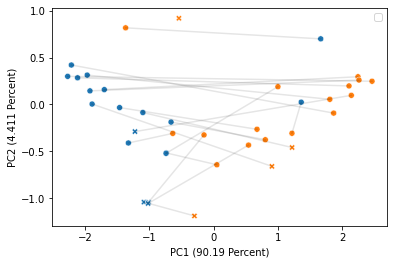

In [9]:
y_sel = y[idx]
y_subj_sel = y_subj[idx]

#Remove all features with zeros in all samples
X_transform = X_orig[idx].transpose()
all_zero = X_transform.sum(axis = 1)
all_zero = np.where(all_zero > 0, True, False)

X_red = X_orig[idx]
X_red = X_red[:, all_zero]

feature_names = np.asarray(X_name)[all_zero]
cluster_names = np.asarray(cluster_name)[all_zero]

data_index = [i for i in range(X_red.shape[0])]

#Split data into training and testing data
x_idx_train, x_idx_test = train_test_split(data_index,
                                           test_size = 0.2,
                                           random_state = 0,
                                           stratify = y_sel)

#Presence-Absence Graph         
X_rare, y_out, y_subj_ss, ret = rarefaction(X_red, 15, y_sel, y_subj_sel, seed=0)

X_trf = np.where(X_rare > 0, 1, 0)
    
M = pcoa(DistanceMatrix(pairwise_distances(X_trf, metric = "jaccard").astype(np.float32)), 
                       number_of_dimensions = 2)
    
train_ret = []
test_ret = []
counter = 0
for i in range(X_red.shape[0]):
    if ret[i] == True:
        if i in x_idx_train:
            train_ret.append(counter)
            
        elif i in x_idx_test:
            test_ret.append(counter)
            
        counter += 1
        
X_proj = M.samples.values
pc1 = str(M.proportion_explained[0] * 100)[0:5]
pc2 = str(M.proportion_explained[1] * 100)[0:5]
            
X_proj_tr = X_proj[train_ret]
X_proj_te = X_proj[test_ret]

df_pa = np.vstack((X_proj_tr, X_proj_te))
train_test = ["Train Data" for _ in range(len(train_ret))]
train_test.extend(["Test Data" for _ in range(len(test_ret))])
hue_data = np.hstack((y_out[train_ret], y_out[test_ret]))
    
sns.scatterplot(x = df_pa[:, 0],
                y = df_pa[:, 1],
                hue = hue_data,
                style = train_test)

plt.xlabel("PC1 (%s Percent)" %pc1)
plt.ylabel("PC2 (%s Percent)" %pc2)

plt.legend('')
        
plt.savefig("Results/PA.svg")
plt.close()

#CLR Graph
X_trf = clr(multiplicative_replacement(closure(X_red)))

M = PCA(2).fit(X_trf[x_idx_train])
pc1 = str(M.explained_variance_ratio_[0] * 100)[0:5]
pc2 = str(M.explained_variance_ratio_[1] * 100)[0:5]

X_proj_tr = M.transform(X_trf[x_idx_train])
X_proj_te = M.transform(X_trf[x_idx_test])

df_clr = np.vstack((X_proj_tr, X_proj_te))
train_test = ["Train Data" for _ in range(X_proj_tr.shape[0])]
train_test.extend(["Test Data" for _ in range(X_proj_te.shape[0])])
hue_data = np.hstack((y_sel[x_idx_train], y_sel[x_idx_test]))

sns.scatterplot(x = df_clr[:, 0],
                y = df_clr[:, 1],
                hue = hue_data,
                style = train_test)

plt.xlabel("PC1 (%s Percent)" %pc1)
plt.ylabel("PC2 (%s Percent)" %pc2)

subj_dict = {}
subj_org = np.hstack((y_subj_sel[x_idx_train], y_subj_sel[x_idx_test]))
for i, entry in enumerate(subj_org):
    if entry not in subj_dict:
        subj_dict[entry] = []
        
    subj_dict[entry].append(df_clr[i])
        
#for subject, points in subj_dict.items():
 #   if len(points) == 2:
  #      plt.plot([points[0][0], points[1][0]], 
   #              [points[0][1], points[1][1]],
    #             'k-',
     #             alpha = 0.1)

plt.savefig("Results/CLR.svg")
plt.close()

#RPCA        
A = rclr(X_red.transpose()).transpose()
M = MatrixCompletion(2, max_iterations = 1000).fit(A)
X_proj = M.U
pc1 = str(M.explained_variance_ratio[0] * 100)[0:5]
pc2 = str(M.explained_variance_ratio[1] * 100)[0:5]

X_proj_tr = X_proj[x_idx_train]
X_proj_te = X_proj[x_idx_test]

df_rclr = np.vstack((X_proj_tr, X_proj_te))
train_test = ["Train Data" for _ in range(X_proj_tr.shape[0])]
train_test.extend(["Test Data" for _ in range(X_proj_te.shape[0])])
hue_data = np.hstack((y_sel[x_idx_train], y_sel[x_idx_test]))
    
sns.scatterplot(x = df_rclr[:, 0],
                y = df_rclr[:, 1],
                hue = hue_data,
                style = train_test)

plt.xlabel("PC1 (%s Percent)" %pc1)
plt.ylabel("PC2 (%s Percent)" %pc2)

plt.legend('')
        
plt.savefig("Results/RCLR.svg")
plt.close()

#Tree Ordination Graph
X_trf = clr(multiplicative_replacement(closure(X_red)))

clf = TreeOrdination(feature_names = cluster_names).fit(X_trf[x_idx_train], y_sel[x_idx_train])

pc1 = str(clf.R_PCA.explained_variance_ratio_[0] * 100)[0:5]
pc2 = str(clf.R_PCA.explained_variance_ratio_[1] * 100)[0:5]

X_proj_tr = clf.R_PCA_emb
X_proj_te = clf.R_PCA.transform(clf.tree_emb.transform(clf.transform(X_trf[x_idx_test])))

df_clr = np.vstack((X_proj_tr, X_proj_te))
train_test = ["Train Data" for _ in range(X_proj_tr.shape[0])]
train_test.extend(["Test Data" for _ in range(X_proj_te.shape[0])])
hue_data = np.hstack((y_sel[x_idx_train], y_sel[x_idx_test]))

sns.scatterplot(x = df_clr[:, 0],
                y = df_clr[:, 1],
                hue = hue_data,
                style = train_test)

plt.xlabel("PC1 (%s Percent)" %pc1)
plt.ylabel("PC2 (%s Percent)" %pc2)

subj_dict = {}
subj_org = np.hstack((y_subj_sel[x_idx_train], y_subj_sel[x_idx_test]))
for i, entry in enumerate(subj_org):
    if entry not in subj_dict:
        subj_dict[entry] = []
        
    subj_dict[entry].append(df_clr[i])
        
for subject, points in subj_dict.items():
    if len(points) == 2:
        plt.plot([points[0][0], points[1][0]], 
                 [points[0][1], points[1][1]],
                 'k-',
                  alpha = 0.1)

plt.legend('')
        
plt.savefig("Results/TreeOrdination.svg")

#### Identify ASVs associated with each class using SAGE.
##### The code below will train a TreeOrdination model. The model will produce an "unsupervised" projection.
##### Randomization will play a role in which features are among the top

In [17]:
y_sel = y[idx]
y_subj_sel = y_subj[idx]

#Remove all features with zeros in all samples and transform using CLR
X_transform = X_orig[idx].transpose()
all_zero = X_transform.sum(axis = 1)
all_zero = np.where(all_zero > 0, True, False)

X_red = X_orig[idx]
X_red = X_red[:, all_zero]

feature_names = np.asarray(X_name)[all_zero]
cluster_names = np.asarray(cluster_name)[all_zero]

data_index = [i for i in range(X_red.shape[0])]

X_trf = clr(multiplicative_replacement(closure(X_red)))

#Split data into training and testing data
x_idx_train, x_idx_test = train_test_split(data_index,
                                           test_size = 0.2,
                                           random_state = 0,
                                           stratify = y_sel)

#Set up the classifier
clf = TreeOrdination(n_jobs = 20,
                     feature_names = cluster_names).fit(X_trf[x_idx_train], y_sel[x_idx_train])


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


In [18]:
#Plot embeddings of approximate and actual projections

D_tr = clf.l_model.predict(X_trf[x_idx_train])
D_te = clf.l_model.predict(X_trf[x_idx_test])
D_comb = np.vstack((D_tr, D_te))
D_comb_hue = np.hstack((y_sel[x_idx_train], y_sel[x_idx_test]))
D_comb_tr_te = np.hstack((["Train" for _ in range(len(x_idx_train))],
                          ["Test" for _ in range(len(x_idx_test))])
                        )

sns.scatterplot(D_comb[:, 0], D_comb[:, 1], hue = D_comb_hue, style = D_comb_tr_te)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.tight_layout()
plt.savefig("Results/Approx_Proj.svg")
plt.close()           

D_tr = clf.R_PCA_emb
D_te = clf.R_PCA.transform(clf.tree_emb.transform(np.hstack([R.proximity(X_trf[x_idx_test]) for R in clf.Rs])))
D_comb = np.vstack((D_tr, D_te))
D_comb_hue = np.hstack((y_sel[x_idx_train], y_sel[x_idx_test]))
D_comb_tr_te = np.hstack((["Train" for _ in range(len(x_idx_train))],
                          ["Test" for _ in range(len(x_idx_test))])
                        )
sns.scatterplot(D_comb[:, 0], D_comb[:, 1], hue = D_comb_hue, style = D_comb_tr_te)
plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
plt.tight_layout()
plt.savefig("Results/Actual_Proj.svg")    
plt.close()

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


In [19]:
import sage as sg

I = sg.MarginalImputer(clf.l_model, X_trf[x_idx_train])
Es = sg.SignEstimator(I, "mse")
SageVal = Es(X_trf[x_idx_train], clf.R_PCA_emb, optimize_ordering = False, verbose = True)

SageVal.plot_sign(np.asarray([x for x in cluster_names]), max_features = 50, tick_size = 10, label_size = 10, figsize = (8.5, 11))

plt.savefig("Results/SAGE.svg")



  0%|                                                                           | 0.0007/1 [00:04<1:51:01, 6665.71s/it]

Sign Ratio = 0.0983 (Converge at 0.4299), Narrow Ratio = 0.0053 (Converge at 0.0250)
Detected feature convergence
Done with feature 0


  0%|                                                                           | 0.0014/1 [00:08<1:46:39, 6408.57s/it]

Sign Ratio = 0.1464 (Converge at 0.4299), Narrow Ratio = 0.0451 (Converge at 0.0250)
Detected feature convergence
Done with feature 1


  0%|▏                                                                          | 0.0021/1 [00:13<1:45:39, 6352.38s/it]

Sign Ratio = 0.0439 (Converge at 0.4299), Narrow Ratio = 0.0439 (Converge at 0.0250)
Detected feature convergence
Done with feature 2


  0%|▏                                                                          | 0.0028/1 [00:17<1:43:11, 6208.81s/it]

Sign Ratio = 0.0429 (Converge at 0.4299), Narrow Ratio = 0.0075 (Converge at 0.0250)
Detected feature convergence
Done with feature 3


  0%|▎                                                                          | 0.0035/1 [00:21<1:41:54, 6136.47s/it]

Sign Ratio = 0.0728 (Converge at 0.4299), Narrow Ratio = 0.0025 (Converge at 0.0250)
Detected feature convergence
Done with feature 4


  0%|▎                                                                          | 0.0042/1 [00:25<1:41:15, 6101.58s/it]

Sign Ratio = 0.0740 (Converge at 0.4299), Narrow Ratio = 0.0071 (Converge at 0.0250)
Detected feature convergence
Done with feature 5


  0%|▎                                                                          | 0.0049/1 [00:29<1:40:55, 6084.83s/it]

Sign Ratio = 0.0661 (Converge at 0.4299), Narrow Ratio = 0.0027 (Converge at 0.0250)
Detected feature convergence
Done with feature 6


  1%|▍                                                                          | 0.0056/1 [00:33<1:39:48, 6021.90s/it]

Sign Ratio = 0.5507 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 7


  1%|▍                                                                          | 0.0063/1 [00:37<1:38:53, 5970.90s/it]

Sign Ratio = 0.0466 (Converge at 0.4299), Narrow Ratio = 0.0046 (Converge at 0.0250)
Detected feature convergence
Done with feature 8


  1%|▌                                                                           | 0.007/1 [00:41<1:38:02, 5923.52s/it]

Sign Ratio = 0.1506 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 9


  1%|▌                                                                          | 0.0077/1 [00:45<1:37:21, 5886.97s/it]

Sign Ratio = 0.1867 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 10


  1%|▋                                                                          | 0.0084/1 [00:49<1:37:11, 5881.39s/it]

Sign Ratio = 1.9971 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 11


  1%|▋                                                                          | 0.0091/1 [00:53<1:37:17, 5890.92s/it]

Sign Ratio = 0.0733 (Converge at 0.4299), Narrow Ratio = 0.0019 (Converge at 0.0250)
Detected feature convergence
Done with feature 12


  1%|▋                                                                          | 0.0098/1 [00:57<1:37:22, 5900.44s/it]

Sign Ratio = 0.0844 (Converge at 0.4299), Narrow Ratio = 0.0052 (Converge at 0.0250)
Detected feature convergence
Done with feature 13


  1%|▊                                                                          | 0.0105/1 [01:01<1:37:18, 5900.61s/it]

Sign Ratio = 0.0467 (Converge at 0.4299), Narrow Ratio = 0.0150 (Converge at 0.0250)
Detected feature convergence
Done with feature 14


  1%|▊                                                                          | 0.0112/1 [01:06<1:37:07, 5893.96s/it]

Sign Ratio = 0.1964 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 15


  1%|▉                                                                          | 0.0119/1 [01:10<1:37:18, 5909.28s/it]

Sign Ratio = 0.7197 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 16


  1%|▉                                                                          | 0.0126/1 [01:14<1:37:45, 5939.87s/it]

Sign Ratio = 0.8286 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 17


  1%|▉                                                                          | 0.0133/1 [01:18<1:37:37, 5936.05s/it]

Sign Ratio = 0.1294 (Converge at 0.4299), Narrow Ratio = 0.0156 (Converge at 0.0250)
Detected feature convergence
Done with feature 18


  1%|█                                                                           | 0.014/1 [01:23<1:37:29, 5932.38s/it]

Sign Ratio = 0.1198 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 19


  1%|█                                                                          | 0.0147/1 [01:27<1:37:31, 5938.49s/it]

Sign Ratio = 0.5436 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 20


  2%|█▏                                                                         | 0.0154/1 [01:31<1:37:27, 5939.30s/it]

Sign Ratio = 0.2640 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 21


  2%|█▏                                                                         | 0.0161/1 [01:35<1:37:16, 5932.31s/it]

Sign Ratio = 0.1188 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 22


  2%|█▎                                                                         | 0.0168/1 [01:39<1:37:05, 5925.13s/it]

Sign Ratio = 0.2452 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 23


  2%|█▎                                                                         | 0.0175/1 [01:43<1:36:56, 5920.01s/it]

Sign Ratio = 0.1810 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 24


  2%|█▎                                                                         | 0.0182/1 [01:47<1:36:58, 5926.11s/it]

Sign Ratio = 0.9353 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 25


  2%|█▍                                                                         | 0.0189/1 [01:52<1:37:27, 5959.75s/it]

Sign Ratio = 0.0420 (Converge at 0.4299), Narrow Ratio = 0.0118 (Converge at 0.0250)
Detected feature convergence
Done with feature 26


  2%|█▍                                                                         | 0.0196/1 [01:57<1:37:42, 5980.06s/it]

Sign Ratio = 0.1232 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 27


  2%|█▌                                                                         | 0.0203/1 [02:01<1:37:45, 5987.10s/it]

Sign Ratio = 0.1224 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 28


  2%|█▌                                                                          | 0.021/1 [02:05<1:37:39, 5985.05s/it]

Sign Ratio = 0.1049 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 29


  2%|█▋                                                                         | 0.0217/1 [02:10<1:37:47, 5998.05s/it]

Sign Ratio = 0.1153 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 30


  2%|█▋                                                                         | 0.0224/1 [02:14<1:37:38, 5992.89s/it]

Sign Ratio = 0.3921 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 31


  2%|█▋                                                                         | 0.0231/1 [02:18<1:37:21, 5979.16s/it]

Sign Ratio = 0.5175 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 32


  2%|█▊                                                                         | 0.0238/1 [02:22<1:37:15, 5977.93s/it]

Sign Ratio = 0.0666 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 33


  2%|█▊                                                                         | 0.0245/1 [02:26<1:37:06, 5972.84s/it]

Sign Ratio = 1.1740 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 34


  3%|█▉                                                                         | 0.0252/1 [02:30<1:37:10, 5981.06s/it]

Sign Ratio = 1.2248 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 35


  3%|█▉                                                                         | 0.0259/1 [02:35<1:37:10, 5985.51s/it]

Sign Ratio = 0.1036 (Converge at 0.4299), Narrow Ratio = 0.0023 (Converge at 0.0250)
Detected feature convergence
Done with feature 36


  3%|█▉                                                                         | 0.0266/1 [02:39<1:37:16, 5996.15s/it]

Sign Ratio = 0.0506 (Converge at 0.4299), Narrow Ratio = 0.0201 (Converge at 0.0250)
Detected feature convergence
Done with feature 37


  3%|██                                                                         | 0.0273/1 [02:43<1:37:14, 5998.00s/it]

Sign Ratio = 0.0681 (Converge at 0.4299), Narrow Ratio = 0.0020 (Converge at 0.0250)
Detected feature convergence
Done with feature 38


  3%|██▏                                                                         | 0.028/1 [02:47<1:37:08, 5996.88s/it]

Sign Ratio = 0.0562 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 39


  3%|██▏                                                                        | 0.0287/1 [02:51<1:37:00, 5992.77s/it]

Sign Ratio = 0.9474 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 40


  3%|██▏                                                                        | 0.0294/1 [02:56<1:37:05, 6002.37s/it]

Sign Ratio = 7.0883 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 41


  3%|██▎                                                                          | 0.03/1 [03:00<1:37:23, 6023.72s/it]

Sign Ratio = 0.3835 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 42


  3%|██▎                                                                        | 0.0307/1 [03:04<1:37:18, 6023.28s/it]

Sign Ratio = 0.0721 (Converge at 0.4299), Narrow Ratio = 0.0026 (Converge at 0.0250)
Detected feature convergence
Done with feature 43


  3%|██▎                                                                        | 0.0314/1 [03:09<1:37:11, 6020.72s/it]

Sign Ratio = 0.0786 (Converge at 0.4299), Narrow Ratio = 0.0016 (Converge at 0.0250)
Detected feature convergence
Done with feature 44


  3%|██▍                                                                        | 0.0321/1 [03:13<1:37:06, 6020.02s/it]

Sign Ratio = 0.1353 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 45


  3%|██▍                                                                        | 0.0328/1 [03:17<1:37:01, 6018.55s/it]

Sign Ratio = 1.9190 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 46


  3%|██▌                                                                        | 0.0335/1 [03:21<1:36:52, 6014.05s/it]

Sign Ratio = 0.1325 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 47


  3%|██▌                                                                        | 0.0342/1 [03:25<1:36:52, 6018.32s/it]

Sign Ratio = 0.1523 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 48


  3%|██▌                                                                        | 0.0349/1 [03:29<1:36:46, 6016.75s/it]

Sign Ratio = 0.0424 (Converge at 0.4299), Narrow Ratio = 0.0247 (Converge at 0.0250)
Detected feature convergence
Done with feature 49


  4%|██▋                                                                        | 0.0356/1 [03:34<1:36:41, 6015.72s/it]

Sign Ratio = 0.1011 (Converge at 0.4299), Narrow Ratio = 0.0018 (Converge at 0.0250)
Detected feature convergence
Done with feature 50


  4%|██▋                                                                        | 0.0363/1 [03:38<1:36:33, 6012.01s/it]

Sign Ratio = 0.0863 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 51


  4%|██▊                                                                         | 0.037/1 [03:42<1:36:25, 6007.35s/it]

Sign Ratio = 0.0673 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 52


  4%|██▊                                                                        | 0.0377/1 [03:46<1:36:15, 6001.89s/it]

Sign Ratio = 0.3946 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 53


  4%|██▉                                                                        | 0.0384/1 [03:50<1:36:09, 5999.82s/it]

Sign Ratio = 0.0572 (Converge at 0.4299), Narrow Ratio = 0.0043 (Converge at 0.0250)
Detected feature convergence
Done with feature 54


  4%|██▉                                                                        | 0.0391/1 [03:54<1:36:05, 6000.16s/it]

Sign Ratio = 0.1445 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 55


  4%|██▉                                                                        | 0.0398/1 [03:58<1:35:57, 5996.15s/it]

Sign Ratio = 0.1967 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 56


  4%|███                                                                        | 0.0405/1 [04:02<1:35:51, 5994.71s/it]

Sign Ratio = 0.2210 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 57


  4%|███                                                                        | 0.0412/1 [04:07<1:35:53, 6000.67s/it]

Sign Ratio = 0.1290 (Converge at 0.4299), Narrow Ratio = 0.0027 (Converge at 0.0250)
Detected feature convergence
Done with feature 58


  4%|███▏                                                                       | 0.0419/1 [04:11<1:35:47, 5998.82s/it]

Sign Ratio = 0.0546 (Converge at 0.4299), Narrow Ratio = 0.0055 (Converge at 0.0250)
Detected feature convergence
Done with feature 59


  4%|███▏                                                                       | 0.0426/1 [04:15<1:35:40, 5995.67s/it]

Sign Ratio = 0.0426 (Converge at 0.4299), Narrow Ratio = 0.0162 (Converge at 0.0250)
Detected feature convergence
Done with feature 60


  4%|███▏                                                                       | 0.0433/1 [04:19<1:35:32, 5991.79s/it]

Sign Ratio = 0.0830 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 61


  4%|███▎                                                                        | 0.044/1 [04:23<1:35:23, 5987.08s/it]

Sign Ratio = 0.0719 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 62


  4%|███▎                                                                       | 0.0447/1 [04:27<1:35:15, 5983.19s/it]

Sign Ratio = 0.2056 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 63


  5%|███▍                                                                       | 0.0454/1 [04:31<1:35:07, 5978.94s/it]

Sign Ratio = 0.4008 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 64


  5%|███▍                                                                       | 0.0461/1 [04:35<1:34:58, 5974.09s/it]

Sign Ratio = 0.0602 (Converge at 0.4299), Narrow Ratio = 0.0037 (Converge at 0.0250)
Detected feature convergence
Done with feature 65


  5%|███▌                                                                       | 0.0468/1 [04:39<1:34:51, 5971.15s/it]

Sign Ratio = 0.0559 (Converge at 0.4299), Narrow Ratio = 0.0036 (Converge at 0.0250)
Detected feature convergence
Done with feature 66


  5%|███▌                                                                       | 0.0475/1 [04:43<1:34:43, 5966.96s/it]

Sign Ratio = 0.3991 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 67


  5%|███▌                                                                       | 0.0482/1 [04:47<1:34:34, 5962.17s/it]

Sign Ratio = 0.0547 (Converge at 0.4299), Narrow Ratio = 0.0226 (Converge at 0.0250)
Detected feature convergence
Done with feature 68


  5%|███▋                                                                       | 0.0489/1 [04:51<1:34:26, 5958.36s/it]

Sign Ratio = 0.1826 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 69


  5%|███▋                                                                       | 0.0496/1 [04:55<1:34:19, 5954.91s/it]

Sign Ratio = 0.0505 (Converge at 0.4299), Narrow Ratio = 0.0036 (Converge at 0.0250)
Detected feature convergence
Done with feature 70


  5%|███▊                                                                       | 0.0503/1 [04:59<1:34:11, 5951.15s/it]

Sign Ratio = 0.0795 (Converge at 0.4299), Narrow Ratio = 0.0025 (Converge at 0.0250)
Detected feature convergence
Done with feature 71


  5%|███▉                                                                        | 0.051/1 [05:03<1:34:07, 5950.85s/it]

Sign Ratio = 0.1355 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 72


  5%|███▉                                                                       | 0.0517/1 [05:07<1:34:05, 5953.18s/it]

Sign Ratio = 0.1912 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 73


  5%|███▉                                                                       | 0.0524/1 [05:11<1:33:58, 5950.81s/it]

Sign Ratio = 0.4428 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 74


  5%|███▉                                                                       | 0.0531/1 [05:16<1:33:57, 5953.59s/it]

Sign Ratio = 0.1675 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 75


  5%|████                                                                       | 0.0538/1 [05:20<1:33:51, 5951.44s/it]

Sign Ratio = 0.0522 (Converge at 0.4299), Narrow Ratio = 0.0519 (Converge at 0.0250)
Detected feature convergence
Done with feature 76


  5%|████                                                                       | 0.0545/1 [05:24<1:33:46, 5950.85s/it]

Sign Ratio = 0.1128 (Converge at 0.4299), Narrow Ratio = 0.0035 (Converge at 0.0250)
Detected feature convergence
Done with feature 77


  6%|████▏                                                                      | 0.0552/1 [05:28<1:33:40, 5948.60s/it]

Sign Ratio = 0.1638 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 78


  6%|████▏                                                                      | 0.0559/1 [05:32<1:33:33, 5945.61s/it]

Sign Ratio = 0.1057 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 79


  6%|████▏                                                                      | 0.0566/1 [05:36<1:33:26, 5942.52s/it]

Sign Ratio = 0.2755 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 80


  6%|████▎                                                                      | 0.0573/1 [05:40<1:33:20, 5940.43s/it]

Sign Ratio = 0.1049 (Converge at 0.4299), Narrow Ratio = 0.0033 (Converge at 0.0250)
Detected feature convergence
Done with feature 81


  6%|████▍                                                                       | 0.058/1 [05:44<1:33:13, 5937.53s/it]

Sign Ratio = 0.4793 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 82


  6%|████▍                                                                      | 0.0587/1 [05:48<1:33:04, 5932.87s/it]

Sign Ratio = 0.9144 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 83


  6%|████▍                                                                      | 0.0594/1 [05:52<1:32:58, 5931.09s/it]

Sign Ratio = 0.1310 (Converge at 0.4299), Narrow Ratio = 0.0046 (Converge at 0.0250)
Detected feature convergence
Done with feature 84


  6%|████▌                                                                      | 0.0601/1 [05:56<1:32:53, 5930.11s/it]

Sign Ratio = 0.1363 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 85


  6%|████▌                                                                      | 0.0608/1 [06:00<1:32:48, 5928.66s/it]

Sign Ratio = 0.1213 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 86


  6%|████▌                                                                      | 0.0615/1 [06:04<1:32:42, 5927.44s/it]

Sign Ratio = 0.2461 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 87


  6%|████▋                                                                      | 0.0622/1 [06:08<1:32:39, 5928.27s/it]

Sign Ratio = 1.3478 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 88


  6%|████▋                                                                      | 0.0629/1 [06:13<1:32:37, 5930.90s/it]

Sign Ratio = 0.3209 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 89


  6%|████▊                                                                      | 0.0636/1 [06:17<1:32:35, 5932.71s/it]

Sign Ratio = 0.0701 (Converge at 0.4299), Narrow Ratio = 0.0020 (Converge at 0.0250)
Detected feature convergence
Done with feature 90


  6%|████▊                                                                      | 0.0643/1 [06:21<1:32:33, 5935.05s/it]

Sign Ratio = 0.0409 (Converge at 0.4299), Narrow Ratio = 0.0244 (Converge at 0.0250)
Detected feature convergence
Done with feature 91


  6%|████▉                                                                       | 0.065/1 [06:25<1:32:30, 5936.78s/it]

Sign Ratio = 0.2710 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 92


  7%|████▉                                                                      | 0.0657/1 [06:30<1:32:28, 5938.81s/it]

Sign Ratio = 0.1279 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 93


  7%|████▉                                                                      | 0.0664/1 [06:34<1:32:26, 5940.94s/it]

Sign Ratio = 0.1538 (Converge at 0.4299), Narrow Ratio = 0.0025 (Converge at 0.0250)
Detected feature convergence
Done with feature 94


  7%|█████                                                                      | 0.0671/1 [06:38<1:32:24, 5943.27s/it]

Sign Ratio = 0.2344 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 95


  7%|█████                                                                      | 0.0678/1 [06:43<1:32:22, 5945.80s/it]

Sign Ratio = 0.1784 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 96


  7%|█████▏                                                                     | 0.0685/1 [06:47<1:32:16, 5944.15s/it]

Sign Ratio = 2.5820 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 97


  7%|█████▏                                                                     | 0.0692/1 [06:51<1:32:10, 5942.15s/it]

Sign Ratio = 0.1666 (Converge at 0.4299), Narrow Ratio = 0.1661 (Converge at 0.0250)
Detected feature convergence
Done with feature 98


  7%|█████▏                                                                     | 0.0699/1 [06:55<1:32:04, 5940.12s/it]

Sign Ratio = 0.0526 (Converge at 0.4299), Narrow Ratio = 0.0030 (Converge at 0.0250)
Detected feature convergence
Done with feature 99


  7%|█████▎                                                                     | 0.0706/1 [06:59<1:31:59, 5938.46s/it]

Sign Ratio = 0.2614 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 100


  7%|█████▎                                                                     | 0.0713/1 [07:03<1:31:53, 5936.66s/it]

Sign Ratio = 0.1477 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 101


  7%|█████▍                                                                      | 0.072/1 [07:07<1:31:47, 5934.49s/it]

Sign Ratio = 0.2542 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 102


  7%|█████▍                                                                     | 0.0727/1 [07:11<1:31:41, 5932.76s/it]

Sign Ratio = 0.1499 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 103


  7%|█████▌                                                                     | 0.0734/1 [07:15<1:31:35, 5930.63s/it]

Sign Ratio = 0.2909 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 104


  7%|█████▌                                                                     | 0.0741/1 [07:19<1:31:29, 5928.62s/it]

Sign Ratio = 0.1008 (Converge at 0.4299), Narrow Ratio = 0.0039 (Converge at 0.0250)
Detected feature convergence
Done with feature 105


  7%|█████▌                                                                     | 0.0748/1 [07:23<1:31:23, 5926.74s/it]

Sign Ratio = 0.0565 (Converge at 0.4299), Narrow Ratio = 0.0031 (Converge at 0.0250)
Detected feature convergence
Done with feature 106


  8%|█████▋                                                                     | 0.0755/1 [07:27<1:31:17, 5924.32s/it]

Sign Ratio = 0.4132 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 107


  8%|█████▋                                                                     | 0.0762/1 [07:31<1:31:11, 5922.72s/it]

Sign Ratio = 0.1318 (Converge at 0.4299), Narrow Ratio = 0.0016 (Converge at 0.0250)
Detected feature convergence
Done with feature 108


  8%|█████▊                                                                     | 0.0769/1 [07:35<1:31:04, 5919.81s/it]

Sign Ratio = 0.0784 (Converge at 0.4299), Narrow Ratio = 0.0015 (Converge at 0.0250)
Detected feature convergence
Done with feature 109


  8%|█████▊                                                                     | 0.0776/1 [07:39<1:30:58, 5918.11s/it]

Sign Ratio = 1.2133 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 110


  8%|█████▊                                                                     | 0.0783/1 [07:43<1:30:52, 5915.84s/it]

Sign Ratio = 0.1152 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 111


  8%|██████                                                                      | 0.079/1 [07:47<1:30:46, 5913.66s/it]

Sign Ratio = 0.0647 (Converge at 0.4299), Narrow Ratio = 0.0015 (Converge at 0.0250)
Detected feature convergence
Done with feature 112


  8%|█████▉                                                                     | 0.0797/1 [07:51<1:30:42, 5913.46s/it]

Sign Ratio = 0.2076 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 113


  8%|██████                                                                     | 0.0804/1 [07:55<1:30:36, 5912.16s/it]

Sign Ratio = 0.1520 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 114


  8%|██████                                                                     | 0.0811/1 [07:59<1:30:30, 5910.12s/it]

Sign Ratio = 0.5281 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 115


  8%|██████▏                                                                    | 0.0818/1 [08:03<1:30:25, 5908.85s/it]

Sign Ratio = 0.2257 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 116


  8%|██████▏                                                                    | 0.0825/1 [08:07<1:30:19, 5907.25s/it]

Sign Ratio = 0.7861 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 117


  8%|██████▏                                                                    | 0.0832/1 [08:11<1:30:13, 5905.29s/it]

Sign Ratio = 0.2321 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 118


  8%|██████▎                                                                    | 0.0839/1 [08:15<1:30:08, 5903.58s/it]

Sign Ratio = 0.0854 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 119


  8%|██████▎                                                                    | 0.0846/1 [08:19<1:30:02, 5901.72s/it]

Sign Ratio = 0.1165 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 120


  9%|██████▍                                                                    | 0.0853/1 [08:23<1:29:56, 5900.23s/it]

Sign Ratio = 0.6844 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 121


  9%|██████▌                                                                     | 0.086/1 [08:27<1:29:51, 5899.20s/it]

Sign Ratio = 0.4200 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 122


  9%|██████▌                                                                    | 0.0867/1 [08:31<1:29:46, 5897.61s/it]

Sign Ratio = 0.0835 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 123


  9%|██████▌                                                                    | 0.0874/1 [08:35<1:29:40, 5895.83s/it]

Sign Ratio = 0.0791 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 124


  9%|██████▌                                                                    | 0.0881/1 [08:39<1:29:35, 5894.57s/it]

Sign Ratio = 0.0686 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 125


  9%|██████▋                                                                    | 0.0887/1 [08:43<1:29:36, 5899.69s/it]

Sign Ratio = 0.0872 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 126


  9%|██████▋                                                                    | 0.0894/1 [08:47<1:29:31, 5898.63s/it]

Sign Ratio = 0.1377 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 127


  9%|██████▊                                                                    | 0.0901/1 [08:51<1:29:27, 5899.50s/it]

Sign Ratio = 0.0939 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 128


  9%|██████▊                                                                    | 0.0908/1 [08:55<1:29:23, 5899.02s/it]

Sign Ratio = 0.1581 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 129


  9%|██████▊                                                                    | 0.0915/1 [08:59<1:29:16, 5896.19s/it]

Sign Ratio = 0.0736 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 130


  9%|██████▉                                                                    | 0.0922/1 [09:03<1:29:07, 5891.05s/it]

Sign Ratio = 0.0674 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 131


  9%|██████▉                                                                    | 0.0929/1 [09:07<1:29:03, 5890.46s/it]

Sign Ratio = 0.0825 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 132


  9%|███████                                                                    | 0.0936/1 [09:11<1:28:59, 5890.45s/it]

Sign Ratio = 0.0469 (Converge at 0.4299), Narrow Ratio = 0.0051 (Converge at 0.0250)
Detected feature convergence
Done with feature 133


  9%|███████                                                                    | 0.0943/1 [09:15<1:28:54, 5890.16s/it]

Sign Ratio = 0.0652 (Converge at 0.4299), Narrow Ratio = 0.0022 (Converge at 0.0250)
Detected feature convergence
Done with feature 134


 10%|███████▏                                                                    | 0.095/1 [09:19<1:28:49, 5889.25s/it]

Sign Ratio = 0.3770 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 135


 10%|███████▏                                                                   | 0.0957/1 [09:23<1:28:44, 5888.18s/it]

Sign Ratio = 0.1100 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 136


 10%|███████▏                                                                   | 0.0964/1 [09:27<1:28:41, 5889.04s/it]

Sign Ratio = 0.5505 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 137


 10%|███████▎                                                                   | 0.0971/1 [09:31<1:28:38, 5890.48s/it]

Sign Ratio = 0.0793 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 138


 10%|███████▎                                                                   | 0.0978/1 [09:36<1:28:34, 5890.57s/it]

Sign Ratio = 0.2363 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 139


 10%|███████▍                                                                   | 0.0985/1 [09:40<1:28:31, 5891.44s/it]

Sign Ratio = 0.1892 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 140


 10%|███████▍                                                                   | 0.0992/1 [09:44<1:28:30, 5895.62s/it]

Sign Ratio = 0.1127 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 141


 10%|███████▍                                                                   | 0.0999/1 [09:49<1:28:29, 5899.19s/it]

Sign Ratio = 2.9100 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 142


 10%|███████▌                                                                   | 0.1006/1 [09:53<1:28:27, 5901.06s/it]

Sign Ratio = 1.2178 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 143


 10%|███████▌                                                                   | 0.1013/1 [09:57<1:28:24, 5902.34s/it]

Sign Ratio = 2.5381 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 144


 10%|███████▊                                                                    | 0.102/1 [10:01<1:28:19, 5901.44s/it]

Sign Ratio = 0.0538 (Converge at 0.4299), Narrow Ratio = 0.0035 (Converge at 0.0250)
Detected feature convergence
Done with feature 145


 10%|███████▋                                                                   | 0.1027/1 [10:05<1:28:13, 5899.75s/it]

Sign Ratio = 0.0866 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 146


 10%|███████▊                                                                   | 0.1034/1 [10:09<1:28:08, 5898.32s/it]

Sign Ratio = 0.0655 (Converge at 0.4299), Narrow Ratio = 0.0026 (Converge at 0.0250)
Detected feature convergence
Done with feature 147


 10%|███████▊                                                                   | 0.1041/1 [10:14<1:28:04, 5898.74s/it]

Sign Ratio = 3.6297 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 148


 10%|███████▊                                                                   | 0.1048/1 [10:18<1:27:59, 5897.10s/it]

Sign Ratio = 188.7683 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 149


 11%|███████▉                                                                   | 0.1055/1 [10:21<1:27:53, 5895.05s/it]

Sign Ratio = 0.0725 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 150


 11%|███████▉                                                                   | 0.1062/1 [10:25<1:27:46, 5892.70s/it]

Sign Ratio = 0.1111 (Converge at 0.4299), Narrow Ratio = 0.0019 (Converge at 0.0250)
Detected feature convergence
Done with feature 151


 11%|████████                                                                   | 0.1069/1 [10:29<1:27:41, 5890.77s/it]

Sign Ratio = 0.0694 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 152


 11%|████████                                                                   | 0.1076/1 [10:33<1:27:34, 5887.83s/it]

Sign Ratio = 0.0910 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 153


 11%|████████                                                                   | 0.1083/1 [10:37<1:27:28, 5885.60s/it]

Sign Ratio = 0.1089 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 154


 11%|████████▎                                                                   | 0.109/1 [10:41<1:27:23, 5884.78s/it]

Sign Ratio = 0.1654 (Converge at 0.4299), Narrow Ratio = 0.0035 (Converge at 0.0250)
Detected feature convergence
Done with feature 155


 11%|████████▏                                                                  | 0.1097/1 [10:45<1:27:19, 5884.74s/it]

Sign Ratio = 0.3255 (Converge at 0.4299), Narrow Ratio = 0.0026 (Converge at 0.0250)
Detected feature convergence
Done with feature 156


 11%|████████▎                                                                  | 0.1104/1 [10:49<1:27:13, 5882.59s/it]

Sign Ratio = 0.0943 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 157


 11%|████████▎                                                                  | 0.1111/1 [10:53<1:27:08, 5882.30s/it]

Sign Ratio = 7.0990 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 158


 11%|████████▍                                                                  | 0.1118/1 [10:57<1:27:05, 5882.72s/it]

Sign Ratio = 0.1258 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 159


 11%|████████▍                                                                  | 0.1125/1 [11:01<1:27:00, 5882.23s/it]

Sign Ratio = 0.2803 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 160


 11%|████████▍                                                                  | 0.1132/1 [11:05<1:26:54, 5880.65s/it]

Sign Ratio = 0.0460 (Converge at 0.4299), Narrow Ratio = 0.0049 (Converge at 0.0250)
Detected feature convergence
Done with feature 161


 11%|████████▌                                                                  | 0.1139/1 [11:09<1:26:50, 5880.37s/it]

Sign Ratio = 0.1135 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 162


 11%|████████▌                                                                  | 0.1146/1 [11:13<1:26:45, 5879.44s/it]

Sign Ratio = 0.0670 (Converge at 0.4299), Narrow Ratio = 0.0019 (Converge at 0.0250)
Detected feature convergence
Done with feature 163


 12%|████████▋                                                                  | 0.1153/1 [11:17<1:26:40, 5878.04s/it]

Sign Ratio = 0.1079 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 164


 12%|████████▊                                                                   | 0.116/1 [11:21<1:26:35, 5877.00s/it]

Sign Ratio = 0.0820 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 165


 12%|████████▊                                                                  | 0.1167/1 [11:25<1:26:30, 5876.42s/it]

Sign Ratio = 0.0820 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 166


 12%|████████▊                                                                  | 0.1174/1 [11:29<1:26:25, 5875.55s/it]

Sign Ratio = 0.1062 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 167


 12%|████████▊                                                                  | 0.1181/1 [11:33<1:26:20, 5874.47s/it]

Sign Ratio = 0.0800 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 168


 12%|████████▉                                                                  | 0.1188/1 [11:37<1:26:17, 5874.99s/it]

Sign Ratio = 0.2127 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 169


 12%|████████▉                                                                  | 0.1195/1 [11:42<1:26:15, 5878.34s/it]

Sign Ratio = 0.2996 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 170


 12%|█████████                                                                  | 0.1202/1 [11:46<1:26:11, 5877.69s/it]

Sign Ratio = 1.3107 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 171


 12%|█████████                                                                  | 0.1209/1 [11:50<1:26:06, 5877.57s/it]

Sign Ratio = 0.3703 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 172


 12%|█████████                                                                  | 0.1216/1 [11:54<1:26:03, 5878.27s/it]

Sign Ratio = 1.0430 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 173


 12%|█████████▏                                                                 | 0.1223/1 [11:58<1:25:58, 5877.48s/it]

Sign Ratio = 0.0584 (Converge at 0.4299), Narrow Ratio = 0.0020 (Converge at 0.0250)
Detected feature convergence
Done with feature 174


 12%|█████████▎                                                                  | 0.123/1 [12:02<1:25:54, 5877.79s/it]

Sign Ratio = 0.0812 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 175


 12%|█████████▎                                                                 | 0.1237/1 [12:06<1:25:49, 5876.38s/it]

Sign Ratio = 0.0510 (Converge at 0.4299), Narrow Ratio = 0.0023 (Converge at 0.0250)
Detected feature convergence
Done with feature 176


 12%|█████████▎                                                                 | 0.1244/1 [12:10<1:25:44, 5875.93s/it]

Sign Ratio = 0.1002 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 177


 13%|█████████▍                                                                 | 0.1251/1 [12:14<1:25:38, 5873.49s/it]

Sign Ratio = 0.1525 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 178


 13%|█████████▍                                                                 | 0.1258/1 [12:18<1:25:31, 5869.94s/it]

Sign Ratio = 0.0650 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 179


 13%|█████████▍                                                                 | 0.1265/1 [12:23<1:25:32, 5876.01s/it]

Sign Ratio = 0.0850 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 180


 13%|█████████▌                                                                 | 0.1272/1 [12:27<1:25:29, 5877.02s/it]

Sign Ratio = 0.0907 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 181


 13%|█████████▌                                                                 | 0.1279/1 [12:31<1:25:25, 5877.08s/it]

Sign Ratio = 0.0457 (Converge at 0.4299), Narrow Ratio = 0.0026 (Converge at 0.0250)
Detected feature convergence
Done with feature 182


 13%|█████████▋                                                                 | 0.1286/1 [12:35<1:25:21, 5877.34s/it]

Sign Ratio = 0.0417 (Converge at 0.4299), Narrow Ratio = 0.0024 (Converge at 0.0250)
Detected feature convergence
Done with feature 183


 13%|█████████▋                                                                 | 0.1293/1 [12:40<1:25:22, 5883.11s/it]

Sign Ratio = 0.0449 (Converge at 0.4299), Narrow Ratio = 0.0021 (Converge at 0.0250)
Detected feature convergence
Done with feature 184


 13%|██████████                                                                   | 0.13/1 [12:45<1:25:24, 5889.97s/it]

Sign Ratio = 0.0902 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 185


 13%|█████████▊                                                                 | 0.1307/1 [12:50<1:25:25, 5896.59s/it]

Sign Ratio = 0.8487 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 186


 13%|█████████▊                                                                 | 0.1314/1 [12:55<1:25:25, 5900.90s/it]

Sign Ratio = 0.0803 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 187


 13%|█████████▉                                                                 | 0.1321/1 [13:00<1:25:26, 5906.66s/it]

Sign Ratio = 0.2500 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 188


 13%|█████████▉                                                                 | 0.1328/1 [13:05<1:25:31, 5917.06s/it]

Sign Ratio = 0.0885 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 189


 13%|██████████                                                                 | 0.1335/1 [13:10<1:25:29, 5919.27s/it]

Sign Ratio = 0.1104 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 190


 13%|██████████                                                                 | 0.1342/1 [13:14<1:25:26, 5921.67s/it]

Sign Ratio = 0.0387 (Converge at 0.4299), Narrow Ratio = 0.0167 (Converge at 0.0250)
Detected feature convergence
Done with feature 191


 13%|██████████                                                                 | 0.1349/1 [13:19<1:25:23, 5922.96s/it]

Sign Ratio = 0.0865 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 192


 14%|██████████▏                                                                | 0.1356/1 [13:23<1:25:19, 5922.60s/it]

Sign Ratio = 0.1495 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 193


 14%|██████████▏                                                                | 0.1363/1 [13:27<1:25:15, 5922.30s/it]

Sign Ratio = 0.4354 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 194


 14%|██████████▍                                                                 | 0.137/1 [13:31<1:25:11, 5923.32s/it]

Sign Ratio = 0.2971 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 195


 14%|██████████▎                                                                | 0.1377/1 [13:36<1:25:10, 5927.03s/it]

Sign Ratio = 0.1404 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 196


 14%|██████████▍                                                                | 0.1384/1 [13:40<1:25:09, 5930.13s/it]

Sign Ratio = 0.1060 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 197


 14%|██████████▍                                                                | 0.1391/1 [13:45<1:25:06, 5932.09s/it]

Sign Ratio = 0.1025 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 198


 14%|██████████▍                                                                | 0.1398/1 [13:49<1:25:03, 5933.07s/it]

Sign Ratio = 0.0714 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 199


 14%|██████████▌                                                                | 0.1405/1 [13:54<1:25:02, 5936.40s/it]

Sign Ratio = 0.2833 (Converge at 0.4299), Narrow Ratio = 0.0043 (Converge at 0.0250)
Detected feature convergence
Done with feature 200


 14%|██████████▌                                                                | 0.1412/1 [13:58<1:24:58, 5936.58s/it]

Sign Ratio = 0.1806 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 201


 14%|██████████▋                                                                | 0.1419/1 [14:02<1:24:55, 5937.57s/it]

Sign Ratio = 0.9267 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 202


 14%|██████████▋                                                                | 0.1426/1 [14:06<1:24:51, 5938.31s/it]

Sign Ratio = 0.1550 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 203


 14%|██████████▋                                                                | 0.1433/1 [14:11<1:24:49, 5941.12s/it]

Sign Ratio = 0.2654 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 204


 14%|██████████▉                                                                 | 0.144/1 [14:15<1:24:45, 5940.71s/it]

Sign Ratio = 0.0454 (Converge at 0.4299), Narrow Ratio = 0.0023 (Converge at 0.0250)
Detected feature convergence
Done with feature 205


 14%|██████████▊                                                                | 0.1447/1 [14:19<1:24:40, 5940.50s/it]

Sign Ratio = 0.1125 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 206


 15%|██████████▉                                                                | 0.1454/1 [14:23<1:24:36, 5939.75s/it]

Sign Ratio = 0.2023 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 207


 15%|██████████▉                                                                | 0.1461/1 [14:27<1:24:30, 5938.36s/it]

Sign Ratio = 0.0946 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 208


 15%|███████████                                                                | 0.1468/1 [14:31<1:24:25, 5937.19s/it]

Sign Ratio = 0.4104 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 209


 15%|███████████                                                                | 0.1474/1 [14:35<1:24:25, 5940.65s/it]

Sign Ratio = 0.2311 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 210


 15%|███████████                                                                | 0.1481/1 [14:39<1:24:19, 5939.31s/it]

Sign Ratio = 0.0923 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 211


 15%|███████████▏                                                               | 0.1488/1 [14:43<1:24:14, 5938.48s/it]

Sign Ratio = 0.2651 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 212


 15%|███████████▏                                                               | 0.1495/1 [14:47<1:24:09, 5937.49s/it]

Sign Ratio = 0.1275 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 213


 15%|███████████▎                                                               | 0.1502/1 [14:51<1:24:04, 5936.45s/it]

Sign Ratio = 0.0671 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 214


 15%|███████████▎                                                               | 0.1509/1 [14:55<1:23:59, 5935.29s/it]

Sign Ratio = 0.1271 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 215


 15%|███████████▎                                                               | 0.1516/1 [14:59<1:23:54, 5934.26s/it]

Sign Ratio = 0.2863 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 216


 15%|███████████▍                                                               | 0.1523/1 [15:03<1:23:49, 5933.25s/it]

Sign Ratio = 0.4940 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 217


 15%|███████████▋                                                                | 0.153/1 [15:07<1:23:44, 5932.38s/it]

Sign Ratio = 0.1101 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 218


 15%|███████████▌                                                               | 0.1537/1 [15:11<1:23:39, 5931.31s/it]

Sign Ratio = 0.2291 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 219


 15%|███████████▌                                                               | 0.1544/1 [15:15<1:23:34, 5930.43s/it]

Sign Ratio = 12.4613 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 220


 16%|███████████▋                                                               | 0.1551/1 [15:19<1:23:29, 5929.31s/it]

Sign Ratio = 0.3087 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 221


 16%|███████████▋                                                               | 0.1558/1 [15:23<1:23:24, 5928.49s/it]

Sign Ratio = 0.1480 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 222


 16%|███████████▋                                                               | 0.1565/1 [15:27<1:23:20, 5927.71s/it]

Sign Ratio = 0.1504 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 223


 16%|███████████▊                                                               | 0.1572/1 [15:31<1:23:15, 5927.02s/it]

Sign Ratio = 0.0950 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 224


 16%|███████████▊                                                               | 0.1579/1 [15:35<1:23:10, 5925.89s/it]

Sign Ratio = 2.5173 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 225


 16%|███████████▉                                                               | 0.1586/1 [15:39<1:23:04, 5924.42s/it]

Sign Ratio = 0.1224 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 226


 16%|███████████▉                                                               | 0.1593/1 [15:43<1:22:58, 5921.97s/it]

Sign Ratio = 0.0764 (Converge at 0.4299), Narrow Ratio = 0.0054 (Converge at 0.0250)
Detected feature convergence
Done with feature 227


 16%|████████████▎                                                                | 0.16/1 [15:47<1:22:53, 5921.23s/it]

Sign Ratio = 0.0886 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 228


 16%|████████████                                                               | 0.1607/1 [15:51<1:22:49, 5920.50s/it]

Sign Ratio = 0.1048 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 229


 16%|████████████                                                               | 0.1614/1 [15:55<1:22:45, 5920.85s/it]

Sign Ratio = 0.0687 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 230


 16%|████████████▏                                                              | 0.1621/1 [15:59<1:22:40, 5920.25s/it]

Sign Ratio = 0.2054 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 231


 16%|████████████▏                                                              | 0.1628/1 [16:03<1:22:36, 5920.67s/it]

Sign Ratio = 0.0616 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 232


 16%|████████████▎                                                              | 0.1635/1 [16:08<1:22:33, 5921.63s/it]

Sign Ratio = 0.1061 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 233


 16%|████████████▎                                                              | 0.1642/1 [16:12<1:22:29, 5922.40s/it]

Sign Ratio = 3.2015 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 234


 16%|████████████▎                                                              | 0.1649/1 [16:16<1:22:26, 5922.72s/it]

Sign Ratio = 0.0993 (Converge at 0.4299), Narrow Ratio = 0.0141 (Converge at 0.0250)
Detected feature convergence
Done with feature 235


 17%|████████████▍                                                              | 0.1656/1 [16:20<1:22:22, 5923.62s/it]

Sign Ratio = 0.1166 (Converge at 0.4299), Narrow Ratio = 0.0016 (Converge at 0.0250)
Detected feature convergence
Done with feature 236


 17%|████████████▍                                                              | 0.1663/1 [16:25<1:22:18, 5923.79s/it]

Sign Ratio = 0.0540 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 237


 17%|████████████▋                                                               | 0.167/1 [16:29<1:22:16, 5925.96s/it]

Sign Ratio = 0.8230 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 238


 17%|████████████▌                                                              | 0.1677/1 [16:33<1:22:13, 5926.97s/it]

Sign Ratio = 0.1746 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 239


 17%|████████████▋                                                              | 0.1684/1 [16:38<1:22:09, 5927.87s/it]

Sign Ratio = 0.1280 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 240


 17%|████████████▋                                                              | 0.1691/1 [16:42<1:22:05, 5928.31s/it]

Sign Ratio = 0.0731 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 241


 17%|████████████▋                                                              | 0.1698/1 [16:46<1:22:01, 5927.84s/it]

Sign Ratio = 0.1053 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 242


 17%|████████████▊                                                              | 0.1705/1 [16:50<1:21:56, 5926.99s/it]

Sign Ratio = 0.1770 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 243


 17%|████████████▊                                                              | 0.1712/1 [16:54<1:21:51, 5925.81s/it]

Sign Ratio = 0.2670 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 244


 17%|████████████▉                                                              | 0.1719/1 [16:58<1:21:46, 5924.87s/it]

Sign Ratio = 0.1386 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 245


 17%|████████████▉                                                              | 0.1726/1 [17:02<1:21:41, 5923.91s/it]

Sign Ratio = 0.2050 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 246


 17%|████████████▉                                                              | 0.1733/1 [17:06<1:21:36, 5922.89s/it]

Sign Ratio = 1.2742 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 247


 17%|█████████████▏                                                              | 0.174/1 [17:10<1:21:31, 5921.89s/it]

Sign Ratio = 0.0521 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 248


 17%|█████████████                                                              | 0.1747/1 [17:14<1:21:27, 5921.88s/it]

Sign Ratio = 0.3046 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 249


 18%|█████████████▏                                                             | 0.1754/1 [17:18<1:21:22, 5920.88s/it]

Sign Ratio = 0.0559 (Converge at 0.4299), Narrow Ratio = 0.0024 (Converge at 0.0250)
Detected feature convergence
Done with feature 250


 18%|█████████████▏                                                             | 0.1761/1 [17:22<1:21:18, 5921.41s/it]

Sign Ratio = 0.2982 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 251


 18%|█████████████▎                                                             | 0.1768/1 [17:26<1:21:13, 5920.55s/it]

Sign Ratio = 2.0267 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 252


 18%|█████████████▎                                                             | 0.1775/1 [17:30<1:21:08, 5919.06s/it]

Sign Ratio = 1.3124 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 253


 18%|█████████████▎                                                             | 0.1782/1 [17:34<1:21:03, 5917.56s/it]

Sign Ratio = 0.0630 (Converge at 0.4299), Narrow Ratio = 0.0112 (Converge at 0.0250)
Detected feature convergence
Done with feature 254


 18%|█████████████▍                                                             | 0.1789/1 [17:38<1:20:58, 5916.64s/it]

Sign Ratio = 0.1929 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 255


 18%|█████████████▍                                                             | 0.1796/1 [17:42<1:20:54, 5916.75s/it]

Sign Ratio = 0.0998 (Converge at 0.4299), Narrow Ratio = 0.0067 (Converge at 0.0250)
Detected feature convergence
Done with feature 256


 18%|█████████████▌                                                             | 0.1803/1 [17:46<1:20:49, 5916.01s/it]

Sign Ratio = 0.4598 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 257


 18%|█████████████▊                                                              | 0.181/1 [17:50<1:20:44, 5914.94s/it]

Sign Ratio = 0.1172 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 258


 18%|█████████████▋                                                             | 0.1817/1 [17:54<1:20:39, 5913.89s/it]

Sign Ratio = 0.1657 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 259


 18%|█████████████▋                                                             | 0.1824/1 [17:58<1:20:34, 5913.03s/it]

Sign Ratio = 0.0508 (Converge at 0.4299), Narrow Ratio = 0.0036 (Converge at 0.0250)
Detected feature convergence
Done with feature 260


 18%|█████████████▋                                                             | 0.1831/1 [18:02<1:20:29, 5912.19s/it]

Sign Ratio = 0.0862 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 261


 18%|█████████████▊                                                             | 0.1838/1 [18:06<1:20:25, 5911.56s/it]

Sign Ratio = 0.1414 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 262


 18%|█████████████▊                                                             | 0.1845/1 [18:10<1:20:20, 5910.94s/it]

Sign Ratio = 2.9570 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 263


 19%|█████████████▉                                                             | 0.1852/1 [18:14<1:20:15, 5910.08s/it]

Sign Ratio = 0.5986 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 264


 19%|█████████████▉                                                             | 0.1859/1 [18:18<1:20:10, 5909.38s/it]

Sign Ratio = 0.1169 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 265


 19%|█████████████▉                                                             | 0.1866/1 [18:22<1:20:06, 5908.83s/it]

Sign Ratio = 0.1513 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 266


 19%|██████████████                                                             | 0.1873/1 [18:26<1:20:01, 5907.97s/it]

Sign Ratio = 0.4487 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 267


 19%|██████████████▎                                                             | 0.188/1 [18:30<1:19:56, 5907.45s/it]

Sign Ratio = 0.0501 (Converge at 0.4299), Narrow Ratio = 0.0025 (Converge at 0.0250)
Detected feature convergence
Done with feature 268


 19%|██████████████▏                                                            | 0.1887/1 [18:34<1:19:52, 5906.77s/it]

Sign Ratio = 0.2363 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 269


 19%|██████████████▏                                                            | 0.1894/1 [18:38<1:19:47, 5906.22s/it]

Sign Ratio = 0.0644 (Converge at 0.4299), Narrow Ratio = 0.0022 (Converge at 0.0250)
Detected feature convergence
Done with feature 270


 19%|██████████████▎                                                            | 0.1901/1 [18:42<1:19:42, 5905.58s/it]

Sign Ratio = 0.3131 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 271


 19%|██████████████▎                                                            | 0.1908/1 [18:46<1:19:38, 5905.19s/it]

Sign Ratio = 0.0408 (Converge at 0.4299), Narrow Ratio = 0.0021 (Converge at 0.0250)
Detected feature convergence
Done with feature 272


 19%|██████████████▎                                                            | 0.1915/1 [18:50<1:19:33, 5904.49s/it]

Sign Ratio = 0.0409 (Converge at 0.4299), Narrow Ratio = 0.0196 (Converge at 0.0250)
Detected feature convergence
Done with feature 273


 19%|██████████████▍                                                            | 0.1922/1 [18:54<1:19:28, 5903.45s/it]

Sign Ratio = 0.1241 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 274


 19%|██████████████▍                                                            | 0.1929/1 [18:58<1:19:23, 5901.51s/it]

Sign Ratio = 0.0838 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 275


 19%|██████████████▌                                                            | 0.1936/1 [19:02<1:19:18, 5901.24s/it]

Sign Ratio = 0.4799 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 276


 19%|██████████████▌                                                            | 0.1943/1 [19:06<1:19:14, 5900.82s/it]

Sign Ratio = 0.1001 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 277


 20%|██████████████▊                                                             | 0.195/1 [19:10<1:19:09, 5900.25s/it]

Sign Ratio = 0.0695 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 278


 20%|██████████████▋                                                            | 0.1957/1 [19:14<1:19:05, 5899.85s/it]

Sign Ratio = 0.0590 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 279


 20%|██████████████▋                                                            | 0.1964/1 [19:18<1:19:00, 5899.65s/it]

Sign Ratio = 0.0912 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 280


 20%|██████████████▊                                                            | 0.1971/1 [19:23<1:18:57, 5900.78s/it]

Sign Ratio = 0.0654 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 281


 20%|██████████████▊                                                            | 0.1978/1 [19:27<1:18:54, 5902.00s/it]

Sign Ratio = 0.1480 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 282


 20%|██████████████▉                                                            | 0.1985/1 [19:31<1:18:51, 5902.84s/it]

Sign Ratio = 0.1320 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 283


 20%|██████████████▉                                                            | 0.1992/1 [19:36<1:18:47, 5903.65s/it]

Sign Ratio = 0.1112 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 284


 20%|██████████████▉                                                            | 0.1999/1 [19:40<1:18:44, 5904.73s/it]

Sign Ratio = 0.1453 (Converge at 0.4299), Narrow Ratio = 0.0020 (Converge at 0.0250)
Detected feature convergence
Done with feature 285


 20%|███████████████                                                            | 0.2006/1 [19:44<1:18:40, 5905.59s/it]

Sign Ratio = 0.0896 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 286


 20%|███████████████                                                            | 0.2013/1 [19:48<1:18:37, 5906.16s/it]

Sign Ratio = 0.0458 (Converge at 0.4299), Narrow Ratio = 0.0033 (Converge at 0.0250)
Detected feature convergence
Done with feature 287


 20%|███████████████▎                                                            | 0.202/1 [19:53<1:18:34, 5907.59s/it]

Sign Ratio = 0.0646 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 288


 20%|███████████████▏                                                           | 0.2027/1 [19:57<1:18:30, 5907.48s/it]

Sign Ratio = 0.3045 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 289


 20%|███████████████▎                                                           | 0.2034/1 [20:01<1:18:26, 5907.71s/it]

Sign Ratio = 0.1520 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 290


 20%|███████████████▎                                                           | 0.2041/1 [20:05<1:18:21, 5907.44s/it]

Sign Ratio = 0.0816 (Converge at 0.4299), Narrow Ratio = 0.0071 (Converge at 0.0250)
Detected feature convergence
Done with feature 291


 20%|███████████████▎                                                           | 0.2048/1 [20:09<1:18:17, 5906.84s/it]

Sign Ratio = 0.0934 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 292


 21%|███████████████▍                                                           | 0.2055/1 [20:13<1:18:12, 5906.12s/it]

Sign Ratio = 0.0460 (Converge at 0.4299), Narrow Ratio = 0.0031 (Converge at 0.0250)
Detected feature convergence
Done with feature 293


 21%|███████████████▍                                                           | 0.2061/1 [20:17<1:18:10, 5908.15s/it]

Sign Ratio = 0.1316 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 294


 21%|███████████████▌                                                           | 0.2068/1 [20:21<1:18:05, 5907.50s/it]

Sign Ratio = 0.1328 (Converge at 0.4299), Narrow Ratio = 0.0020 (Converge at 0.0250)
Detected feature convergence
Done with feature 295


 21%|███████████████▌                                                           | 0.2075/1 [20:25<1:18:01, 5906.79s/it]

Sign Ratio = 0.2862 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 296


 21%|███████████████▌                                                           | 0.2082/1 [20:29<1:17:56, 5906.05s/it]

Sign Ratio = 5.3791 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 297


 21%|███████████████▋                                                           | 0.2089/1 [20:33<1:17:51, 5905.66s/it]

Sign Ratio = 0.3645 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 298


 21%|███████████████▋                                                           | 0.2096/1 [20:37<1:17:47, 5905.35s/it]

Sign Ratio = 0.1349 (Converge at 0.4299), Narrow Ratio = 0.0054 (Converge at 0.0250)
Detected feature convergence
Done with feature 299


 21%|███████████████▊                                                           | 0.2103/1 [20:41<1:17:42, 5904.58s/it]

Sign Ratio = 0.3924 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 300


 21%|████████████████                                                            | 0.211/1 [20:45<1:17:38, 5904.10s/it]

Sign Ratio = 0.1674 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 301


 21%|███████████████▉                                                           | 0.2117/1 [20:49<1:17:33, 5903.44s/it]

Sign Ratio = 0.0916 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 302


 21%|███████████████▉                                                           | 0.2124/1 [20:53<1:17:29, 5903.06s/it]

Sign Ratio = 0.0916 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 303


 21%|███████████████▉                                                           | 0.2131/1 [20:57<1:17:24, 5902.58s/it]

Sign Ratio = 0.0920 (Converge at 0.4299), Narrow Ratio = 0.0049 (Converge at 0.0250)
Detected feature convergence
Done with feature 304


 21%|████████████████                                                           | 0.2138/1 [21:01<1:17:20, 5902.11s/it]

Sign Ratio = 0.0960 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 305


 21%|████████████████                                                           | 0.2145/1 [21:05<1:17:15, 5901.84s/it]

Sign Ratio = 0.0692 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 306


 22%|████████████████▏                                                          | 0.2152/1 [21:10<1:17:12, 5902.85s/it]

Sign Ratio = 0.4956 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 307


 22%|████████████████▏                                                          | 0.2159/1 [21:14<1:17:07, 5901.98s/it]

Sign Ratio = 0.0834 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 308


 22%|████████████████▏                                                          | 0.2166/1 [21:18<1:17:02, 5900.83s/it]

Sign Ratio = 0.1518 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 309


 22%|████████████████▎                                                          | 0.2173/1 [21:21<1:16:57, 5899.57s/it]

Sign Ratio = 0.8621 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 310


 22%|████████████████▌                                                           | 0.218/1 [21:25<1:16:52, 5898.63s/it]

Sign Ratio = 0.0672 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 311


 22%|████████████████▍                                                          | 0.2187/1 [21:29<1:16:48, 5897.96s/it]

Sign Ratio = 0.9807 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 312


 22%|████████████████▍                                                          | 0.2194/1 [21:33<1:16:43, 5897.40s/it]

Sign Ratio = 0.0442 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 313


 22%|████████████████▌                                                          | 0.2201/1 [21:37<1:16:38, 5896.89s/it]

Sign Ratio = 0.0945 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 314


 22%|████████████████▌                                                          | 0.2208/1 [21:41<1:16:34, 5896.01s/it]

Sign Ratio = 0.4780 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 315


 22%|████████████████▌                                                          | 0.2215/1 [21:45<1:16:29, 5895.93s/it]

Sign Ratio = 0.0771 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 316


 22%|████████████████▋                                                          | 0.2222/1 [21:50<1:16:26, 5896.44s/it]

Sign Ratio = 0.1266 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 317


 22%|████████████████▋                                                          | 0.2229/1 [21:54<1:16:22, 5896.54s/it]

Sign Ratio = 0.0722 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 318


 22%|████████████████▊                                                          | 0.2236/1 [21:58<1:16:18, 5897.24s/it]

Sign Ratio = 0.9003 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 319


 22%|████████████████▊                                                          | 0.2243/1 [22:02<1:16:14, 5896.70s/it]

Sign Ratio = 0.0482 (Converge at 0.4299), Narrow Ratio = 0.0199 (Converge at 0.0250)
Detected feature convergence
Done with feature 320


 22%|█████████████████                                                           | 0.225/1 [22:06<1:16:09, 5895.92s/it]

Sign Ratio = 0.1251 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 321


 23%|████████████████▉                                                          | 0.2257/1 [22:10<1:16:04, 5895.31s/it]

Sign Ratio = 0.5648 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 322


 23%|████████████████▉                                                          | 0.2264/1 [22:14<1:16:00, 5894.70s/it]

Sign Ratio = 0.1796 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 323


 23%|█████████████████                                                          | 0.2271/1 [22:18<1:15:56, 5894.89s/it]

Sign Ratio = 0.1225 (Converge at 0.4299), Narrow Ratio = 0.0015 (Converge at 0.0250)
Detected feature convergence
Done with feature 324


 23%|█████████████████                                                          | 0.2278/1 [22:22<1:15:52, 5895.30s/it]

Sign Ratio = 0.4158 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 325


 23%|█████████████████▏                                                         | 0.2285/1 [22:27<1:15:48, 5896.19s/it]

Sign Ratio = 0.1520 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 326


 23%|█████████████████▏                                                         | 0.2292/1 [22:31<1:15:44, 5896.19s/it]

Sign Ratio = 0.3282 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 327


 23%|█████████████████▏                                                         | 0.2299/1 [22:35<1:15:41, 5897.18s/it]

Sign Ratio = 0.0488 (Converge at 0.4299), Narrow Ratio = 0.0046 (Converge at 0.0250)
Detected feature convergence
Done with feature 328


 23%|█████████████████▎                                                         | 0.2306/1 [22:40<1:15:38, 5898.78s/it]

Sign Ratio = 0.3081 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 329


 23%|█████████████████▎                                                         | 0.2313/1 [22:45<1:15:38, 5903.48s/it]

Sign Ratio = 0.5690 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 330


 23%|█████████████████▋                                                          | 0.232/1 [22:50<1:15:35, 5905.45s/it]

Sign Ratio = 0.2381 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 331


 23%|█████████████████▍                                                         | 0.2327/1 [22:54<1:15:31, 5906.18s/it]

Sign Ratio = 0.1404 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 332


 23%|█████████████████▌                                                         | 0.2334/1 [22:58<1:15:29, 5908.26s/it]

Sign Ratio = 0.0737 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 333


 23%|█████████████████▌                                                         | 0.2341/1 [23:03<1:15:26, 5910.18s/it]

Sign Ratio = 0.0606 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 334


 23%|█████████████████▌                                                         | 0.2348/1 [23:07<1:15:22, 5910.84s/it]

Sign Ratio = 0.1714 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 335


 24%|█████████████████▋                                                         | 0.2355/1 [23:12<1:15:19, 5911.76s/it]

Sign Ratio = 0.0555 (Converge at 0.4299), Narrow Ratio = 0.0018 (Converge at 0.0250)
Detected feature convergence
Done with feature 336


 24%|█████████████████▋                                                         | 0.2362/1 [23:16<1:15:15, 5911.42s/it]

Sign Ratio = 0.1536 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 337


 24%|█████████████████▊                                                         | 0.2369/1 [23:20<1:15:10, 5911.31s/it]

Sign Ratio = 0.1674 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 338


 24%|█████████████████▊                                                         | 0.2376/1 [23:24<1:15:07, 5911.97s/it]

Sign Ratio = 0.0881 (Converge at 0.4299), Narrow Ratio = 0.0575 (Converge at 0.0250)
Detected feature convergence
Done with feature 339


 24%|█████████████████▊                                                         | 0.2383/1 [23:28<1:15:02, 5911.76s/it]

Sign Ratio = 0.4429 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 340


 24%|██████████████████▏                                                         | 0.239/1 [23:32<1:14:59, 5912.04s/it]

Sign Ratio = 0.0849 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 341


 24%|█████████████████▉                                                         | 0.2397/1 [23:37<1:14:55, 5912.78s/it]

Sign Ratio = 0.1431 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 342


 24%|██████████████████                                                         | 0.2404/1 [23:41<1:14:51, 5912.34s/it]

Sign Ratio = 0.1846 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 343


 24%|██████████████████                                                         | 0.2411/1 [23:45<1:14:46, 5911.59s/it]

Sign Ratio = 0.2428 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 344


 24%|██████████████████▏                                                        | 0.2418/1 [23:49<1:14:41, 5910.90s/it]

Sign Ratio = 0.0502 (Converge at 0.4299), Narrow Ratio = 0.0050 (Converge at 0.0250)
Detected feature convergence
Done with feature 345


 24%|██████████████████▏                                                        | 0.2425/1 [23:53<1:14:37, 5910.27s/it]

Sign Ratio = 0.2698 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 346


 24%|██████████████████▏                                                        | 0.2432/1 [23:57<1:14:32, 5909.63s/it]

Sign Ratio = 0.2824 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 347


 24%|██████████████████▎                                                        | 0.2439/1 [24:01<1:14:28, 5909.41s/it]

Sign Ratio = 0.0882 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 348


 24%|██████████████████▎                                                        | 0.2446/1 [24:05<1:14:23, 5908.83s/it]

Sign Ratio = 0.1868 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 349


 25%|██████████████████▍                                                        | 0.2453/1 [24:09<1:14:18, 5907.60s/it]

Sign Ratio = 0.1066 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 350


 25%|██████████████████▋                                                         | 0.246/1 [24:13<1:14:14, 5907.26s/it]

Sign Ratio = 0.1130 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 351


 25%|██████████████████▌                                                        | 0.2467/1 [24:17<1:14:09, 5907.30s/it]

Sign Ratio = 0.1184 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 352


 25%|██████████████████▌                                                        | 0.2474/1 [24:21<1:14:05, 5906.76s/it]

Sign Ratio = 0.1085 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 353


 25%|██████████████████▌                                                        | 0.2481/1 [24:25<1:14:01, 5906.43s/it]

Sign Ratio = 0.0767 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 354


 25%|██████████████████▋                                                        | 0.2488/1 [24:29<1:13:56, 5906.23s/it]

Sign Ratio = 0.0739 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 355


 25%|██████████████████▋                                                        | 0.2495/1 [24:33<1:13:52, 5906.67s/it]

Sign Ratio = 0.0687 (Converge at 0.4299), Narrow Ratio = 0.0024 (Converge at 0.0250)
Detected feature convergence
Done with feature 356


 25%|██████████████████▊                                                        | 0.2502/1 [24:37<1:13:48, 5906.14s/it]

Sign Ratio = 0.1121 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 357


 25%|██████████████████▊                                                        | 0.2509/1 [24:41<1:13:44, 5906.21s/it]

Sign Ratio = 0.0795 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 358


 25%|██████████████████▊                                                        | 0.2516/1 [24:45<1:13:39, 5905.73s/it]

Sign Ratio = 0.1763 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 359


 25%|██████████████████▉                                                        | 0.2523/1 [24:49<1:13:35, 5905.20s/it]

Sign Ratio = 0.0422 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 360


 25%|███████████████████▏                                                        | 0.253/1 [24:53<1:13:30, 5904.47s/it]

Sign Ratio = 0.0573 (Converge at 0.4299), Narrow Ratio = 0.0021 (Converge at 0.0250)
Detected feature convergence
Done with feature 361


 25%|███████████████████                                                        | 0.2537/1 [24:57<1:13:26, 5903.83s/it]

Sign Ratio = 0.0607 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 362


 25%|███████████████████                                                        | 0.2544/1 [25:01<1:13:21, 5903.69s/it]

Sign Ratio = 0.0565 (Converge at 0.4299), Narrow Ratio = 0.0563 (Converge at 0.0250)
Detected feature convergence
Done with feature 363


 26%|███████████████████▏                                                       | 0.2551/1 [25:05<1:13:17, 5903.23s/it]

Sign Ratio = 0.0685 (Converge at 0.4299), Narrow Ratio = 0.0066 (Converge at 0.0250)
Detected feature convergence
Done with feature 364


 26%|███████████████████▏                                                       | 0.2558/1 [25:09<1:13:12, 5902.82s/it]

Sign Ratio = 0.1973 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 365


 26%|███████████████████▏                                                       | 0.2565/1 [25:14<1:13:08, 5902.56s/it]

Sign Ratio = 0.5764 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 366


 26%|███████████████████▎                                                       | 0.2572/1 [25:18<1:13:04, 5902.25s/it]

Sign Ratio = 0.3794 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 367


 26%|███████████████████▎                                                       | 0.2579/1 [25:22<1:13:00, 5902.21s/it]

Sign Ratio = 0.1079 (Converge at 0.4299), Narrow Ratio = 0.0020 (Converge at 0.0250)
Detected feature convergence
Done with feature 368


 26%|███████████████████▍                                                       | 0.2586/1 [25:26<1:12:55, 5901.43s/it]

Sign Ratio = 0.5126 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 369


 26%|███████████████████▍                                                       | 0.2593/1 [25:29<1:12:50, 5900.15s/it]

Sign Ratio = 0.1511 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 370


 26%|████████████████████                                                         | 0.26/1 [25:33<1:12:44, 5898.48s/it]

Sign Ratio = 0.2980 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 371


 26%|███████████████████▌                                                       | 0.2607/1 [25:37<1:12:40, 5897.96s/it]

Sign Ratio = 0.0743 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 372


 26%|███████████████████▌                                                       | 0.2614/1 [25:41<1:12:36, 5898.64s/it]

Sign Ratio = 0.1061 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 373


 26%|███████████████████▋                                                       | 0.2621/1 [25:46<1:12:32, 5899.04s/it]

Sign Ratio = 0.4509 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 374


 26%|███████████████████▋                                                       | 0.2628/1 [25:50<1:12:28, 5898.81s/it]

Sign Ratio = 0.8000 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 375


 26%|███████████████████▊                                                       | 0.2635/1 [25:54<1:12:24, 5899.30s/it]

Sign Ratio = 0.0718 (Converge at 0.4299), Narrow Ratio = 0.0016 (Converge at 0.0250)
Detected feature convergence
Done with feature 376


 26%|███████████████████▊                                                       | 0.2642/1 [25:58<1:12:21, 5900.08s/it]

Sign Ratio = 0.1345 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 377


 26%|███████████████████▊                                                       | 0.2648/1 [26:03<1:12:19, 5902.76s/it]

Sign Ratio = 0.1080 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 378


 27%|███████████████████▉                                                       | 0.2655/1 [26:07<1:12:16, 5903.96s/it]

Sign Ratio = 0.0488 (Converge at 0.4299), Narrow Ratio = 0.0028 (Converge at 0.0250)
Detected feature convergence
Done with feature 379


 27%|███████████████████▉                                                       | 0.2662/1 [26:11<1:12:12, 5904.31s/it]

Sign Ratio = 0.0843 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 380


 27%|████████████████████                                                       | 0.2669/1 [26:16<1:12:08, 5904.95s/it]

Sign Ratio = 0.0752 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 381


 27%|████████████████████                                                       | 0.2676/1 [26:20<1:12:05, 5906.26s/it]

Sign Ratio = 0.0506 (Converge at 0.4299), Narrow Ratio = 0.0091 (Converge at 0.0250)
Detected feature convergence
Done with feature 382


 27%|████████████████████                                                       | 0.2683/1 [26:24<1:12:02, 5907.55s/it]

Sign Ratio = 0.0934 (Converge at 0.4299), Narrow Ratio = 0.0086 (Converge at 0.0250)
Detected feature convergence
Done with feature 383


 27%|████████████████████▍                                                       | 0.269/1 [26:29<1:11:58, 5908.33s/it]

Sign Ratio = 0.0624 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 384


 27%|████████████████████▏                                                      | 0.2697/1 [26:33<1:11:54, 5907.80s/it]

Sign Ratio = 0.0628 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 385


 27%|████████████████████▎                                                      | 0.2704/1 [26:37<1:11:50, 5907.65s/it]

Sign Ratio = 0.1056 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 386


 27%|████████████████████▎                                                      | 0.2711/1 [26:41<1:11:46, 5907.53s/it]

Sign Ratio = 0.0471 (Converge at 0.4299), Narrow Ratio = 0.0050 (Converge at 0.0250)
Detected feature convergence
Done with feature 387


 27%|████████████████████▍                                                      | 0.2718/1 [26:45<1:11:41, 5907.42s/it]

Sign Ratio = 0.1824 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 388


 27%|████████████████████▍                                                      | 0.2725/1 [26:49<1:11:37, 5906.86s/it]

Sign Ratio = 0.7926 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 389


 27%|████████████████████▍                                                      | 0.2732/1 [26:53<1:11:33, 5907.15s/it]

Sign Ratio = 0.3475 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 390


 27%|████████████████████▌                                                      | 0.2739/1 [26:57<1:11:28, 5906.77s/it]

Sign Ratio = 0.1364 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 391


 27%|████████████████████▌                                                      | 0.2746/1 [27:01<1:11:24, 5906.53s/it]

Sign Ratio = 0.0451 (Converge at 0.4299), Narrow Ratio = 0.0016 (Converge at 0.0250)
Detected feature convergence
Done with feature 392


 28%|████████████████████▋                                                      | 0.2753/1 [27:05<1:11:20, 5906.18s/it]

Sign Ratio = 0.1415 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 393


 28%|████████████████████▉                                                       | 0.276/1 [27:10<1:11:15, 5905.83s/it]

Sign Ratio = 0.0486 (Converge at 0.4299), Narrow Ratio = 0.0037 (Converge at 0.0250)
Detected feature convergence
Done with feature 394


 28%|████████████████████▊                                                      | 0.2767/1 [27:14<1:11:11, 5905.48s/it]

Sign Ratio = 0.2594 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 395


 28%|████████████████████▊                                                      | 0.2774/1 [27:18<1:11:06, 5904.91s/it]

Sign Ratio = 0.0808 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 396


 28%|████████████████████▊                                                      | 0.2781/1 [27:22<1:11:02, 5904.40s/it]

Sign Ratio = 0.1901 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 397


 28%|████████████████████▉                                                      | 0.2788/1 [27:26<1:10:57, 5903.99s/it]

Sign Ratio = 0.3648 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 398


 28%|████████████████████▉                                                      | 0.2795/1 [27:30<1:10:53, 5903.47s/it]

Sign Ratio = 0.1193 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 399


 28%|█████████████████████                                                      | 0.2802/1 [27:34<1:10:48, 5902.93s/it]

Sign Ratio = 0.2090 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 400


 28%|█████████████████████                                                      | 0.2809/1 [27:38<1:10:44, 5902.53s/it]

Sign Ratio = 0.0527 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 401


 28%|█████████████████████                                                      | 0.2816/1 [27:42<1:10:40, 5902.17s/it]

Sign Ratio = 0.1899 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 402


 28%|█████████████████████▏                                                     | 0.2823/1 [27:46<1:10:35, 5901.79s/it]

Sign Ratio = 0.9387 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 403


 28%|█████████████████████▌                                                      | 0.283/1 [27:50<1:10:31, 5901.27s/it]

Sign Ratio = 0.0901 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 404


 28%|█████████████████████▎                                                     | 0.2837/1 [27:54<1:10:26, 5900.82s/it]

Sign Ratio = 0.1997 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 405


 28%|█████████████████████▎                                                     | 0.2844/1 [27:58<1:10:22, 5900.51s/it]

Sign Ratio = 0.7680 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 406


 29%|█████████████████████▍                                                     | 0.2851/1 [28:02<1:10:18, 5900.22s/it]

Sign Ratio = 0.1724 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 407


 29%|█████████████████████▍                                                     | 0.2858/1 [28:06<1:10:13, 5899.88s/it]

Sign Ratio = 0.1211 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 408


 29%|█████████████████████▍                                                     | 0.2865/1 [28:10<1:10:09, 5899.42s/it]

Sign Ratio = 4.8302 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 409


 29%|█████████████████████▌                                                     | 0.2872/1 [28:14<1:10:04, 5898.85s/it]

Sign Ratio = 0.2073 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 410


 29%|█████████████████████▌                                                     | 0.2879/1 [28:18<1:10:01, 5899.55s/it]

Sign Ratio = 0.1052 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 411


 29%|█████████████████████▋                                                     | 0.2886/1 [28:22<1:09:57, 5900.70s/it]

Sign Ratio = 0.2804 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 412


 29%|█████████████████████▋                                                     | 0.2893/1 [28:27<1:09:54, 5901.95s/it]

Sign Ratio = 0.1444 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 413


 29%|██████████████████████▎                                                      | 0.29/1 [28:31<1:09:50, 5901.46s/it]

Sign Ratio = 0.1639 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 414


 29%|█████████████████████▊                                                     | 0.2907/1 [28:35<1:09:46, 5902.09s/it]

Sign Ratio = 0.1234 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 415


 29%|█████████████████████▊                                                     | 0.2914/1 [28:39<1:09:42, 5902.49s/it]

Sign Ratio = 0.1431 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 416


 29%|█████████████████████▉                                                     | 0.2921/1 [28:44<1:09:38, 5902.40s/it]

Sign Ratio = 0.0807 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 417


 29%|█████████████████████▉                                                     | 0.2928/1 [28:48<1:09:33, 5902.13s/it]

Sign Ratio = 0.4356 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 418


 29%|██████████████████████                                                     | 0.2935/1 [28:52<1:09:30, 5902.84s/it]

Sign Ratio = 0.3252 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 419


 29%|██████████████████████                                                     | 0.2942/1 [28:56<1:09:25, 5902.07s/it]

Sign Ratio = 0.0865 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 420


 29%|██████████████████████                                                     | 0.2949/1 [29:00<1:09:21, 5902.19s/it]

Sign Ratio = 0.3013 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 421


 30%|██████████████████████▏                                                    | 0.2956/1 [29:04<1:09:17, 5902.70s/it]

Sign Ratio = 0.1431 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 422


 30%|██████████████████████▏                                                    | 0.2963/1 [29:09<1:09:14, 5903.29s/it]

Sign Ratio = 0.2485 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 423


 30%|██████████████████████▌                                                     | 0.297/1 [29:13<1:09:10, 5904.65s/it]

Sign Ratio = 0.0649 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 424


 30%|██████████████████████▎                                                    | 0.2977/1 [29:18<1:09:08, 5906.81s/it]

Sign Ratio = 0.1523 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 425


 30%|██████████████████████▍                                                    | 0.2984/1 [29:22<1:09:05, 5907.99s/it]

Sign Ratio = 0.0501 (Converge at 0.4299), Narrow Ratio = 0.0021 (Converge at 0.0250)
Detected feature convergence
Done with feature 426


 30%|██████████████████████▍                                                    | 0.2991/1 [29:27<1:09:01, 5909.06s/it]

Sign Ratio = 0.6931 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 427


 30%|██████████████████████▍                                                    | 0.2998/1 [29:31<1:08:58, 5910.09s/it]

Sign Ratio = 0.9806 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 428


 30%|██████████████████████▌                                                    | 0.3005/1 [29:36<1:08:54, 5910.45s/it]

Sign Ratio = 0.2330 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 429


 30%|██████████████████████▌                                                    | 0.3012/1 [29:40<1:08:50, 5911.03s/it]

Sign Ratio = 0.1331 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 430


 30%|██████████████████████▋                                                    | 0.3019/1 [29:44<1:08:47, 5911.79s/it]

Sign Ratio = 0.0472 (Converge at 0.4299), Narrow Ratio = 0.0047 (Converge at 0.0250)
Detected feature convergence
Done with feature 431


 30%|██████████████████████▋                                                    | 0.3026/1 [29:48<1:08:42, 5911.43s/it]

Sign Ratio = 0.0944 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 432


 30%|██████████████████████▋                                                    | 0.3033/1 [29:52<1:08:38, 5910.98s/it]

Sign Ratio = 0.1633 (Converge at 0.4299), Narrow Ratio = 0.0051 (Converge at 0.0250)
Detected feature convergence
Done with feature 433


 30%|███████████████████████                                                     | 0.304/1 [29:57<1:08:34, 5911.19s/it]

Sign Ratio = 0.1151 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 434


 30%|██████████████████████▊                                                    | 0.3047/1 [30:01<1:08:29, 5910.81s/it]

Sign Ratio = 0.0427 (Converge at 0.4299), Narrow Ratio = 0.0044 (Converge at 0.0250)
Detected feature convergence
Done with feature 435


 31%|██████████████████████▉                                                    | 0.3054/1 [30:05<1:08:25, 5910.45s/it]

Sign Ratio = 0.1211 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 436


 31%|██████████████████████▉                                                    | 0.3061/1 [30:09<1:08:21, 5910.63s/it]

Sign Ratio = 0.2639 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 437


 31%|███████████████████████                                                    | 0.3068/1 [30:13<1:08:16, 5909.98s/it]

Sign Ratio = 0.1240 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 438


 31%|███████████████████████                                                    | 0.3075/1 [30:17<1:08:11, 5909.02s/it]

Sign Ratio = 0.1555 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 439


 31%|███████████████████████                                                    | 0.3082/1 [30:20<1:08:07, 5908.47s/it]

Sign Ratio = 0.6548 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 440


 31%|███████████████████████▏                                                   | 0.3089/1 [30:25<1:08:04, 5909.58s/it]

Sign Ratio = 0.2122 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 441


 31%|███████████████████████▏                                                   | 0.3096/1 [30:29<1:07:59, 5909.51s/it]

Sign Ratio = 0.1658 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 442


 31%|███████████████████████▎                                                   | 0.3103/1 [30:33<1:07:55, 5909.01s/it]

Sign Ratio = 0.0636 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 443


 31%|███████████████████████▋                                                    | 0.311/1 [30:37<1:07:50, 5908.55s/it]

Sign Ratio = 0.0832 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 444


 31%|███████████████████████▍                                                   | 0.3117/1 [30:41<1:07:46, 5908.08s/it]

Sign Ratio = 0.1689 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 445


 31%|███████████████████████▍                                                   | 0.3124/1 [30:45<1:07:42, 5907.68s/it]

Sign Ratio = 0.2144 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 446


 31%|███████████████████████▍                                                   | 0.3131/1 [30:49<1:07:37, 5907.20s/it]

Sign Ratio = 0.2191 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 447


 31%|███████████████████████▌                                                   | 0.3138/1 [30:53<1:07:33, 5906.76s/it]

Sign Ratio = 0.0671 (Converge at 0.4299), Narrow Ratio = 0.0144 (Converge at 0.0250)
Detected feature convergence
Done with feature 448


 31%|███████████████████████▌                                                   | 0.3145/1 [30:57<1:07:28, 5906.37s/it]

Sign Ratio = 0.1070 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 449


 32%|███████████████████████▋                                                   | 0.3152/1 [31:01<1:07:24, 5905.88s/it]

Sign Ratio = 0.0453 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 450


 32%|███████████████████████▋                                                   | 0.3159/1 [31:05<1:07:19, 5905.50s/it]

Sign Ratio = 0.5547 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 451


 32%|███████████████████████▋                                                   | 0.3166/1 [31:09<1:07:15, 5905.15s/it]

Sign Ratio = 0.0554 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 452


 32%|███████████████████████▊                                                   | 0.3173/1 [31:13<1:07:11, 5904.78s/it]

Sign Ratio = 0.0494 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 453


 32%|████████████████████████▏                                                   | 0.318/1 [31:17<1:07:06, 5904.44s/it]

Sign Ratio = 0.0675 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 454


 32%|███████████████████████▉                                                   | 0.3187/1 [31:21<1:07:02, 5904.04s/it]

Sign Ratio = 0.0824 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 455


 32%|███████████████████████▉                                                   | 0.3194/1 [31:25<1:06:58, 5903.70s/it]

Sign Ratio = 0.3278 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 456


 32%|████████████████████████                                                   | 0.3201/1 [31:29<1:06:53, 5903.32s/it]

Sign Ratio = 0.5675 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 457


 32%|████████████████████████                                                   | 0.3208/1 [31:33<1:06:49, 5902.96s/it]

Sign Ratio = 0.0842 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 458


 32%|████████████████████████                                                   | 0.3215/1 [31:37<1:06:45, 5902.74s/it]

Sign Ratio = 0.1084 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 459


 32%|████████████████████████▏                                                  | 0.3222/1 [31:41<1:06:40, 5902.40s/it]

Sign Ratio = 0.3172 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 460


 32%|████████████████████████▏                                                  | 0.3229/1 [31:45<1:06:36, 5902.34s/it]

Sign Ratio = 0.0717 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 461


 32%|████████████████████████▎                                                  | 0.3235/1 [31:49<1:06:34, 5903.97s/it]

Sign Ratio = 0.1215 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 462


 32%|████████████████████████▎                                                  | 0.3242/1 [31:53<1:06:29, 5903.67s/it]

Sign Ratio = 2.7343 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 463


 32%|████████████████████████▎                                                  | 0.3249/1 [31:57<1:06:25, 5903.34s/it]

Sign Ratio = 0.3549 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 464


 33%|████████████████████████▍                                                  | 0.3256/1 [32:01<1:06:20, 5902.70s/it]

Sign Ratio = 0.3015 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 465


 33%|████████████████████████▍                                                  | 0.3263/1 [32:05<1:06:16, 5902.18s/it]

Sign Ratio = 0.1496 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 466


 33%|████████████████████████▊                                                   | 0.327/1 [32:09<1:06:12, 5901.99s/it]

Sign Ratio = 0.1143 (Converge at 0.4299), Narrow Ratio = 0.0022 (Converge at 0.0250)
Detected feature convergence
Done with feature 467


 33%|████████████████████████▌                                                  | 0.3277/1 [32:13<1:06:07, 5901.66s/it]

Sign Ratio = 0.0841 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 468


 33%|████████████████████████▋                                                  | 0.3284/1 [32:18<1:06:03, 5901.35s/it]

Sign Ratio = 0.2374 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 469


 33%|████████████████████████▋                                                  | 0.3291/1 [32:21<1:05:58, 5900.91s/it]

Sign Ratio = 0.0613 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 470


 33%|████████████████████████▋                                                  | 0.3298/1 [32:26<1:05:55, 5901.30s/it]

Sign Ratio = 0.0735 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 471


 33%|████████████████████████▊                                                  | 0.3305/1 [32:30<1:05:51, 5901.98s/it]

Sign Ratio = 0.0778 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 472


 33%|████████████████████████▊                                                  | 0.3312/1 [32:34<1:05:47, 5902.53s/it]

Sign Ratio = 0.0493 (Converge at 0.4299), Narrow Ratio = 0.0030 (Converge at 0.0250)
Detected feature convergence
Done with feature 473


 33%|████████████████████████▉                                                  | 0.3319/1 [32:39<1:05:43, 5903.00s/it]

Sign Ratio = 0.0921 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 474


 33%|████████████████████████▉                                                  | 0.3326/1 [32:43<1:05:40, 5903.51s/it]

Sign Ratio = 0.4759 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 475


 33%|████████████████████████▉                                                  | 0.3333/1 [32:47<1:05:36, 5904.55s/it]

Sign Ratio = 0.0462 (Converge at 0.4299), Narrow Ratio = 0.0130 (Converge at 0.0250)
Detected feature convergence
Done with feature 476


 33%|█████████████████████████▍                                                  | 0.334/1 [32:52<1:05:33, 5905.58s/it]

Sign Ratio = 0.9016 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 477


 33%|█████████████████████████                                                  | 0.3347/1 [32:56<1:05:29, 5906.37s/it]

Sign Ratio = 0.0733 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 478


 34%|█████████████████████████▏                                                 | 0.3354/1 [33:01<1:05:25, 5906.77s/it]

Sign Ratio = 0.0805 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 479


 34%|█████████████████████████▏                                                 | 0.3361/1 [33:05<1:05:21, 5906.41s/it]

Sign Ratio = 0.1670 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 480


 34%|█████████████████████████▎                                                 | 0.3368/1 [33:09<1:05:17, 5906.35s/it]

Sign Ratio = 0.0476 (Converge at 0.4299), Narrow Ratio = 0.0095 (Converge at 0.0250)
Detected feature convergence
Done with feature 481


 34%|█████████████████████████▎                                                 | 0.3375/1 [33:13<1:05:12, 5905.88s/it]

Sign Ratio = 0.1430 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 482


 34%|█████████████████████████▎                                                 | 0.3382/1 [33:17<1:05:08, 5905.59s/it]

Sign Ratio = 0.0962 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 483


 34%|█████████████████████████▍                                                 | 0.3389/1 [33:21<1:05:03, 5905.24s/it]

Sign Ratio = 0.2374 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 484


 34%|█████████████████████████▍                                                 | 0.3396/1 [33:25<1:04:59, 5904.90s/it]

Sign Ratio = 0.2281 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 485


 34%|█████████████████████████▌                                                 | 0.3403/1 [33:29<1:04:55, 5904.60s/it]

Sign Ratio = 0.0656 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 486


 34%|█████████████████████████▉                                                  | 0.341/1 [33:33<1:04:50, 5904.18s/it]

Sign Ratio = 0.1096 (Converge at 0.4299), Narrow Ratio = 0.0065 (Converge at 0.0250)
Detected feature convergence
Done with feature 487


 34%|█████████████████████████▋                                                 | 0.3417/1 [33:37<1:04:47, 5904.97s/it]

Sign Ratio = 0.0593 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 488


 34%|█████████████████████████▋                                                 | 0.3424/1 [33:42<1:04:43, 5905.39s/it]

Sign Ratio = 0.0791 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 489


 34%|█████████████████████████▋                                                 | 0.3431/1 [33:46<1:04:39, 5905.32s/it]

Sign Ratio = 0.1541 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 490


 34%|█████████████████████████▊                                                 | 0.3438/1 [33:50<1:04:35, 5906.68s/it]

Sign Ratio = 0.2415 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 491


 34%|█████████████████████████▊                                                 | 0.3445/1 [33:54<1:04:31, 5906.70s/it]

Sign Ratio = 0.0471 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 492


 35%|█████████████████████████▉                                                 | 0.3452/1 [33:58<1:04:27, 5906.59s/it]

Sign Ratio = 0.5158 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 493


 35%|█████████████████████████▉                                                 | 0.3459/1 [34:03<1:04:23, 5906.75s/it]

Sign Ratio = 0.1255 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 494


 35%|█████████████████████████▉                                                 | 0.3466/1 [34:07<1:04:19, 5907.26s/it]

Sign Ratio = 0.1079 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 495


 35%|██████████████████████████                                                 | 0.3473/1 [34:11<1:04:16, 5907.85s/it]

Sign Ratio = 0.1615 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 496


 35%|██████████████████████████▍                                                 | 0.348/1 [34:15<1:04:11, 5907.85s/it]

Sign Ratio = 0.0815 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 497


 35%|██████████████████████████▏                                                | 0.3487/1 [34:19<1:04:07, 5907.10s/it]

Sign Ratio = 0.1551 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 498


 35%|██████████████████████████▏                                                | 0.3494/1 [34:23<1:04:02, 5906.32s/it]

Sign Ratio = 0.3035 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 499


 35%|██████████████████████████▎                                                | 0.3501/1 [34:27<1:03:58, 5905.96s/it]

Sign Ratio = 0.1646 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 500


 35%|██████████████████████████▎                                                | 0.3508/1 [34:31<1:03:53, 5905.38s/it]

Sign Ratio = 0.8850 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 501


 35%|██████████████████████████▎                                                | 0.3515/1 [34:35<1:03:49, 5904.97s/it]

Sign Ratio = 0.1243 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 502


 35%|██████████████████████████▍                                                | 0.3522/1 [34:39<1:03:44, 5904.58s/it]

Sign Ratio = 0.4113 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 503


 35%|██████████████████████████▍                                                | 0.3529/1 [34:43<1:03:40, 5904.01s/it]

Sign Ratio = 0.2066 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 504


 35%|██████████████████████████▌                                                | 0.3536/1 [34:47<1:03:36, 5903.66s/it]

Sign Ratio = 0.0614 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 505


 35%|██████████████████████████▌                                                | 0.3543/1 [34:51<1:03:31, 5903.62s/it]

Sign Ratio = 0.0441 (Converge at 0.4299), Narrow Ratio = 0.0174 (Converge at 0.0250)
Detected feature convergence
Done with feature 506


 36%|██████████████████████████▉                                                 | 0.355/1 [34:55<1:03:27, 5903.25s/it]

Sign Ratio = 0.1558 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 507


 36%|██████████████████████████▋                                                | 0.3557/1 [34:59<1:03:23, 5902.65s/it]

Sign Ratio = 0.0731 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 508


 36%|██████████████████████████▋                                                | 0.3564/1 [35:03<1:03:18, 5902.19s/it]

Sign Ratio = 0.0729 (Converge at 0.4299), Narrow Ratio = 0.0048 (Converge at 0.0250)
Detected feature convergence
Done with feature 509


 36%|██████████████████████████▊                                                | 0.3571/1 [35:07<1:03:14, 5901.88s/it]

Sign Ratio = 0.0827 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 510


 36%|██████████████████████████▊                                                | 0.3578/1 [35:11<1:03:09, 5901.47s/it]

Sign Ratio = 0.0413 (Converge at 0.4299), Narrow Ratio = 0.0167 (Converge at 0.0250)
Detected feature convergence
Done with feature 511


 36%|██████████████████████████▉                                                | 0.3585/1 [35:15<1:03:05, 5900.94s/it]

Sign Ratio = 0.1276 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 512


 36%|██████████████████████████▉                                                | 0.3592/1 [35:19<1:03:00, 5900.16s/it]

Sign Ratio = 0.1186 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 513


 36%|██████████████████████████▉                                                | 0.3599/1 [35:23<1:02:56, 5899.84s/it]

Sign Ratio = 0.1322 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 514


 36%|███████████████████████████                                                | 0.3606/1 [35:27<1:02:52, 5899.54s/it]

Sign Ratio = 0.0665 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 515


 36%|███████████████████████████                                                | 0.3613/1 [35:31<1:02:47, 5899.08s/it]

Sign Ratio = 0.1476 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 516


 36%|███████████████████████████▌                                                | 0.362/1 [35:35<1:02:43, 5898.81s/it]

Sign Ratio = 0.2945 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 517


 36%|███████████████████████████▏                                               | 0.3627/1 [35:39<1:02:39, 5898.78s/it]

Sign Ratio = 0.0536 (Converge at 0.4299), Narrow Ratio = 0.0015 (Converge at 0.0250)
Detected feature convergence
Done with feature 518


 36%|███████████████████████████▎                                               | 0.3634/1 [35:43<1:02:35, 5899.07s/it]

Sign Ratio = 0.1611 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 519


 36%|███████████████████████████▎                                               | 0.3641/1 [35:48<1:02:31, 5899.60s/it]

Sign Ratio = 0.0909 (Converge at 0.4299), Narrow Ratio = 0.0223 (Converge at 0.0250)
Detected feature convergence
Done with feature 520


 36%|███████████████████████████▎                                               | 0.3648/1 [35:52<1:02:27, 5899.87s/it]

Sign Ratio = 0.0400 (Converge at 0.4299), Narrow Ratio = 0.0163 (Converge at 0.0250)
Detected feature convergence
Done with feature 521


 37%|███████████████████████████▍                                               | 0.3655/1 [35:56<1:02:23, 5900.31s/it]

Sign Ratio = 0.0639 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 522


 37%|███████████████████████████▍                                               | 0.3662/1 [36:00<1:02:20, 5900.93s/it]

Sign Ratio = 0.0804 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 523


 37%|███████████████████████████▌                                               | 0.3669/1 [36:05<1:02:16, 5901.20s/it]

Sign Ratio = 0.1133 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 524


 37%|███████████████████████████▌                                               | 0.3676/1 [36:09<1:02:12, 5901.78s/it]

Sign Ratio = 0.1455 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 525


 37%|███████████████████████████▌                                               | 0.3683/1 [36:13<1:02:08, 5902.30s/it]

Sign Ratio = 1.4204 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 526


 37%|████████████████████████████                                                | 0.369/1 [36:17<1:02:04, 5902.36s/it]

Sign Ratio = 0.1666 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 527


 37%|███████████████████████████▋                                               | 0.3697/1 [36:21<1:02:00, 5902.02s/it]

Sign Ratio = 0.4831 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 528


 37%|███████████████████████████▊                                               | 0.3704/1 [36:25<1:01:55, 5901.50s/it]

Sign Ratio = 0.1196 (Converge at 0.4299), Narrow Ratio = 0.0023 (Converge at 0.0250)
Detected feature convergence
Done with feature 529


 37%|███████████████████████████▊                                               | 0.3711/1 [36:29<1:01:51, 5900.94s/it]

Sign Ratio = 0.0806 (Converge at 0.4299), Narrow Ratio = 0.0017 (Converge at 0.0250)
Detected feature convergence
Done with feature 530


 37%|███████████████████████████▉                                               | 0.3718/1 [36:33<1:01:46, 5900.26s/it]

Sign Ratio = 0.0756 (Converge at 0.4299), Narrow Ratio = 0.0019 (Converge at 0.0250)
Detected feature convergence
Done with feature 531


 37%|███████████████████████████▉                                               | 0.3725/1 [36:37<1:01:42, 5899.73s/it]

Sign Ratio = 0.0440 (Converge at 0.4299), Narrow Ratio = 0.0016 (Converge at 0.0250)
Detected feature convergence
Done with feature 532


 37%|███████████████████████████▉                                               | 0.3732/1 [36:41<1:01:37, 5898.95s/it]

Sign Ratio = 0.4982 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 533


 37%|████████████████████████████                                               | 0.3739/1 [36:45<1:01:32, 5898.13s/it]

Sign Ratio = 0.1827 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 534


 37%|████████████████████████████                                               | 0.3746/1 [36:49<1:01:28, 5897.75s/it]

Sign Ratio = 0.0791 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 535


 38%|████████████████████████████▏                                              | 0.3753/1 [36:53<1:01:23, 5897.21s/it]

Sign Ratio = 0.7961 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 536


 38%|████████████████████████████▌                                               | 0.376/1 [36:57<1:01:19, 5896.79s/it]

Sign Ratio = 0.1946 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 537


 38%|████████████████████████████▎                                              | 0.3767/1 [37:01<1:01:15, 5896.99s/it]

Sign Ratio = 0.0637 (Converge at 0.4299), Narrow Ratio = 0.0045 (Converge at 0.0250)
Detected feature convergence
Done with feature 538


 38%|████████████████████████████▎                                              | 0.3774/1 [37:05<1:01:11, 5896.72s/it]

Sign Ratio = 0.0627 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 539


 38%|████████████████████████████▎                                              | 0.3781/1 [37:09<1:01:07, 5896.47s/it]

Sign Ratio = 0.1342 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 540


 38%|████████████████████████████▍                                              | 0.3788/1 [37:13<1:01:02, 5896.52s/it]

Sign Ratio = 0.7654 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 541


 38%|████████████████████████████▍                                              | 0.3795/1 [37:18<1:00:59, 5897.31s/it]

Sign Ratio = 0.0645 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 542


 38%|████████████████████████████▌                                              | 0.3802/1 [37:22<1:00:55, 5897.15s/it]

Sign Ratio = 0.0614 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 543


 38%|████████████████████████████▌                                              | 0.3809/1 [37:26<1:00:51, 5897.30s/it]

Sign Ratio = 0.0569 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 544


 38%|████████████████████████████▌                                              | 0.3816/1 [37:30<1:00:47, 5897.54s/it]

Sign Ratio = 0.1210 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 545


 38%|████████████████████████████▋                                              | 0.3823/1 [37:34<1:00:43, 5897.74s/it]

Sign Ratio = 0.0746 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 546


 38%|████████████████████████████▋                                              | 0.3829/1 [37:38<1:00:40, 5899.29s/it]

Sign Ratio = 0.2437 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 547


 38%|████████████████████████████▊                                              | 0.3836/1 [37:42<1:00:36, 5899.21s/it]

Sign Ratio = 0.2660 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 548


 38%|████████████████████████████▊                                              | 0.3843/1 [37:46<1:00:32, 5898.99s/it]

Sign Ratio = 0.1069 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 549


 38%|█████████████████████████████▎                                              | 0.385/1 [37:50<1:00:27, 5898.62s/it]

Sign Ratio = 0.0867 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 550


 39%|████████████████████████████▉                                              | 0.3857/1 [37:55<1:00:23, 5898.52s/it]

Sign Ratio = 0.0734 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 551


 39%|████████████████████████████▉                                              | 0.3864/1 [37:59<1:00:19, 5898.34s/it]

Sign Ratio = 0.2215 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 552


 39%|█████████████████████████████                                              | 0.3871/1 [38:03<1:00:14, 5898.17s/it]

Sign Ratio = 0.1763 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 553


 39%|█████████████████████████████                                              | 0.3878/1 [38:07<1:00:10, 5898.07s/it]

Sign Ratio = 0.6385 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 554


 39%|█████████████████████████████▏                                             | 0.3885/1 [38:11<1:00:06, 5898.11s/it]

Sign Ratio = 0.0978 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 555


 39%|█████████████████████████████▏                                             | 0.3892/1 [38:15<1:00:02, 5897.86s/it]

Sign Ratio = 0.1149 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 556


 39%|██████████████████████████████                                               | 0.3899/1 [38:19<59:58, 5897.66s/it]

Sign Ratio = 0.1627 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 557


 39%|██████████████████████████████                                               | 0.3906/1 [38:23<59:54, 5897.75s/it]

Sign Ratio = 0.2509 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 558


 39%|██████████████████████████████▏                                              | 0.3913/1 [38:27<59:49, 5897.57s/it]

Sign Ratio = 0.0783 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 559


 39%|██████████████████████████████▌                                               | 0.392/1 [38:31<59:45, 5896.99s/it]

Sign Ratio = 0.0983 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 560


 39%|██████████████████████████████▏                                              | 0.3927/1 [38:35<59:41, 5896.73s/it]

Sign Ratio = 0.1760 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 561


 39%|██████████████████████████████▎                                              | 0.3934/1 [38:39<59:37, 5897.06s/it]

Sign Ratio = 0.0836 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 562


 39%|██████████████████████████████▎                                              | 0.3941/1 [38:44<59:33, 5897.04s/it]

Sign Ratio = 0.3555 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 563


 39%|██████████████████████████████▍                                              | 0.3948/1 [38:48<59:28, 5896.83s/it]

Sign Ratio = 0.3143 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 564


 40%|██████████████████████████████▍                                              | 0.3955/1 [38:52<59:24, 5896.65s/it]

Sign Ratio = 2.0092 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 565


 40%|██████████████████████████████▌                                              | 0.3962/1 [38:56<59:20, 5897.04s/it]

Sign Ratio = 0.1284 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 566


 40%|██████████████████████████████▌                                              | 0.3969/1 [39:00<59:16, 5897.40s/it]

Sign Ratio = 0.0770 (Converge at 0.4299), Narrow Ratio = 0.0020 (Converge at 0.0250)
Detected feature convergence
Done with feature 567


 40%|██████████████████████████████▌                                              | 0.3976/1 [39:05<59:12, 5897.95s/it]

Sign Ratio = 0.0669 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 568


 40%|██████████████████████████████▋                                              | 0.3983/1 [39:09<59:09, 5898.33s/it]

Sign Ratio = 0.2934 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 569


 40%|███████████████████████████████                                               | 0.399/1 [39:13<59:05, 5898.73s/it]

Sign Ratio = 0.1219 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 570


 40%|██████████████████████████████▊                                              | 0.3997/1 [39:17<59:01, 5898.91s/it]

Sign Ratio = 0.0732 (Converge at 0.4299), Narrow Ratio = 0.0019 (Converge at 0.0250)
Detected feature convergence
Done with feature 571


 40%|██████████████████████████████▊                                              | 0.4004/1 [39:22<58:57, 5899.34s/it]

Sign Ratio = 0.0764 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 572


 40%|██████████████████████████████▉                                              | 0.4011/1 [39:26<58:53, 5899.82s/it]

Sign Ratio = 0.1709 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 573


 40%|██████████████████████████████▉                                              | 0.4018/1 [39:30<58:49, 5899.92s/it]

Sign Ratio = 0.0578 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 574


 40%|██████████████████████████████▉                                              | 0.4025/1 [39:34<58:45, 5899.58s/it]

Sign Ratio = 0.0621 (Converge at 0.4299), Narrow Ratio = 0.0021 (Converge at 0.0250)
Detected feature convergence
Done with feature 575


 40%|███████████████████████████████                                              | 0.4032/1 [39:38<58:40, 5899.53s/it]

Sign Ratio = 0.2039 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 576


 40%|███████████████████████████████                                              | 0.4039/1 [39:42<58:36, 5899.26s/it]

Sign Ratio = 0.1158 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 577


 40%|███████████████████████████████▏                                             | 0.4046/1 [39:46<58:32, 5898.60s/it]

Sign Ratio = 0.2183 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 578


 41%|███████████████████████████████▏                                             | 0.4053/1 [39:50<58:27, 5897.94s/it]

Sign Ratio = 0.0765 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 579


 41%|███████████████████████████████▋                                              | 0.406/1 [39:54<58:23, 5897.69s/it]

Sign Ratio = 0.0496 (Converge at 0.4299), Narrow Ratio = 0.0015 (Converge at 0.0250)
Detected feature convergence
Done with feature 580


 41%|███████████████████████████████▎                                             | 0.4067/1 [39:58<58:18, 5897.46s/it]

Sign Ratio = 0.1546 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 581


 41%|███████████████████████████████▎                                             | 0.4074/1 [40:02<58:14, 5897.22s/it]

Sign Ratio = 0.1127 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 582


 41%|███████████████████████████████▍                                             | 0.4081/1 [40:06<58:10, 5897.01s/it]

Sign Ratio = 19.6024 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 583


 41%|███████████████████████████████▍                                             | 0.4088/1 [40:10<58:06, 5896.79s/it]

Sign Ratio = 0.1750 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 584


 41%|███████████████████████████████▌                                             | 0.4095/1 [40:14<58:01, 5896.50s/it]

Sign Ratio = 0.3548 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 585


 41%|███████████████████████████████▌                                             | 0.4102/1 [40:18<57:57, 5896.16s/it]

Sign Ratio = 0.0471 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 586


 41%|███████████████████████████████▋                                             | 0.4109/1 [40:22<57:53, 5895.79s/it]

Sign Ratio = 0.3608 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 587


 41%|███████████████████████████████▋                                             | 0.4116/1 [40:26<57:48, 5895.59s/it]

Sign Ratio = 0.0691 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 588


 41%|███████████████████████████████▋                                             | 0.4123/1 [40:30<57:44, 5895.23s/it]

Sign Ratio = 2.3780 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 589


 41%|████████████████████████████████▏                                             | 0.413/1 [40:34<57:40, 5894.88s/it]

Sign Ratio = 0.4961 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 590


 41%|███████████████████████████████▊                                             | 0.4137/1 [40:38<57:36, 5894.81s/it]

Sign Ratio = 0.0660 (Converge at 0.4299), Narrow Ratio = 0.0016 (Converge at 0.0250)
Detected feature convergence
Done with feature 591


 41%|███████████████████████████████▉                                             | 0.4144/1 [40:42<57:31, 5894.53s/it]

Sign Ratio = 0.0804 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 592


 42%|███████████████████████████████▉                                             | 0.4151/1 [40:46<57:27, 5894.35s/it]

Sign Ratio = 0.0837 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 593


 42%|████████████████████████████████                                             | 0.4158/1 [40:50<57:23, 5894.55s/it]

Sign Ratio = 0.0690 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 594


 42%|████████████████████████████████                                             | 0.4165/1 [40:54<57:19, 5894.29s/it]

Sign Ratio = 0.1808 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 595


 42%|████████████████████████████████                                             | 0.4172/1 [40:58<57:15, 5894.01s/it]

Sign Ratio = 0.1781 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 596


 42%|████████████████████████████████▏                                            | 0.4179/1 [41:03<57:10, 5893.76s/it]

Sign Ratio = 0.2302 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 597


 42%|████████████████████████████████▏                                            | 0.4186/1 [41:07<57:06, 5893.52s/it]

Sign Ratio = 1.0225 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 598


 42%|████████████████████████████████▎                                            | 0.4193/1 [41:11<57:02, 5893.23s/it]

Sign Ratio = 0.0883 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 599


 42%|█████████████████████████████████▏                                             | 0.42/1 [41:15<56:58, 5893.18s/it]

Sign Ratio = 0.1046 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 600


 42%|████████████████████████████████▍                                            | 0.4207/1 [41:19<56:53, 5892.86s/it]

Sign Ratio = 7.2703 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 601


 42%|████████████████████████████████▍                                            | 0.4214/1 [41:23<56:49, 5892.61s/it]

Sign Ratio = 0.0512 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 602


 42%|████████████████████████████████▌                                            | 0.4221/1 [41:27<56:45, 5892.29s/it]

Sign Ratio = 0.0965 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 603


 42%|████████████████████████████████▌                                            | 0.4228/1 [41:31<56:40, 5892.06s/it]

Sign Ratio = 0.3318 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 604


 42%|████████████████████████████████▌                                            | 0.4235/1 [41:35<56:36, 5891.70s/it]

Sign Ratio = 0.2901 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 605


 42%|████████████████████████████████▋                                            | 0.4242/1 [41:39<56:32, 5891.37s/it]

Sign Ratio = 0.0926 (Converge at 0.4299), Narrow Ratio = 0.0026 (Converge at 0.0250)
Detected feature convergence
Done with feature 606


 42%|████████████████████████████████▋                                            | 0.4249/1 [41:43<56:27, 5890.92s/it]

Sign Ratio = 0.1600 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 607


 43%|████████████████████████████████▊                                            | 0.4256/1 [41:46<56:23, 5890.39s/it]

Sign Ratio = 0.0606 (Converge at 0.4299), Narrow Ratio = 0.0033 (Converge at 0.0250)
Detected feature convergence
Done with feature 608


 43%|████████████████████████████████▊                                            | 0.4263/1 [41:50<56:19, 5889.92s/it]

Sign Ratio = 0.1376 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 609


 43%|█████████████████████████████████▎                                            | 0.427/1 [41:54<56:14, 5889.71s/it]

Sign Ratio = 0.4349 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 610


 43%|████████████████████████████████▉                                            | 0.4277/1 [41:58<56:10, 5889.57s/it]

Sign Ratio = 0.0710 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 611


 43%|████████████████████████████████▉                                            | 0.4284/1 [42:03<56:06, 5889.46s/it]

Sign Ratio = 0.0753 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 612


 43%|█████████████████████████████████                                            | 0.4291/1 [42:07<56:02, 5889.24s/it]

Sign Ratio = 0.1252 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 613


 43%|█████████████████████████████████                                            | 0.4298/1 [42:11<55:58, 5889.73s/it]

Sign Ratio = 0.0440 (Converge at 0.4299), Narrow Ratio = 0.0042 (Converge at 0.0250)
Detected feature convergence
Done with feature 614


 43%|█████████████████████████████████▏                                           | 0.4305/1 [42:15<55:54, 5890.10s/it]

Sign Ratio = 0.0592 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 615


 43%|█████████████████████████████████▏                                           | 0.4312/1 [42:19<55:50, 5890.45s/it]

Sign Ratio = 0.3700 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 616


 43%|█████████████████████████████████▎                                           | 0.4319/1 [42:24<55:46, 5890.93s/it]

Sign Ratio = 0.2746 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 617


 43%|█████████████████████████████████▎                                           | 0.4326/1 [42:28<55:42, 5891.26s/it]

Sign Ratio = 0.2260 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 618


 43%|█████████████████████████████████▎                                           | 0.4333/1 [42:32<55:38, 5891.56s/it]

Sign Ratio = 0.0535 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 619


 43%|█████████████████████████████████▊                                            | 0.434/1 [42:37<55:34, 5891.91s/it]

Sign Ratio = 0.1154 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 620


 43%|█████████████████████████████████▍                                           | 0.4347/1 [42:41<55:31, 5892.71s/it]

Sign Ratio = 0.1160 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 621


 44%|█████████████████████████████████▌                                           | 0.4354/1 [42:45<55:27, 5893.16s/it]

Sign Ratio = 0.1798 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 622


 44%|█████████████████████████████████▌                                           | 0.4361/1 [42:50<55:23, 5893.77s/it]

Sign Ratio = 0.0987 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 623


 44%|█████████████████████████████████▋                                           | 0.4368/1 [42:54<55:19, 5893.69s/it]

Sign Ratio = 0.1028 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 624


 44%|█████████████████████████████████▋                                           | 0.4375/1 [42:58<55:15, 5893.52s/it]

Sign Ratio = 0.4232 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 625


 44%|█████████████████████████████████▋                                           | 0.4382/1 [43:02<55:11, 5893.60s/it]

Sign Ratio = 0.0886 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 626


 44%|█████████████████████████████████▊                                           | 0.4389/1 [43:06<55:06, 5893.52s/it]

Sign Ratio = 0.1527 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 627


 44%|█████████████████████████████████▊                                           | 0.4396/1 [43:10<55:02, 5893.08s/it]

Sign Ratio = 0.1384 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 628


 44%|█████████████████████████████████▉                                           | 0.4403/1 [43:14<54:58, 5892.60s/it]

Sign Ratio = 0.1201 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 629


 44%|██████████████████████████████████▍                                           | 0.441/1 [43:18<54:53, 5892.07s/it]

Sign Ratio = 0.2001 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 630


 44%|██████████████████████████████████                                           | 0.4416/1 [43:22<54:50, 5893.31s/it]

Sign Ratio = 0.0474 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 631


 44%|██████████████████████████████████                                           | 0.4423/1 [43:26<54:46, 5893.07s/it]

Sign Ratio = 0.1909 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 632


 44%|██████████████████████████████████▌                                           | 0.443/1 [43:30<54:42, 5892.97s/it]

Sign Ratio = 0.0471 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 633


 44%|██████████████████████████████████▏                                          | 0.4437/1 [43:34<54:38, 5892.71s/it]

Sign Ratio = 0.0981 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 634


 44%|██████████████████████████████████▏                                          | 0.4444/1 [43:38<54:33, 5892.52s/it]

Sign Ratio = 0.0928 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 635


 45%|██████████████████████████████████▎                                          | 0.4451/1 [43:42<54:29, 5892.33s/it]

Sign Ratio = 0.1080 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 636


 45%|██████████████████████████████████▎                                          | 0.4458/1 [43:46<54:25, 5891.96s/it]

Sign Ratio = 0.1891 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 637


 45%|██████████████████████████████████▍                                          | 0.4465/1 [43:50<54:21, 5891.72s/it]

Sign Ratio = 0.1703 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 638


 45%|██████████████████████████████████▍                                          | 0.4472/1 [43:54<54:16, 5891.59s/it]

Sign Ratio = 0.1934 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 639


 45%|██████████████████████████████████▍                                          | 0.4479/1 [43:58<54:12, 5891.21s/it]

Sign Ratio = 0.0485 (Converge at 0.4299), Narrow Ratio = 0.0019 (Converge at 0.0250)
Detected feature convergence
Done with feature 640


 45%|██████████████████████████████████▌                                          | 0.4486/1 [44:02<54:08, 5890.89s/it]

Sign Ratio = 0.3418 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 641


 45%|██████████████████████████████████▌                                          | 0.4493/1 [44:06<54:04, 5890.68s/it]

Sign Ratio = 0.0796 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 642


 45%|███████████████████████████████████▌                                           | 0.45/1 [44:10<53:59, 5890.38s/it]

Sign Ratio = 0.0926 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 643


 45%|██████████████████████████████████▋                                          | 0.4507/1 [44:14<53:55, 5890.04s/it]

Sign Ratio = 0.0497 (Converge at 0.4299), Narrow Ratio = 0.0028 (Converge at 0.0250)
Detected feature convergence
Done with feature 644


 45%|██████████████████████████████████▊                                          | 0.4514/1 [44:18<53:51, 5889.74s/it]

Sign Ratio = 1.8337 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 645


 45%|██████████████████████████████████▊                                          | 0.4521/1 [44:22<53:46, 5889.70s/it]

Sign Ratio = 0.1516 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 646


 45%|██████████████████████████████████▊                                          | 0.4528/1 [44:26<53:42, 5889.41s/it]

Sign Ratio = 0.1415 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 647


 45%|██████████████████████████████████▉                                          | 0.4535/1 [44:30<53:38, 5889.20s/it]

Sign Ratio = 0.3028 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 648


 45%|██████████████████████████████████▉                                          | 0.4542/1 [44:34<53:34, 5889.22s/it]

Sign Ratio = 0.1044 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 649


 45%|███████████████████████████████████                                          | 0.4549/1 [44:38<53:29, 5888.81s/it]

Sign Ratio = 0.6379 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 650


 46%|███████████████████████████████████                                          | 0.4556/1 [44:42<53:25, 5888.74s/it]

Sign Ratio = 0.1843 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 651


 46%|███████████████████████████████████▏                                         | 0.4563/1 [44:46<53:21, 5888.43s/it]

Sign Ratio = 0.5170 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 652


 46%|███████████████████████████████████▋                                          | 0.457/1 [44:50<53:17, 5888.24s/it]

Sign Ratio = 0.0811 (Converge at 0.4299), Narrow Ratio = 0.0027 (Converge at 0.0250)
Detected feature convergence
Done with feature 653


 46%|███████████████████████████████████▏                                         | 0.4577/1 [44:54<53:13, 5888.04s/it]

Sign Ratio = 0.1050 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 654


 46%|███████████████████████████████████▎                                         | 0.4584/1 [44:58<53:08, 5887.70s/it]

Sign Ratio = 0.0794 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 655


 46%|███████████████████████████████████▎                                         | 0.4591/1 [45:02<53:04, 5887.06s/it]

Sign Ratio = 0.0849 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 656


 46%|███████████████████████████████████▍                                         | 0.4598/1 [45:06<53:00, 5886.95s/it]

Sign Ratio = 0.0781 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 657


 46%|███████████████████████████████████▍                                         | 0.4605/1 [45:10<52:55, 5886.81s/it]

Sign Ratio = 0.0739 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 658


 46%|███████████████████████████████████▌                                         | 0.4612/1 [45:14<52:51, 5886.71s/it]

Sign Ratio = 0.0596 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 659


 46%|███████████████████████████████████▌                                         | 0.4619/1 [45:19<52:47, 5886.61s/it]

Sign Ratio = 0.4304 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 660


 46%|███████████████████████████████████▌                                         | 0.4626/1 [45:23<52:43, 5886.42s/it]

Sign Ratio = 0.0454 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 661


 46%|███████████████████████████████████▋                                         | 0.4633/1 [45:27<52:39, 5886.69s/it]

Sign Ratio = 0.4865 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 662


 46%|████████████████████████████████████▏                                         | 0.464/1 [45:31<52:35, 5887.06s/it]

Sign Ratio = 0.1170 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 663


 46%|███████████████████████████████████▊                                         | 0.4647/1 [45:35<52:31, 5887.23s/it]

Sign Ratio = 0.0692 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 664


 47%|███████████████████████████████████▊                                         | 0.4654/1 [45:40<52:27, 5887.67s/it]

Sign Ratio = 0.0810 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 665


 47%|███████████████████████████████████▉                                         | 0.4661/1 [45:44<52:23, 5888.05s/it]

Sign Ratio = 0.4243 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 666


 47%|███████████████████████████████████▉                                         | 0.4668/1 [45:48<52:19, 5888.32s/it]

Sign Ratio = 0.1281 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 667


 47%|███████████████████████████████████▉                                         | 0.4675/1 [45:52<52:15, 5888.74s/it]

Sign Ratio = 0.0896 (Converge at 0.4299), Narrow Ratio = 0.0022 (Converge at 0.0250)
Detected feature convergence
Done with feature 668


 47%|████████████████████████████████████                                         | 0.4682/1 [45:57<52:11, 5889.16s/it]

Sign Ratio = 0.8902 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 669


 47%|████████████████████████████████████                                         | 0.4689/1 [46:01<52:07, 5889.27s/it]

Sign Ratio = 0.0612 (Converge at 0.4299), Narrow Ratio = 0.0148 (Converge at 0.0250)
Detected feature convergence
Done with feature 670


 47%|████████████████████████████████████▏                                        | 0.4696/1 [46:05<52:03, 5888.88s/it]

Sign Ratio = 0.3100 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 671


 47%|████████████████████████████████████▏                                        | 0.4703/1 [46:09<51:59, 5888.75s/it]

Sign Ratio = 0.2452 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 672


 47%|████████████████████████████████████▋                                         | 0.471/1 [46:13<51:55, 5888.61s/it]

Sign Ratio = 0.0470 (Converge at 0.4299), Narrow Ratio = 0.0054 (Converge at 0.0250)
Detected feature convergence
Done with feature 673


 47%|████████████████████████████████████▎                                        | 0.4717/1 [46:17<51:50, 5888.34s/it]

Sign Ratio = 0.1258 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 674


 47%|████████████████████████████████████▎                                        | 0.4724/1 [46:21<51:46, 5888.12s/it]

Sign Ratio = 0.0853 (Converge at 0.4299), Narrow Ratio = 0.0022 (Converge at 0.0250)
Detected feature convergence
Done with feature 675


 47%|████████████████████████████████████▍                                        | 0.4731/1 [46:25<51:42, 5887.89s/it]

Sign Ratio = 0.1382 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 676


 47%|████████████████████████████████████▍                                        | 0.4738/1 [46:29<51:38, 5887.77s/it]

Sign Ratio = 0.1107 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 677


 47%|████████████████████████████████████▌                                        | 0.4745/1 [46:33<51:33, 5887.66s/it]

Sign Ratio = 0.1428 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 678


 48%|████████████████████████████████████▌                                        | 0.4752/1 [46:37<51:29, 5887.86s/it]

Sign Ratio = 0.0669 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 679


 48%|████████████████████████████████████▋                                        | 0.4759/1 [46:41<51:25, 5887.60s/it]

Sign Ratio = 0.0710 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 680


 48%|████████████████████████████████████▋                                        | 0.4766/1 [46:45<51:21, 5887.37s/it]

Sign Ratio = 0.1305 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 681


 48%|████████████████████████████████████▊                                        | 0.4773/1 [46:49<51:17, 5887.04s/it]

Sign Ratio = 0.0770 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 682


 48%|█████████████████████████████████████▎                                        | 0.478/1 [46:53<51:12, 5886.77s/it]

Sign Ratio = 0.5515 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 683


 48%|████████████████████████████████████▊                                        | 0.4787/1 [46:57<51:08, 5886.62s/it]

Sign Ratio = 0.1307 (Converge at 0.4299), Narrow Ratio = 0.0015 (Converge at 0.0250)
Detected feature convergence
Done with feature 684


 48%|████████████████████████████████████▉                                        | 0.4794/1 [47:01<51:04, 5886.28s/it]

Sign Ratio = 0.5469 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 685


 48%|████████████████████████████████████▉                                        | 0.4801/1 [47:05<51:00, 5886.10s/it]

Sign Ratio = 0.3048 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 686


 48%|█████████████████████████████████████                                        | 0.4808/1 [47:09<50:55, 5885.84s/it]

Sign Ratio = 0.4711 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 687


 48%|█████████████████████████████████████                                        | 0.4815/1 [47:13<50:51, 5885.39s/it]

Sign Ratio = 0.1209 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 688


 48%|█████████████████████████████████████▏                                       | 0.4822/1 [47:17<50:47, 5885.09s/it]

Sign Ratio = 0.1470 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 689


 48%|█████████████████████████████████████▏                                       | 0.4829/1 [47:21<50:42, 5884.69s/it]

Sign Ratio = 0.1319 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 690


 48%|█████████████████████████████████████▏                                       | 0.4836/1 [47:25<50:38, 5884.39s/it]

Sign Ratio = 0.1971 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 691


 48%|█████████████████████████████████████▎                                       | 0.4843/1 [47:29<50:34, 5884.32s/it]

Sign Ratio = 0.3152 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 692


 48%|█████████████████████████████████████▊                                        | 0.485/1 [47:33<50:30, 5884.03s/it]

Sign Ratio = 0.1833 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 693


 49%|█████████████████████████████████████▍                                       | 0.4857/1 [47:37<50:26, 5883.97s/it]

Sign Ratio = 0.0724 (Converge at 0.4299), Narrow Ratio = 0.0030 (Converge at 0.0250)
Detected feature convergence
Done with feature 694


 49%|█████████████████████████████████████▍                                       | 0.4864/1 [47:41<50:21, 5883.89s/it]

Sign Ratio = 0.1870 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 695


 49%|█████████████████████████████████████▌                                       | 0.4871/1 [47:45<50:17, 5883.79s/it]

Sign Ratio = 0.1015 (Converge at 0.4299), Narrow Ratio = 0.0061 (Converge at 0.0250)
Detected feature convergence
Done with feature 696


 49%|█████████████████████████████████████▌                                       | 0.4878/1 [47:50<50:13, 5883.59s/it]

Sign Ratio = 0.4689 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 697


 49%|█████████████████████████████████████▌                                       | 0.4885/1 [47:54<50:09, 5883.48s/it]

Sign Ratio = 0.0700 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 698


 49%|█████████████████████████████████████▋                                       | 0.4892/1 [47:58<50:05, 5883.35s/it]

Sign Ratio = 0.1402 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 699


 49%|█████████████████████████████████████▋                                       | 0.4899/1 [48:02<50:00, 5883.10s/it]

Sign Ratio = 0.0739 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 700


 49%|█████████████████████████████████████▊                                       | 0.4906/1 [48:06<49:56, 5882.87s/it]

Sign Ratio = 0.0563 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 701


 49%|█████████████████████████████████████▊                                       | 0.4913/1 [48:10<49:52, 5882.65s/it]

Sign Ratio = 0.4084 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 702


 49%|██████████████████████████████████████▍                                       | 0.492/1 [48:14<49:48, 5882.38s/it]

Sign Ratio = 0.3503 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 703


 49%|█████████████████████████████████████▉                                       | 0.4927/1 [48:17<49:43, 5881.74s/it]

Sign Ratio = 1.1150 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 704


 49%|█████████████████████████████████████▉                                       | 0.4934/1 [48:21<49:39, 5881.52s/it]

Sign Ratio = 0.0861 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 705


 49%|██████████████████████████████████████                                       | 0.4941/1 [48:25<49:35, 5881.37s/it]

Sign Ratio = 0.0478 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 706


 49%|██████████████████████████████████████                                       | 0.4948/1 [48:30<49:31, 5881.45s/it]

Sign Ratio = 0.0815 (Converge at 0.4299), Narrow Ratio = 0.0019 (Converge at 0.0250)
Detected feature convergence
Done with feature 707


 50%|██████████████████████████████████████▏                                      | 0.4955/1 [48:34<49:27, 5881.34s/it]

Sign Ratio = 0.1262 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 708


 50%|██████████████████████████████████████▏                                      | 0.4962/1 [48:38<49:23, 5881.42s/it]

Sign Ratio = 0.2408 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 709


 50%|██████████████████████████████████████▎                                      | 0.4969/1 [48:42<49:19, 5881.78s/it]

Sign Ratio = 0.2380 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 710


 50%|██████████████████████████████████████▎                                      | 0.4976/1 [48:46<49:15, 5882.17s/it]

Sign Ratio = 0.0992 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 711


 50%|██████████████████████████████████████▎                                      | 0.4983/1 [48:51<49:11, 5882.54s/it]

Sign Ratio = 0.0950 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 712


 50%|██████████████████████████████████████▉                                       | 0.499/1 [48:55<49:07, 5882.73s/it]

Sign Ratio = 0.0456 (Converge at 0.4299), Narrow Ratio = 0.0021 (Converge at 0.0250)
Detected feature convergence
Done with feature 713


 50%|██████████████████████████████████████▍                                      | 0.4997/1 [48:59<49:03, 5883.02s/it]

Sign Ratio = 0.0900 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 714


 50%|██████████████████████████████████████▌                                      | 0.5003/1 [49:04<49:00, 5884.55s/it]

Sign Ratio = 0.0744 (Converge at 0.4299), Narrow Ratio = 0.0024 (Converge at 0.0250)
Detected feature convergence
Done with feature 715


 50%|███████████████████████████████████████                                       | 0.501/1 [49:08<48:56, 5884.82s/it]

Sign Ratio = 0.4094 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 716


 50%|██████████████████████████████████████▋                                      | 0.5017/1 [49:12<48:52, 5885.09s/it]

Sign Ratio = 0.0916 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 717


 50%|██████████████████████████████████████▋                                      | 0.5024/1 [49:16<48:48, 5885.16s/it]

Sign Ratio = 0.1364 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 718


 50%|██████████████████████████████████████▋                                      | 0.5031/1 [49:20<48:44, 5884.93s/it]

Sign Ratio = 0.1396 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 719


 50%|██████████████████████████████████████▊                                      | 0.5038/1 [49:24<48:39, 5884.66s/it]

Sign Ratio = 0.0793 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 720


 50%|██████████████████████████████████████▊                                      | 0.5045/1 [49:28<48:35, 5884.40s/it]

Sign Ratio = 0.0862 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 721


 51%|██████████████████████████████████████▉                                      | 0.5052/1 [49:32<48:31, 5884.24s/it]

Sign Ratio = 0.1061 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 722


 51%|██████████████████████████████████████▉                                      | 0.5059/1 [49:36<48:27, 5884.05s/it]

Sign Ratio = 0.0464 (Converge at 0.4299), Narrow Ratio = 0.0064 (Converge at 0.0250)
Detected feature convergence
Done with feature 723


 51%|███████████████████████████████████████                                      | 0.5066/1 [49:40<48:23, 5883.87s/it]

Sign Ratio = 0.1060 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 724


 51%|███████████████████████████████████████                                      | 0.5073/1 [49:44<48:18, 5883.67s/it]

Sign Ratio = 4.5612 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 725


 51%|███████████████████████████████████████▌                                      | 0.508/1 [49:48<48:14, 5883.55s/it]

Sign Ratio = 0.2344 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 726


 51%|███████████████████████████████████████▏                                     | 0.5087/1 [49:52<48:10, 5883.34s/it]

Sign Ratio = 0.1982 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 727


 51%|███████████████████████████████████████▏                                     | 0.5094/1 [49:56<48:06, 5883.11s/it]

Sign Ratio = 0.0706 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 728


 51%|███████████████████████████████████████▎                                     | 0.5101/1 [50:00<48:02, 5882.92s/it]

Sign Ratio = 0.2768 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 729


 51%|███████████████████████████████████████▎                                     | 0.5108/1 [50:04<47:57, 5882.72s/it]

Sign Ratio = 0.0698 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 730


 51%|███████████████████████████████████████▍                                     | 0.5115/1 [50:09<47:53, 5882.72s/it]

Sign Ratio = 0.0723 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 731


 51%|███████████████████████████████████████▍                                     | 0.5122/1 [50:13<47:49, 5882.62s/it]

Sign Ratio = 0.0437 (Converge at 0.4299), Narrow Ratio = 0.0037 (Converge at 0.0250)
Detected feature convergence
Done with feature 732


 51%|███████████████████████████████████████▍                                     | 0.5129/1 [50:17<47:45, 5882.29s/it]

Sign Ratio = 0.0413 (Converge at 0.4299), Narrow Ratio = 0.0109 (Converge at 0.0250)
Detected feature convergence
Done with feature 733


 51%|███████████████████████████████████████▌                                     | 0.5136/1 [50:21<47:41, 5882.09s/it]

Sign Ratio = 0.3629 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 734


 51%|███████████████████████████████████████▌                                     | 0.5143/1 [50:25<47:36, 5881.88s/it]

Sign Ratio = 0.1427 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 735


 52%|████████████████████████████████████████▏                                     | 0.515/1 [50:29<47:32, 5881.64s/it]

Sign Ratio = 0.1657 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 736


 52%|███████████████████████████████████████▋                                     | 0.5157/1 [50:33<47:28, 5881.44s/it]

Sign Ratio = 0.1368 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 737


 52%|███████████████████████████████████████▊                                     | 0.5164/1 [50:36<47:24, 5881.08s/it]

Sign Ratio = 0.0942 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 738


 52%|███████████████████████████████████████▊                                     | 0.5171/1 [50:40<47:19, 5880.85s/it]

Sign Ratio = 0.4578 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 739


 52%|███████████████████████████████████████▊                                     | 0.5178/1 [50:44<47:15, 5880.55s/it]

Sign Ratio = 0.2289 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 740


 52%|███████████████████████████████████████▉                                     | 0.5185/1 [50:48<47:11, 5880.17s/it]

Sign Ratio = 0.0773 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 741


 52%|███████████████████████████████████████▉                                     | 0.5192/1 [50:52<47:07, 5879.90s/it]

Sign Ratio = 0.0969 (Converge at 0.4299), Narrow Ratio = 0.0024 (Converge at 0.0250)
Detected feature convergence
Done with feature 742


 52%|████████████████████████████████████████                                     | 0.5199/1 [50:56<47:02, 5879.94s/it]

Sign Ratio = 0.2119 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 743


 52%|████████████████████████████████████████                                     | 0.5206/1 [51:01<46:58, 5880.01s/it]

Sign Ratio = 0.4878 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 744


 52%|████████████████████████████████████████▏                                    | 0.5213/1 [51:05<46:54, 5879.74s/it]

Sign Ratio = 0.0436 (Converge at 0.4299), Narrow Ratio = 0.0066 (Converge at 0.0250)
Detected feature convergence
Done with feature 745


 52%|████████████████████████████████████████▋                                     | 0.522/1 [51:09<46:50, 5879.63s/it]

Sign Ratio = 0.1670 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 746


 52%|████████████████████████████████████████▏                                    | 0.5227/1 [51:13<46:46, 5879.48s/it]

Sign Ratio = 0.9971 (Converge at 0.4299), Narrow Ratio = 0.0065 (Converge at 0.0250)
Detected feature convergence
Done with feature 747


 52%|████████████████████████████████████████▎                                    | 0.5234/1 [51:17<46:42, 5879.19s/it]

Sign Ratio = 0.1774 (Converge at 0.4299), Narrow Ratio = 0.0018 (Converge at 0.0250)
Detected feature convergence
Done with feature 748


 52%|████████████████████████████████████████▎                                    | 0.5241/1 [51:21<46:37, 5878.97s/it]

Sign Ratio = 0.5462 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 749


 52%|████████████████████████████████████████▍                                    | 0.5248/1 [51:25<46:33, 5878.85s/it]

Sign Ratio = 0.0995 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 750


 53%|████████████████████████████████████████▍                                    | 0.5255/1 [51:29<46:29, 5878.59s/it]

Sign Ratio = 0.2218 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 751


 53%|████████████████████████████████████████▌                                    | 0.5262/1 [51:33<46:25, 5878.01s/it]

Sign Ratio = 0.1029 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 752


 53%|████████████████████████████████████████▌                                    | 0.5269/1 [51:37<46:20, 5877.88s/it]

Sign Ratio = 0.1819 (Converge at 0.4299), Narrow Ratio = 0.0036 (Converge at 0.0250)
Detected feature convergence
Done with feature 753


 53%|████████████████████████████████████████▋                                    | 0.5276/1 [51:41<46:16, 5877.67s/it]

Sign Ratio = 0.1350 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 754


 53%|████████████████████████████████████████▋                                    | 0.5283/1 [51:45<46:12, 5877.38s/it]

Sign Ratio = 0.2194 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 755


 53%|█████████████████████████████████████████▎                                    | 0.529/1 [51:49<46:08, 5877.31s/it]

Sign Ratio = 3.2935 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 756


 53%|████████████████████████████████████████▊                                    | 0.5297/1 [51:53<46:04, 5877.56s/it]

Sign Ratio = 0.2014 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 757


 53%|████████████████████████████████████████▊                                    | 0.5304/1 [51:57<46:00, 5877.67s/it]

Sign Ratio = 0.7562 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 758


 53%|████████████████████████████████████████▉                                    | 0.5311/1 [52:01<45:56, 5878.26s/it]

Sign Ratio = 1.3067 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 759


 53%|████████████████████████████████████████▉                                    | 0.5318/1 [52:06<45:52, 5878.73s/it]

Sign Ratio = 0.0976 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 760


 53%|█████████████████████████████████████████                                    | 0.5325/1 [52:10<45:48, 5878.89s/it]

Sign Ratio = 0.0829 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 761


 53%|█████████████████████████████████████████                                    | 0.5332/1 [52:14<45:44, 5879.17s/it]

Sign Ratio = 0.3929 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 762


 53%|█████████████████████████████████████████                                    | 0.5339/1 [52:19<45:40, 5879.68s/it]

Sign Ratio = 0.0725 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 763


 53%|█████████████████████████████████████████▏                                   | 0.5346/1 [52:23<45:36, 5879.95s/it]

Sign Ratio = 0.0522 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 764


 54%|█████████████████████████████████████████▏                                   | 0.5353/1 [52:27<45:32, 5880.60s/it]

Sign Ratio = 0.2454 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 765


 54%|█████████████████████████████████████████▊                                    | 0.536/1 [52:31<45:28, 5880.59s/it]

Sign Ratio = 0.1082 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 766


 54%|█████████████████████████████████████████▎                                   | 0.5367/1 [52:36<45:24, 5880.51s/it]

Sign Ratio = 0.1127 (Converge at 0.4299), Narrow Ratio = 0.0017 (Converge at 0.0250)
Detected feature convergence
Done with feature 767


 54%|█████████████████████████████████████████▍                                   | 0.5374/1 [52:40<45:20, 5880.34s/it]

Sign Ratio = 0.0835 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 768


 54%|█████████████████████████████████████████▍                                   | 0.5381/1 [52:44<45:15, 5879.97s/it]

Sign Ratio = 0.0592 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 769


 54%|█████████████████████████████████████████▍                                   | 0.5388/1 [52:47<45:11, 5879.69s/it]

Sign Ratio = 0.0497 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 770


 54%|█████████████████████████████████████████▌                                   | 0.5395/1 [52:52<45:07, 5879.58s/it]

Sign Ratio = 0.0525 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 771


 54%|█████████████████████████████████████████▌                                   | 0.5402/1 [52:56<45:03, 5879.44s/it]

Sign Ratio = 0.0890 (Converge at 0.4299), Narrow Ratio = 0.0023 (Converge at 0.0250)
Detected feature convergence
Done with feature 772


 54%|█████████████████████████████████████████▋                                   | 0.5409/1 [53:00<44:59, 5879.28s/it]

Sign Ratio = 0.5965 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 773


 54%|█████████████████████████████████████████▋                                   | 0.5416/1 [53:04<44:55, 5879.15s/it]

Sign Ratio = 0.1008 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 774


 54%|█████████████████████████████████████████▊                                   | 0.5423/1 [53:08<44:50, 5879.06s/it]

Sign Ratio = 0.6783 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 775


 54%|██████████████████████████████████████████▎                                   | 0.543/1 [53:12<44:46, 5878.80s/it]

Sign Ratio = 0.1647 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 776


 54%|█████████████████████████████████████████▊                                   | 0.5437/1 [53:15<44:42, 5878.24s/it]

Sign Ratio = 0.1502 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 777


 54%|█████████████████████████████████████████▉                                   | 0.5444/1 [53:20<44:38, 5878.14s/it]

Sign Ratio = 0.0842 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 778


 55%|█████████████████████████████████████████▉                                   | 0.5451/1 [53:24<44:34, 5878.32s/it]

Sign Ratio = 0.4030 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 779


 55%|██████████████████████████████████████████                                   | 0.5458/1 [53:28<44:29, 5878.24s/it]

Sign Ratio = 0.0627 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 780


 55%|██████████████████████████████████████████                                   | 0.5465/1 [53:32<44:25, 5877.91s/it]

Sign Ratio = 0.1531 (Converge at 0.4299), Narrow Ratio = 0.0015 (Converge at 0.0250)
Detected feature convergence
Done with feature 781


 55%|██████████████████████████████████████████▏                                  | 0.5472/1 [53:36<44:21, 5877.76s/it]

Sign Ratio = 0.0573 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 782


 55%|██████████████████████████████████████████▏                                  | 0.5479/1 [53:40<44:17, 5877.61s/it]

Sign Ratio = 0.0708 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 783


 55%|██████████████████████████████████████████▏                                  | 0.5486/1 [53:44<44:13, 5877.31s/it]

Sign Ratio = 0.1973 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 784


 55%|██████████████████████████████████████████▎                                  | 0.5493/1 [53:48<44:08, 5877.13s/it]

Sign Ratio = 0.0824 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 785


 55%|███████████████████████████████████████████▍                                   | 0.55/1 [53:52<44:04, 5876.95s/it]

Sign Ratio = 0.0878 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 786


 55%|██████████████████████████████████████████▍                                  | 0.5507/1 [53:56<44:00, 5876.74s/it]

Sign Ratio = 0.1933 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 787


 55%|██████████████████████████████████████████▍                                  | 0.5514/1 [54:00<43:56, 5876.64s/it]

Sign Ratio = 0.1352 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 788


 55%|██████████████████████████████████████████▌                                  | 0.5521/1 [54:04<43:52, 5876.43s/it]

Sign Ratio = 0.1017 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 789


 55%|██████████████████████████████████████████▌                                  | 0.5528/1 [54:08<43:47, 5876.28s/it]

Sign Ratio = 0.4015 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 790


 55%|██████████████████████████████████████████▌                                  | 0.5535/1 [54:12<43:43, 5876.01s/it]

Sign Ratio = 0.0694 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 791


 55%|██████████████████████████████████████████▋                                  | 0.5542/1 [54:16<43:39, 5875.65s/it]

Sign Ratio = 0.0415 (Converge at 0.4299), Narrow Ratio = 0.0256 (Converge at 0.0250)
Detected feature convergence
Done with feature 792


 55%|██████████████████████████████████████████▋                                  | 0.5549/1 [54:20<43:35, 5875.48s/it]

Sign Ratio = 0.3317 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 793


 56%|██████████████████████████████████████████▊                                  | 0.5556/1 [54:24<43:31, 5875.35s/it]

Sign Ratio = 0.2827 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 794


 56%|██████████████████████████████████████████▊                                  | 0.5563/1 [54:28<43:26, 5875.04s/it]

Sign Ratio = 0.2908 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 795


 56%|███████████████████████████████████████████▍                                  | 0.557/1 [54:32<43:22, 5874.85s/it]

Sign Ratio = 0.0773 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 796


 56%|██████████████████████████████████████████▉                                  | 0.5577/1 [54:36<43:18, 5874.83s/it]

Sign Ratio = 0.1562 (Converge at 0.4299), Narrow Ratio = 0.0014 (Converge at 0.0250)
Detected feature convergence
Done with feature 797


 56%|██████████████████████████████████████████▉                                  | 0.5584/1 [54:40<43:14, 5874.74s/it]

Sign Ratio = 0.8366 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 798


 56%|███████████████████████████████████████████▌                                  | 0.559/1 [54:44<43:11, 5875.58s/it]

Sign Ratio = 0.0549 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 799


 56%|███████████████████████████████████████████                                  | 0.5597/1 [54:48<43:06, 5875.00s/it]

Sign Ratio = 0.1320 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 800


 56%|███████████████████████████████████████████▏                                 | 0.5604/1 [54:52<43:02, 5874.89s/it]

Sign Ratio = 0.1349 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 801


 56%|███████████████████████████████████████████▏                                 | 0.5611/1 [54:56<42:58, 5874.75s/it]

Sign Ratio = 0.7389 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 802


 56%|███████████████████████████████████████████▎                                 | 0.5618/1 [55:00<42:54, 5874.58s/it]

Sign Ratio = 0.4605 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 803


 56%|███████████████████████████████████████████▎                                 | 0.5625/1 [55:04<42:50, 5874.47s/it]

Sign Ratio = 0.0825 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 804


 56%|███████████████████████████████████████████▎                                 | 0.5632/1 [55:08<42:46, 5874.65s/it]

Sign Ratio = 0.0470 (Converge at 0.4299), Narrow Ratio = 0.0023 (Converge at 0.0250)
Detected feature convergence
Done with feature 805


 56%|███████████████████████████████████████████▍                                 | 0.5639/1 [55:12<42:42, 5875.12s/it]

Sign Ratio = 0.1795 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 806


 56%|███████████████████████████████████████████▍                                 | 0.5646/1 [55:17<42:38, 5875.64s/it]

Sign Ratio = 0.1214 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 807


 57%|███████████████████████████████████████████▌                                 | 0.5653/1 [55:21<42:34, 5876.03s/it]

Sign Ratio = 0.9155 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 808


 57%|████████████████████████████████████████████▏                                 | 0.566/1 [55:26<42:30, 5876.35s/it]

Sign Ratio = 0.1304 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 809


 57%|███████████████████████████████████████████▋                                 | 0.5667/1 [55:30<42:26, 5876.66s/it]

Sign Ratio = 0.0410 (Converge at 0.4299), Narrow Ratio = 0.0059 (Converge at 0.0250)
Detected feature convergence
Done with feature 810


 57%|███████████████████████████████████████████▋                                 | 0.5674/1 [55:34<42:22, 5876.88s/it]

Sign Ratio = 0.1071 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 811


 57%|███████████████████████████████████████████▋                                 | 0.5681/1 [55:38<42:18, 5877.18s/it]

Sign Ratio = 0.1102 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 812


 57%|███████████████████████████████████████████▊                                 | 0.5688/1 [55:43<42:14, 5877.30s/it]

Sign Ratio = 0.0505 (Converge at 0.4299), Narrow Ratio = 0.0027 (Converge at 0.0250)
Detected feature convergence
Done with feature 813


 57%|███████████████████████████████████████████▊                                 | 0.5695/1 [55:47<42:10, 5877.54s/it]

Sign Ratio = 5.5121 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 814


 57%|███████████████████████████████████████████▉                                 | 0.5702/1 [55:51<42:06, 5877.41s/it]

Sign Ratio = 0.1079 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 815


 57%|███████████████████████████████████████████▉                                 | 0.5709/1 [55:55<42:01, 5877.27s/it]

Sign Ratio = 0.1174 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 816


 57%|████████████████████████████████████████████                                 | 0.5716/1 [55:59<41:57, 5877.06s/it]

Sign Ratio = 0.2258 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 817


 57%|████████████████████████████████████████████                                 | 0.5723/1 [56:03<41:53, 5877.16s/it]

Sign Ratio = 0.0502 (Converge at 0.4299), Narrow Ratio = 0.0018 (Converge at 0.0250)
Detected feature convergence
Done with feature 818


 57%|████████████████████████████████████████████▋                                 | 0.573/1 [56:07<41:49, 5876.85s/it]

Sign Ratio = 0.4088 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 819


 57%|████████████████████████████████████████████▏                                | 0.5737/1 [56:11<41:45, 5876.93s/it]

Sign Ratio = 0.3039 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 820


 57%|████████████████████████████████████████████▏                                | 0.5744/1 [56:15<41:41, 5876.60s/it]

Sign Ratio = 0.0767 (Converge at 0.4299), Narrow Ratio = 0.0054 (Converge at 0.0250)
Detected feature convergence
Done with feature 821


 58%|████████████████████████████████████████████▎                                | 0.5751/1 [56:19<41:36, 5876.38s/it]

Sign Ratio = 0.1882 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 822


 58%|████████████████████████████████████████████▎                                | 0.5758/1 [56:23<41:32, 5876.33s/it]

Sign Ratio = 0.1129 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 823


 58%|████████████████████████████████████████████▍                                | 0.5765/1 [56:27<41:28, 5876.13s/it]

Sign Ratio = 0.1507 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 824


 58%|████████████████████████████████████████████▍                                | 0.5772/1 [56:31<41:24, 5875.90s/it]

Sign Ratio = 0.0508 (Converge at 0.4299), Narrow Ratio = 0.0038 (Converge at 0.0250)
Detected feature convergence
Done with feature 825


 58%|████████████████████████████████████████████▍                                | 0.5779/1 [56:35<41:20, 5875.73s/it]

Sign Ratio = 0.0724 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 826


 58%|████████████████████████████████████████████▌                                | 0.5786/1 [56:39<41:15, 5875.56s/it]

Sign Ratio = 0.1077 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 827


 58%|████████████████████████████████████████████▌                                | 0.5793/1 [56:43<41:11, 5875.36s/it]

Sign Ratio = 0.1215 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 828


 58%|█████████████████████████████████████████████▊                                 | 0.58/1 [56:47<41:07, 5875.22s/it]

Sign Ratio = 0.2479 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 829


 58%|████████████████████████████████████████████▋                                | 0.5807/1 [56:51<41:03, 5875.09s/it]

Sign Ratio = 0.1641 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 830


 58%|████████████████████████████████████████████▊                                | 0.5814/1 [56:55<40:59, 5874.93s/it]

Sign Ratio = 0.1747 (Converge at 0.4299), Narrow Ratio = 0.0020 (Converge at 0.0250)
Detected feature convergence
Done with feature 831


 58%|████████████████████████████████████████████▊                                | 0.5821/1 [56:59<40:55, 5874.85s/it]

Sign Ratio = 0.3289 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 832


 58%|████████████████████████████████████████████▉                                | 0.5828/1 [57:03<40:50, 5874.80s/it]

Sign Ratio = 0.0734 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 833


 58%|████████████████████████████████████████████▉                                | 0.5835/1 [57:07<40:46, 5874.60s/it]

Sign Ratio = 0.2398 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 834


 58%|████████████████████████████████████████████▉                                | 0.5842/1 [57:11<40:42, 5874.39s/it]

Sign Ratio = 0.0640 (Converge at 0.4299), Narrow Ratio = 0.0016 (Converge at 0.0250)
Detected feature convergence
Done with feature 835


 58%|█████████████████████████████████████████████                                | 0.5849/1 [57:15<40:38, 5874.15s/it]

Sign Ratio = 0.3183 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 836


 59%|█████████████████████████████████████████████                                | 0.5856/1 [57:19<40:34, 5874.05s/it]

Sign Ratio = 0.1333 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 837


 59%|█████████████████████████████████████████████▏                               | 0.5863/1 [57:23<40:30, 5873.93s/it]

Sign Ratio = 0.0820 (Converge at 0.4299), Narrow Ratio = 0.0015 (Converge at 0.0250)
Detected feature convergence
Done with feature 838


 59%|█████████████████████████████████████████████▊                                | 0.587/1 [57:27<40:25, 5873.86s/it]

Sign Ratio = 0.0802 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 839


 59%|█████████████████████████████████████████████▎                               | 0.5877/1 [57:32<40:21, 5873.80s/it]

Sign Ratio = 8.9557 (Converge at 0.4299), Narrow Ratio = 0.0018 (Converge at 0.0250)
Detected feature convergence
Done with feature 840


 59%|█████████████████████████████████████████████▎                               | 0.5884/1 [57:36<40:17, 5873.71s/it]

Sign Ratio = 0.0442 (Converge at 0.4299), Narrow Ratio = 0.0022 (Converge at 0.0250)
Detected feature convergence
Done with feature 841


 59%|█████████████████████████████████████████████▎                               | 0.5891/1 [57:40<40:13, 5873.48s/it]

Sign Ratio = 0.2353 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 842


 59%|█████████████████████████████████████████████▍                               | 0.5898/1 [57:44<40:09, 5873.31s/it]

Sign Ratio = 0.0889 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 843


 59%|█████████████████████████████████████████████▍                               | 0.5905/1 [57:48<40:05, 5873.15s/it]

Sign Ratio = 1.1454 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 844


 59%|█████████████████████████████████████████████▌                               | 0.5912/1 [57:52<40:00, 5872.89s/it]

Sign Ratio = 0.0689 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 845


 59%|█████████████████████████████████████████████▌                               | 0.5919/1 [57:56<39:56, 5872.74s/it]

Sign Ratio = 0.0553 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 846


 59%|█████████████████████████████████████████████▋                               | 0.5926/1 [58:00<39:52, 5872.50s/it]

Sign Ratio = 0.6742 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 847


 59%|█████████████████████████████████████████████▋                               | 0.5933/1 [58:03<39:48, 5872.09s/it]

Sign Ratio = 0.0819 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 848


 59%|██████████████████████████████████████████████▎                               | 0.594/1 [58:07<39:44, 5871.99s/it]

Sign Ratio = 0.1022 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 849


 59%|█████████████████████████████████████████████▊                               | 0.5947/1 [58:12<39:39, 5871.89s/it]

Sign Ratio = 6.5022 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 850


 60%|█████████████████████████████████████████████▊                               | 0.5954/1 [58:16<39:35, 5871.79s/it]

Sign Ratio = 0.0707 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 851


 60%|█████████████████████████████████████████████▉                               | 0.5961/1 [58:20<39:31, 5871.60s/it]

Sign Ratio = 0.0551 (Converge at 0.4299), Narrow Ratio = 0.0017 (Converge at 0.0250)
Detected feature convergence
Done with feature 852


 60%|█████████████████████████████████████████████▉                               | 0.5968/1 [58:24<39:27, 5871.73s/it]

Sign Ratio = 0.0504 (Converge at 0.4299), Narrow Ratio = 0.0034 (Converge at 0.0250)
Detected feature convergence
Done with feature 853


 60%|██████████████████████████████████████████████                               | 0.5975/1 [58:28<39:23, 5871.93s/it]

Sign Ratio = 0.3867 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 854


 60%|██████████████████████████████████████████████                               | 0.5982/1 [58:32<39:19, 5872.58s/it]

Sign Ratio = 0.0543 (Converge at 0.4299), Narrow Ratio = 0.0027 (Converge at 0.0250)
Detected feature convergence
Done with feature 855


 60%|██████████████████████████████████████████████                               | 0.5989/1 [58:37<39:15, 5873.03s/it]

Sign Ratio = 0.1443 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 856


 60%|██████████████████████████████████████████████▏                              | 0.5996/1 [58:41<39:11, 5873.14s/it]

Sign Ratio = 0.0384 (Converge at 0.4299), Narrow Ratio = 0.0384 (Converge at 0.0250)
Detected feature convergence
Done with feature 857


 60%|██████████████████████████████████████████████▏                              | 0.6003/1 [58:45<39:07, 5873.16s/it]

Sign Ratio = 0.2085 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 858


 60%|██████████████████████████████████████████████▉                               | 0.601/1 [58:49<39:03, 5873.15s/it]

Sign Ratio = 0.0516 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 859


 60%|██████████████████████████████████████████████▎                              | 0.6017/1 [58:53<38:59, 5873.18s/it]

Sign Ratio = 0.0895 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 860


 60%|██████████████████████████████████████████████▍                              | 0.6024/1 [58:58<38:55, 5873.60s/it]

Sign Ratio = 0.0644 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 861


 60%|██████████████████████████████████████████████▍                              | 0.6031/1 [59:02<38:51, 5873.58s/it]

Sign Ratio = 0.1175 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 862


 60%|██████████████████████████████████████████████▍                              | 0.6038/1 [59:06<38:47, 5873.44s/it]

Sign Ratio = 0.4516 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 863


 60%|██████████████████████████████████████████████▌                              | 0.6045/1 [59:10<38:42, 5873.28s/it]

Sign Ratio = 0.0908 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 864


 61%|██████████████████████████████████████████████▌                              | 0.6052/1 [59:14<38:38, 5873.10s/it]

Sign Ratio = 0.0775 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 865


 61%|██████████████████████████████████████████████▋                              | 0.6059/1 [59:18<38:34, 5873.00s/it]

Sign Ratio = 0.1367 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 866


 61%|██████████████████████████████████████████████▋                              | 0.6066/1 [59:22<38:30, 5872.84s/it]

Sign Ratio = 0.0439 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 867


 61%|██████████████████████████████████████████████▊                              | 0.6073/1 [59:26<38:26, 5873.16s/it]

Sign Ratio = 0.0456 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 868


 61%|███████████████████████████████████████████████▍                              | 0.608/1 [59:30<38:22, 5873.04s/it]

Sign Ratio = 0.0713 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 869


 61%|██████████████████████████████████████████████▊                              | 0.6087/1 [59:34<38:18, 5872.83s/it]

Sign Ratio = 0.0687 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 870


 61%|██████████████████████████████████████████████▉                              | 0.6094/1 [59:38<38:13, 5872.71s/it]

Sign Ratio = 0.1378 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 871


 61%|██████████████████████████████████████████████▉                              | 0.6101/1 [59:42<38:09, 5872.34s/it]

Sign Ratio = 0.5172 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 872


 61%|███████████████████████████████████████████████                              | 0.6108/1 [59:46<38:05, 5871.97s/it]

Sign Ratio = 0.0713 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 873


 61%|███████████████████████████████████████████████                              | 0.6115/1 [59:50<38:01, 5871.68s/it]

Sign Ratio = 0.1965 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 874


 61%|███████████████████████████████████████████████▏                             | 0.6122/1 [59:54<37:56, 5871.35s/it]

Sign Ratio = 0.0622 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 875


 61%|███████████████████████████████████████████████▏                             | 0.6129/1 [59:58<37:52, 5871.35s/it]

Sign Ratio = 0.0598 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 876


 61%|██████████████████████████████████████████████                             | 0.6136/1 [1:00:02<37:48, 5871.51s/it]

Sign Ratio = 0.2166 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 877


 61%|██████████████████████████████████████████████                             | 0.6143/1 [1:00:06<37:44, 5871.40s/it]

Sign Ratio = 4.6527 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 878


 62%|██████████████████████████████████████████████▋                             | 0.615/1 [1:00:11<37:40, 5871.59s/it]

Sign Ratio = 0.6054 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 879


 62%|██████████████████████████████████████████████▏                            | 0.6157/1 [1:00:14<37:36, 5871.13s/it]

Sign Ratio = 0.5923 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 880


 62%|██████████████████████████████████████████████▏                            | 0.6164/1 [1:00:18<37:32, 5870.81s/it]

Sign Ratio = 0.1764 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 881


 62%|██████████████████████████████████████████████▎                            | 0.6171/1 [1:00:22<37:27, 5870.92s/it]

Sign Ratio = 0.1370 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 882


 62%|██████████████████████████████████████████████▎                            | 0.6177/1 [1:00:27<37:24, 5871.93s/it]

Sign Ratio = 0.0710 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 883


 62%|██████████████████████████████████████████████▍                            | 0.6184/1 [1:00:31<37:20, 5872.09s/it]

Sign Ratio = 0.2186 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 884


 62%|██████████████████████████████████████████████▍                            | 0.6191/1 [1:00:35<37:16, 5871.88s/it]

Sign Ratio = 0.2221 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 885


 62%|██████████████████████████████████████████████▍                            | 0.6198/1 [1:00:39<37:12, 5871.72s/it]

Sign Ratio = 0.2117 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 886


 62%|██████████████████████████████████████████████▌                            | 0.6205/1 [1:00:43<37:08, 5871.58s/it]

Sign Ratio = 0.0636 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 887


 62%|██████████████████████████████████████████████▌                            | 0.6212/1 [1:00:47<37:04, 5871.42s/it]

Sign Ratio = 0.1829 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 888


 62%|██████████████████████████████████████████████▋                            | 0.6219/1 [1:00:51<36:59, 5871.17s/it]

Sign Ratio = 0.0905 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 889


 62%|██████████████████████████████████████████████▋                            | 0.6226/1 [1:00:55<36:55, 5871.03s/it]

Sign Ratio = 0.0770 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 890


 62%|██████████████████████████████████████████████▋                            | 0.6233/1 [1:00:59<36:51, 5870.94s/it]

Sign Ratio = 0.1188 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 891


 62%|███████████████████████████████████████████████▍                            | 0.624/1 [1:01:03<36:47, 5870.72s/it]

Sign Ratio = 0.1466 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 892


 62%|██████████████████████████████████████████████▊                            | 0.6247/1 [1:01:07<36:43, 5870.57s/it]

Sign Ratio = 0.0623 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 893


 63%|██████████████████████████████████████████████▉                            | 0.6254/1 [1:01:11<36:39, 5870.35s/it]

Sign Ratio = 1.3109 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 894


 63%|██████████████████████████████████████████████▉                            | 0.6261/1 [1:01:15<36:34, 5870.10s/it]

Sign Ratio = 0.1333 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 895


 63%|███████████████████████████████████████████████                            | 0.6268/1 [1:01:19<36:30, 5869.63s/it]

Sign Ratio = 0.3767 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 896


 63%|███████████████████████████████████████████████                            | 0.6275/1 [1:01:23<36:26, 5869.52s/it]

Sign Ratio = 0.0893 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 897


 63%|███████████████████████████████████████████████                            | 0.6282/1 [1:01:27<36:22, 5869.47s/it]

Sign Ratio = 0.1333 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 898


 63%|███████████████████████████████████████████████▏                           | 0.6289/1 [1:01:31<36:18, 5869.44s/it]

Sign Ratio = 1.3975 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 899


 63%|███████████████████████████████████████████████▏                           | 0.6296/1 [1:01:35<36:13, 5869.33s/it]

Sign Ratio = 0.0733 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 900


 63%|███████████████████████████████████████████████▎                           | 0.6303/1 [1:01:39<36:10, 5869.78s/it]

Sign Ratio = 0.1956 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 901


 63%|███████████████████████████████████████████████▉                            | 0.631/1 [1:01:44<36:06, 5870.36s/it]

Sign Ratio = 0.1516 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 902


 63%|███████████████████████████████████████████████▍                           | 0.6317/1 [1:01:48<36:02, 5870.44s/it]

Sign Ratio = 0.2973 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 903


 63%|███████████████████████████████████████████████▍                           | 0.6324/1 [1:01:52<35:58, 5870.52s/it]

Sign Ratio = 0.7457 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 904


 63%|███████████████████████████████████████████████▍                           | 0.6331/1 [1:01:56<35:54, 5870.93s/it]

Sign Ratio = 2.8686 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 905


 63%|███████████████████████████████████████████████▌                           | 0.6338/1 [1:02:01<35:50, 5871.43s/it]

Sign Ratio = 2.1251 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 906


 63%|███████████████████████████████████████████████▌                           | 0.6345/1 [1:02:05<35:46, 5871.81s/it]

Sign Ratio = 0.1444 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 907


 64%|███████████████████████████████████████████████▋                           | 0.6352/1 [1:02:09<35:42, 5872.07s/it]

Sign Ratio = 0.1093 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 908


 64%|███████████████████████████████████████████████▋                           | 0.6359/1 [1:02:14<35:38, 5872.53s/it]

Sign Ratio = 0.0559 (Converge at 0.4299), Narrow Ratio = 0.0073 (Converge at 0.0250)
Detected feature convergence
Done with feature 909


 64%|███████████████████████████████████████████████▋                           | 0.6366/1 [1:02:18<35:34, 5872.53s/it]

Sign Ratio = 0.6935 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 910


 64%|███████████████████████████████████████████████▊                           | 0.6373/1 [1:02:22<35:29, 5872.32s/it]

Sign Ratio = 0.1243 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 911


 64%|████████████████████████████████████████████████▍                           | 0.638/1 [1:02:26<35:25, 5872.59s/it]

Sign Ratio = 0.3229 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 912


 64%|███████████████████████████████████████████████▉                           | 0.6387/1 [1:02:30<35:21, 5872.62s/it]

Sign Ratio = 0.1019 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 913


 64%|███████████████████████████████████████████████▉                           | 0.6394/1 [1:02:34<35:17, 5872.39s/it]

Sign Ratio = 0.1436 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 914


 64%|████████████████████████████████████████████████                           | 0.6401/1 [1:02:38<35:13, 5872.17s/it]

Sign Ratio = 0.1567 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 915


 64%|████████████████████████████████████████████████                           | 0.6408/1 [1:02:42<35:09, 5871.96s/it]

Sign Ratio = 0.2684 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 916


 64%|████████████████████████████████████████████████                           | 0.6415/1 [1:02:46<35:05, 5871.83s/it]

Sign Ratio = 0.1736 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 917


 64%|████████████████████████████████████████████████▏                          | 0.6422/1 [1:02:50<35:00, 5871.64s/it]

Sign Ratio = 0.0531 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 918


 64%|████████████████████████████████████████████████▏                          | 0.6429/1 [1:02:54<34:56, 5871.48s/it]

Sign Ratio = 0.1709 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 919


 64%|████████████████████████████████████████████████▎                          | 0.6436/1 [1:02:58<34:52, 5871.40s/it]

Sign Ratio = 0.0774 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 920


 64%|████████████████████████████████████████████████▎                          | 0.6443/1 [1:03:02<34:48, 5871.07s/it]

Sign Ratio = 0.1649 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 921


 64%|█████████████████████████████████████████████████                           | 0.645/1 [1:03:06<34:44, 5870.80s/it]

Sign Ratio = 0.1874 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 922


 65%|████████████████████████████████████████████████▍                          | 0.6457/1 [1:03:10<34:39, 5870.58s/it]

Sign Ratio = 0.1297 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 923


 65%|████████████████████████████████████████████████▍                          | 0.6464/1 [1:03:14<34:35, 5870.62s/it]

Sign Ratio = 0.4051 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 924


 65%|████████████████████████████████████████████████▌                          | 0.6471/1 [1:03:18<34:31, 5870.46s/it]

Sign Ratio = 0.1244 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 925


 65%|████████████████████████████████████████████████▌                          | 0.6478/1 [1:03:22<34:27, 5870.22s/it]

Sign Ratio = 0.1291 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 926


 65%|████████████████████████████████████████████████▋                          | 0.6485/1 [1:03:26<34:23, 5870.03s/it]

Sign Ratio = 0.2272 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 927


 65%|████████████████████████████████████████████████▋                          | 0.6492/1 [1:03:30<34:19, 5870.19s/it]

Sign Ratio = 0.1137 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 928


 65%|████████████████████████████████████████████████▋                          | 0.6499/1 [1:03:35<34:15, 5870.17s/it]

Sign Ratio = 0.0762 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 929


 65%|████████████████████████████████████████████████▊                          | 0.6506/1 [1:03:39<34:11, 5870.22s/it]

Sign Ratio = 0.0493 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 930


 65%|████████████████████████████████████████████████▊                          | 0.6513/1 [1:03:43<34:06, 5870.24s/it]

Sign Ratio = 0.3310 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 931


 65%|█████████████████████████████████████████████████▌                          | 0.652/1 [1:03:47<34:02, 5870.05s/it]

Sign Ratio = 0.0891 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 932


 65%|████████████████████████████████████████████████▉                          | 0.6527/1 [1:03:51<33:58, 5870.12s/it]

Sign Ratio = 0.3754 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 933


 65%|█████████████████████████████████████████████████                          | 0.6534/1 [1:03:55<33:54, 5869.71s/it]

Sign Ratio = 0.2141 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 934


 65%|█████████████████████████████████████████████████                          | 0.6541/1 [1:03:59<33:50, 5869.65s/it]

Sign Ratio = 0.3007 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 935


 65%|█████████████████████████████████████████████████                          | 0.6548/1 [1:04:03<33:46, 5869.53s/it]

Sign Ratio = 10.5127 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 936


 66%|█████████████████████████████████████████████████▏                         | 0.6555/1 [1:04:07<33:42, 5869.42s/it]

Sign Ratio = 0.0959 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 937


 66%|█████████████████████████████████████████████████▏                         | 0.6562/1 [1:04:11<33:37, 5869.29s/it]

Sign Ratio = 0.1182 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 938


 66%|█████████████████████████████████████████████████▎                         | 0.6569/1 [1:04:15<33:33, 5869.12s/it]

Sign Ratio = 0.0629 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 939


 66%|█████████████████████████████████████████████████▎                         | 0.6576/1 [1:04:19<33:29, 5868.99s/it]

Sign Ratio = 0.0486 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 940


 66%|█████████████████████████████████████████████████▎                         | 0.6583/1 [1:04:23<33:25, 5868.90s/it]

Sign Ratio = 0.3733 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 941


 66%|██████████████████████████████████████████████████                          | 0.659/1 [1:04:27<33:21, 5868.76s/it]

Sign Ratio = 0.5079 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 942


 66%|█████████████████████████████████████████████████▍                         | 0.6597/1 [1:04:31<33:17, 5868.55s/it]

Sign Ratio = 0.1837 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 943


 66%|█████████████████████████████████████████████████▌                         | 0.6604/1 [1:04:35<33:12, 5868.25s/it]

Sign Ratio = 0.1216 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 944


 66%|█████████████████████████████████████████████████▌                         | 0.6611/1 [1:04:39<33:08, 5868.20s/it]

Sign Ratio = 0.3165 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 945


 66%|█████████████████████████████████████████████████▋                         | 0.6618/1 [1:04:43<33:04, 5868.10s/it]

Sign Ratio = 0.1317 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 946


 66%|█████████████████████████████████████████████████▋                         | 0.6625/1 [1:04:47<33:00, 5867.96s/it]

Sign Ratio = 0.9550 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 947


 66%|█████████████████████████████████████████████████▋                         | 0.6632/1 [1:04:51<32:56, 5867.92s/it]

Sign Ratio = 0.1211 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 948


 66%|█████████████████████████████████████████████████▊                         | 0.6639/1 [1:04:55<32:52, 5868.18s/it]

Sign Ratio = 0.1278 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 949


 66%|█████████████████████████████████████████████████▊                         | 0.6646/1 [1:05:00<32:48, 5868.41s/it]

Sign Ratio = 0.3840 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 950


 67%|█████████████████████████████████████████████████▉                         | 0.6653/1 [1:05:04<32:44, 5868.71s/it]

Sign Ratio = 0.1473 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 951


 67%|██████████████████████████████████████████████████▌                         | 0.666/1 [1:05:08<32:40, 5868.97s/it]

Sign Ratio = 0.0946 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 952


 67%|██████████████████████████████████████████████████                         | 0.6667/1 [1:05:13<32:36, 5869.22s/it]

Sign Ratio = 0.1036 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 953


 67%|██████████████████████████████████████████████████                         | 0.6674/1 [1:05:17<32:32, 5869.45s/it]

Sign Ratio = 0.0446 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 954


 67%|██████████████████████████████████████████████████                         | 0.6681/1 [1:05:21<32:28, 5869.86s/it]

Sign Ratio = 1.4288 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 955


 67%|██████████████████████████████████████████████████▏                        | 0.6688/1 [1:05:25<32:24, 5869.96s/it]

Sign Ratio = 0.0690 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 956


 67%|██████████████████████████████████████████████████▏                        | 0.6695/1 [1:05:29<32:20, 5870.03s/it]

Sign Ratio = 0.9382 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 957


 67%|██████████████████████████████████████████████████▎                        | 0.6702/1 [1:05:33<32:15, 5869.69s/it]

Sign Ratio = 5.5999 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 958


 67%|██████████████████████████████████████████████████▎                        | 0.6709/1 [1:05:38<32:11, 5869.82s/it]

Sign Ratio = 0.0515 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 959


 67%|██████████████████████████████████████████████████▎                        | 0.6716/1 [1:05:42<32:07, 5869.62s/it]

Sign Ratio = 0.0912 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 960


 67%|██████████████████████████████████████████████████▍                        | 0.6723/1 [1:05:46<32:03, 5869.64s/it]

Sign Ratio = 0.1400 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 961


 67%|███████████████████████████████████████████████████▏                        | 0.673/1 [1:05:50<31:59, 5869.83s/it]

Sign Ratio = 0.1544 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 962


 67%|██████████████████████████████████████████████████▌                        | 0.6737/1 [1:05:54<31:55, 5869.74s/it]

Sign Ratio = 0.1428 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 963


 67%|██████████████████████████████████████████████████▌                        | 0.6744/1 [1:05:58<31:51, 5869.53s/it]

Sign Ratio = 0.1142 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 964


 68%|██████████████████████████████████████████████████▋                        | 0.6751/1 [1:06:02<31:46, 5869.26s/it]

Sign Ratio = 0.1079 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 965


 68%|██████████████████████████████████████████████████▋                        | 0.6758/1 [1:06:06<31:42, 5868.95s/it]

Sign Ratio = 0.0569 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 966


 68%|██████████████████████████████████████████████████▋                        | 0.6765/1 [1:06:10<31:38, 5868.63s/it]

Sign Ratio = 1.5484 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 967


 68%|██████████████████████████████████████████████████▊                        | 0.6771/1 [1:06:14<31:35, 5869.34s/it]

Sign Ratio = 0.1520 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 968


 68%|██████████████████████████████████████████████████▊                        | 0.6778/1 [1:06:18<31:31, 5869.03s/it]

Sign Ratio = 0.0779 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 969


 68%|██████████████████████████████████████████████████▉                        | 0.6785/1 [1:06:21<31:26, 5868.79s/it]

Sign Ratio = 1.5601 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 970


 68%|██████████████████████████████████████████████████▉                        | 0.6792/1 [1:06:25<31:22, 5868.58s/it]

Sign Ratio = 0.1112 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 971


 68%|██████████████████████████████████████████████████▉                        | 0.6799/1 [1:06:30<31:18, 5868.57s/it]

Sign Ratio = 0.0772 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 972


 68%|███████████████████████████████████████████████████                        | 0.6806/1 [1:06:34<31:14, 5868.35s/it]

Sign Ratio = 0.1926 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 973


 68%|███████████████████████████████████████████████████                        | 0.6813/1 [1:06:38<31:10, 5868.80s/it]

Sign Ratio = 0.1430 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 974


 68%|███████████████████████████████████████████████████▊                        | 0.682/1 [1:06:43<31:06, 5869.95s/it]

Sign Ratio = 0.5257 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 975


 68%|███████████████████████████████████████████████████▏                       | 0.6827/1 [1:06:48<31:02, 5871.06s/it]

Sign Ratio = 0.3376 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 976


 68%|███████████████████████████████████████████████████▎                       | 0.6834/1 [1:06:52<30:59, 5871.96s/it]

Sign Ratio = 0.0933 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 977


 68%|███████████████████████████████████████████████████▎                       | 0.6841/1 [1:06:56<30:54, 5871.74s/it]

Sign Ratio = 0.5982 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 978


 68%|███████████████████████████████████████████████████▎                       | 0.6848/1 [1:07:00<30:50, 5871.56s/it]

Sign Ratio = 2.4839 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 979


 69%|███████████████████████████████████████████████████▍                       | 0.6855/1 [1:07:04<30:46, 5871.37s/it]

Sign Ratio = 0.3267 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 980


 69%|███████████████████████████████████████████████████▍                       | 0.6862/1 [1:07:09<30:42, 5871.47s/it]

Sign Ratio = 0.0760 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 981


 69%|███████████████████████████████████████████████████▌                       | 0.6869/1 [1:07:12<30:38, 5871.13s/it]

Sign Ratio = 0.1001 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 982


 69%|███████████████████████████████████████████████████▌                       | 0.6876/1 [1:07:16<30:34, 5870.91s/it]

Sign Ratio = 0.3419 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 983


 69%|███████████████████████████████████████████████████▌                       | 0.6883/1 [1:07:21<30:30, 5871.59s/it]

Sign Ratio = 0.1648 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 984


 69%|████████████████████████████████████████████████████▎                       | 0.689/1 [1:07:25<30:26, 5871.84s/it]

Sign Ratio = 0.3975 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 985


 69%|███████████████████████████████████████████████████▋                       | 0.6897/1 [1:07:29<30:21, 5871.69s/it]

Sign Ratio = 0.1186 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 986


 69%|███████████████████████████████████████████████████▊                       | 0.6904/1 [1:07:33<30:17, 5871.49s/it]

Sign Ratio = 0.1223 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 987


 69%|███████████████████████████████████████████████████▊                       | 0.6911/1 [1:07:37<30:13, 5871.26s/it]

Sign Ratio = 0.1043 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 988


 69%|███████████████████████████████████████████████████▉                       | 0.6918/1 [1:07:41<30:09, 5871.22s/it]

Sign Ratio = 0.0894 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 989


 69%|███████████████████████████████████████████████████▉                       | 0.6925/1 [1:07:45<30:05, 5871.22s/it]

Sign Ratio = 0.0895 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 990


 69%|███████████████████████████████████████████████████▉                       | 0.6932/1 [1:07:50<30:01, 5872.00s/it]

Sign Ratio = 0.6711 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 991


 69%|████████████████████████████████████████████████████                       | 0.6939/1 [1:07:54<29:57, 5872.37s/it]

Sign Ratio = 0.2120 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 992


 69%|████████████████████████████████████████████████████                       | 0.6946/1 [1:07:59<29:53, 5873.67s/it]

Sign Ratio = 0.1199 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 993


 70%|████████████████████████████████████████████████████▏                      | 0.6953/1 [1:08:04<29:49, 5874.23s/it]

Sign Ratio = 0.1001 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 994


 70%|████████████████████████████████████████████████████▉                       | 0.696/1 [1:08:08<29:45, 5874.31s/it]

Sign Ratio = 0.1820 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 995


 70%|████████████████████████████████████████████████████▎                      | 0.6967/1 [1:08:12<29:41, 5874.77s/it]

Sign Ratio = 0.0520 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 996


 70%|████████████████████████████████████████████████████▎                      | 0.6974/1 [1:08:17<29:38, 5875.83s/it]

Sign Ratio = 0.8290 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 997


 70%|████████████████████████████████████████████████████▎                      | 0.6981/1 [1:08:22<29:33, 5876.00s/it]

Sign Ratio = 0.0502 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 998


 70%|████████████████████████████████████████████████████▍                      | 0.6988/1 [1:08:26<29:29, 5876.12s/it]

Sign Ratio = 0.1146 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 999


 70%|████████████████████████████████████████████████████▍                      | 0.6995/1 [1:08:30<29:25, 5876.26s/it]

Sign Ratio = 0.0740 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1000


 70%|████████████████████████████████████████████████████▌                      | 0.7002/1 [1:08:34<29:21, 5876.87s/it]

Sign Ratio = 0.0464 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 1001


 70%|████████████████████████████████████████████████████▌                      | 0.7009/1 [1:08:39<29:18, 5877.71s/it]

Sign Ratio = 0.1064 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1002


 70%|████████████████████████████████████████████████████▌                      | 0.7016/1 [1:08:44<29:14, 5879.13s/it]

Sign Ratio = 0.1201 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1003


 70%|████████████████████████████████████████████████████▋                      | 0.7023/1 [1:08:49<29:10, 5880.58s/it]

Sign Ratio = 0.1659 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1004


 70%|█████████████████████████████████████████████████████▍                      | 0.703/1 [1:08:54<29:06, 5880.58s/it]

Sign Ratio = 0.6604 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1005


 70%|████████████████████████████████████████████████████▊                      | 0.7037/1 [1:08:58<29:02, 5880.49s/it]

Sign Ratio = 1.0164 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1006


 70%|████████████████████████████████████████████████████▊                      | 0.7044/1 [1:09:02<28:58, 5880.32s/it]

Sign Ratio = 0.1720 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1007


 71%|████████████████████████████████████████████████████▉                      | 0.7051/1 [1:09:06<28:54, 5880.22s/it]

Sign Ratio = 0.1612 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1008


 71%|████████████████████████████████████████████████████▉                      | 0.7058/1 [1:09:10<28:49, 5880.00s/it]

Sign Ratio = 0.0748 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1009


 71%|████████████████████████████████████████████████████▉                      | 0.7065/1 [1:09:14<28:45, 5879.84s/it]

Sign Ratio = 0.0845 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1010


 71%|█████████████████████████████████████████████████████                      | 0.7072/1 [1:09:18<28:41, 5879.67s/it]

Sign Ratio = 0.3198 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1011


 71%|█████████████████████████████████████████████████████                      | 0.7079/1 [1:09:22<28:37, 5879.45s/it]

Sign Ratio = 0.3690 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1012


 71%|█████████████████████████████████████████████████████▏                     | 0.7086/1 [1:09:26<28:33, 5879.31s/it]

Sign Ratio = 0.2153 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1013


 71%|█████████████████████████████████████████████████████▏                     | 0.7093/1 [1:09:30<28:29, 5879.10s/it]

Sign Ratio = 0.0820 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1014


 71%|██████████████████████████████████████████████████████▋                      | 0.71/1 [1:09:34<28:24, 5878.91s/it]

Sign Ratio = 0.5368 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1015


 71%|█████████████████████████████████████████████████████▎                     | 0.7107/1 [1:09:38<28:20, 5878.71s/it]

Sign Ratio = 0.1382 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1016


 71%|█████████████████████████████████████████████████████▎                     | 0.7114/1 [1:09:42<28:16, 5879.30s/it]

Sign Ratio = 0.0885 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1017


 71%|█████████████████████████████████████████████████████▍                     | 0.7121/1 [1:09:47<28:12, 5880.12s/it]

Sign Ratio = 0.0471 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1018


 71%|█████████████████████████████████████████████████████▍                     | 0.7128/1 [1:09:51<28:08, 5880.57s/it]

Sign Ratio = 0.0927 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1019


 71%|█████████████████████████████████████████████████████▌                     | 0.7135/1 [1:09:56<28:04, 5880.92s/it]

Sign Ratio = 0.0602 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1020


 71%|█████████████████████████████████████████████████████▌                     | 0.7142/1 [1:10:00<28:00, 5880.90s/it]

Sign Ratio = 0.1499 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1021


 71%|█████████████████████████████████████████████████████▌                     | 0.7149/1 [1:10:04<27:56, 5881.84s/it]

Sign Ratio = 0.2540 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 1022


 72%|█████████████████████████████████████████████████████▋                     | 0.7156/1 [1:10:09<27:52, 5882.33s/it]

Sign Ratio = 0.0525 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1023


 72%|█████████████████████████████████████████████████████▋                     | 0.7163/1 [1:10:13<27:48, 5882.72s/it]

Sign Ratio = 0.0876 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1024


 72%|██████████████████████████████████████████████████████▍                     | 0.717/1 [1:10:17<27:44, 5882.62s/it]

Sign Ratio = 0.1804 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1025


 72%|█████████████████████████████████████████████████████▊                     | 0.7177/1 [1:10:21<27:40, 5882.48s/it]

Sign Ratio = 0.0718 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1026


 72%|█████████████████████████████████████████████████████▉                     | 0.7184/1 [1:10:25<27:36, 5882.32s/it]

Sign Ratio = 0.0564 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 1027


 72%|█████████████████████████████████████████████████████▉                     | 0.7191/1 [1:10:29<27:32, 5882.16s/it]

Sign Ratio = 0.2793 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1028


 72%|█████████████████████████████████████████████████████▉                     | 0.7198/1 [1:10:33<27:28, 5882.14s/it]

Sign Ratio = 0.1718 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1029


 72%|██████████████████████████████████████████████████████                     | 0.7205/1 [1:10:37<27:23, 5881.92s/it]

Sign Ratio = 0.0813 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1030


 72%|██████████████████████████████████████████████████████                     | 0.7212/1 [1:10:41<27:19, 5881.81s/it]

Sign Ratio = 0.3520 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1031


 72%|██████████████████████████████████████████████████████▏                    | 0.7219/1 [1:10:45<27:15, 5881.70s/it]

Sign Ratio = 0.0402 (Converge at 0.4299), Narrow Ratio = 0.0029 (Converge at 0.0250)
Detected feature convergence
Done with feature 1032


 72%|██████████████████████████████████████████████████████▏                    | 0.7226/1 [1:10:50<27:11, 5881.72s/it]

Sign Ratio = 0.6667 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1033


 72%|██████████████████████████████████████████████████████▏                    | 0.7233/1 [1:10:54<27:07, 5881.76s/it]

Sign Ratio = 1.6196 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1034


 72%|███████████████████████████████████████████████████████                     | 0.724/1 [1:10:58<27:03, 5882.48s/it]

Sign Ratio = 0.2713 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1035


 72%|██████████████████████████████████████████████████████▎                    | 0.7247/1 [1:11:02<26:59, 5882.37s/it]

Sign Ratio = 0.1073 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1036


 73%|██████████████████████████████████████████████████████▍                    | 0.7254/1 [1:11:06<26:55, 5882.21s/it]

Sign Ratio = 0.0413 (Converge at 0.4299), Narrow Ratio = 0.0043 (Converge at 0.0250)
Detected feature convergence
Done with feature 1037


 73%|██████████████████████████████████████████████████████▍                    | 0.7261/1 [1:11:10<26:51, 5882.06s/it]

Sign Ratio = 0.0736 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 1038


 73%|██████████████████████████████████████████████████████▌                    | 0.7268/1 [1:11:14<26:46, 5881.87s/it]

Sign Ratio = 0.0770 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1039


 73%|██████████████████████████████████████████████████████▌                    | 0.7275/1 [1:11:18<26:42, 5881.38s/it]

Sign Ratio = 0.1068 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1040


 73%|██████████████████████████████████████████████████████▌                    | 0.7282/1 [1:11:22<26:38, 5881.27s/it]

Sign Ratio = 0.0824 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1041


 73%|██████████████████████████████████████████████████████▋                    | 0.7289/1 [1:11:26<26:34, 5881.15s/it]

Sign Ratio = 0.2556 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1042


 73%|██████████████████████████████████████████████████████▋                    | 0.7296/1 [1:11:30<26:30, 5881.07s/it]

Sign Ratio = 0.5333 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1043


 73%|██████████████████████████████████████████████████████▊                    | 0.7303/1 [1:11:34<26:26, 5880.96s/it]

Sign Ratio = 0.3482 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1044


 73%|███████████████████████████████████████████████████████▌                    | 0.731/1 [1:11:38<26:21, 5880.90s/it]

Sign Ratio = 0.0871 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1045


 73%|██████████████████████████████████████████████████████▉                    | 0.7317/1 [1:11:43<26:17, 5881.12s/it]

Sign Ratio = 0.1509 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1046


 73%|██████████████████████████████████████████████████████▉                    | 0.7324/1 [1:11:47<26:13, 5881.31s/it]

Sign Ratio = 0.1010 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1047


 73%|██████████████████████████████████████████████████████▉                    | 0.7331/1 [1:11:51<26:09, 5881.55s/it]

Sign Ratio = 0.0443 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 1048


 73%|███████████████████████████████████████████████████████                    | 0.7338/1 [1:11:56<26:05, 5881.80s/it]

Sign Ratio = 0.2606 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1049


 73%|███████████████████████████████████████████████████████                    | 0.7345/1 [1:12:00<26:01, 5882.22s/it]

Sign Ratio = 0.1752 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1050


 74%|███████████████████████████████████████████████████████▏                   | 0.7352/1 [1:12:04<25:57, 5882.48s/it]

Sign Ratio = 0.3645 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1051


 74%|███████████████████████████████████████████████████████▏                   | 0.7358/1 [1:12:08<25:54, 5883.36s/it]

Sign Ratio = 0.0551 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1052


 74%|███████████████████████████████████████████████████████▏                   | 0.7365/1 [1:12:13<25:50, 5883.77s/it]

Sign Ratio = 0.0825 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 1053


 74%|███████████████████████████████████████████████████████▎                   | 0.7372/1 [1:12:17<25:46, 5883.75s/it]

Sign Ratio = 1.1267 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1054


 74%|███████████████████████████████████████████████████████▎                   | 0.7379/1 [1:12:21<25:42, 5883.62s/it]

Sign Ratio = 0.0744 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 1055


 74%|███████████████████████████████████████████████████████▍                   | 0.7386/1 [1:12:25<25:37, 5883.44s/it]

Sign Ratio = 0.1035 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1056


 74%|███████████████████████████████████████████████████████▍                   | 0.7393/1 [1:12:29<25:33, 5883.22s/it]

Sign Ratio = 0.5496 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1057


 74%|████████████████████████████████████████████████████████▉                    | 0.74/1 [1:12:33<25:29, 5883.61s/it]

Sign Ratio = 0.3172 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1058


 74%|███████████████████████████████████████████████████████▌                   | 0.7407/1 [1:12:37<25:25, 5883.52s/it]

Sign Ratio = 0.1759 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1059


 74%|███████████████████████████████████████████████████████▌                   | 0.7414/1 [1:12:42<25:21, 5883.50s/it]

Sign Ratio = 0.4488 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1060


 74%|███████████████████████████████████████████████████████▋                   | 0.7421/1 [1:12:46<25:17, 5884.20s/it]

Sign Ratio = 0.3406 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1061


 74%|███████████████████████████████████████████████████████▋                   | 0.7428/1 [1:12:50<25:13, 5884.37s/it]

Sign Ratio = 0.2804 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1062


 74%|███████████████████████████████████████████████████████▊                   | 0.7435/1 [1:12:55<25:09, 5885.33s/it]

Sign Ratio = 0.1259 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1063


 74%|███████████████████████████████████████████████████████▊                   | 0.7442/1 [1:13:00<25:05, 5886.71s/it]

Sign Ratio = 0.1899 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1064


 74%|███████████████████████████████████████████████████████▊                   | 0.7449/1 [1:13:05<25:01, 5887.26s/it]

Sign Ratio = 0.7444 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1065


 75%|███████████████████████████████████████████████████████▉                   | 0.7456/1 [1:13:09<24:57, 5887.54s/it]

Sign Ratio = 0.1111 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1066


 75%|███████████████████████████████████████████████████████▉                   | 0.7463/1 [1:13:13<24:53, 5887.40s/it]

Sign Ratio = 0.0950 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1067


 75%|████████████████████████████████████████████████████████▊                   | 0.747/1 [1:13:18<24:49, 5887.99s/it]

Sign Ratio = 0.1598 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1068


 75%|████████████████████████████████████████████████████████                   | 0.7477/1 [1:13:22<24:45, 5888.10s/it]

Sign Ratio = 0.1125 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1069


 75%|████████████████████████████████████████████████████████▏                  | 0.7484/1 [1:13:27<24:41, 5888.75s/it]

Sign Ratio = 0.0459 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 1070


 75%|████████████████████████████████████████████████████████▏                  | 0.7491/1 [1:13:31<24:37, 5889.18s/it]

Sign Ratio = 0.2756 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1071


 75%|████████████████████████████████████████████████████████▏                  | 0.7498/1 [1:13:35<24:33, 5889.08s/it]

Sign Ratio = 0.1598 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1072


 75%|████████████████████████████████████████████████████████▎                  | 0.7505/1 [1:13:39<24:29, 5889.14s/it]

Sign Ratio = 0.1145 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1073


 75%|████████████████████████████████████████████████████████▎                  | 0.7512/1 [1:13:43<24:25, 5888.97s/it]

Sign Ratio = 0.0487 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 1074


 75%|████████████████████████████████████████████████████████▍                  | 0.7519/1 [1:13:48<24:21, 5889.76s/it]

Sign Ratio = 0.1556 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1075


 75%|████████████████████████████████████████████████████████▍                  | 0.7526/1 [1:13:52<24:17, 5889.87s/it]

Sign Ratio = 0.2158 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1076


 75%|████████████████████████████████████████████████████████▍                  | 0.7533/1 [1:13:57<24:13, 5890.45s/it]

Sign Ratio = 0.5161 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1077


 75%|█████████████████████████████████████████████████████████▎                  | 0.754/1 [1:14:01<24:09, 5890.77s/it]

Sign Ratio = 0.2859 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1078


 75%|████████████████████████████████████████████████████████▌                  | 0.7547/1 [1:14:05<24:04, 5890.74s/it]

Sign Ratio = 0.0981 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1079


 76%|████████████████████████████████████████████████████████▋                  | 0.7554/1 [1:14:10<24:00, 5890.97s/it]

Sign Ratio = 0.2346 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1080


 76%|████████████████████████████████████████████████████████▋                  | 0.7561/1 [1:14:14<23:56, 5891.07s/it]

Sign Ratio = 0.1999 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1081


 76%|████████████████████████████████████████████████████████▊                  | 0.7568/1 [1:14:18<23:52, 5891.27s/it]

Sign Ratio = 0.0776 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 1082


 76%|████████████████████████████████████████████████████████▊                  | 0.7575/1 [1:14:22<23:48, 5891.19s/it]

Sign Ratio = 0.0438 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 1083


 76%|████████████████████████████████████████████████████████▊                  | 0.7582/1 [1:14:26<23:44, 5891.18s/it]

Sign Ratio = 0.0506 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 1084


 76%|████████████████████████████████████████████████████████▉                  | 0.7589/1 [1:14:30<23:40, 5891.06s/it]

Sign Ratio = 0.1352 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1085


 76%|████████████████████████████████████████████████████████▉                  | 0.7596/1 [1:14:34<23:36, 5890.94s/it]

Sign Ratio = 0.1233 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1086


 76%|█████████████████████████████████████████████████████████                  | 0.7603/1 [1:14:38<23:32, 5890.91s/it]

Sign Ratio = 0.6582 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1087


 76%|█████████████████████████████████████████████████████████▊                  | 0.761/1 [1:14:43<23:27, 5890.97s/it]

Sign Ratio = 0.1572 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1088


 76%|█████████████████████████████████████████████████████████▏                 | 0.7617/1 [1:14:47<23:23, 5890.92s/it]

Sign Ratio = 0.0409 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 1089


 76%|█████████████████████████████████████████████████████████▏                 | 0.7624/1 [1:14:51<23:19, 5890.90s/it]

Sign Ratio = 0.2038 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1090


 76%|█████████████████████████████████████████████████████████▏                 | 0.7631/1 [1:14:55<23:15, 5890.85s/it]

Sign Ratio = 0.1417 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1091


 76%|█████████████████████████████████████████████████████████▎                 | 0.7638/1 [1:14:59<23:11, 5890.80s/it]

Sign Ratio = 0.1359 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1092


 76%|█████████████████████████████████████████████████████████▎                 | 0.7645/1 [1:15:03<23:07, 5890.85s/it]

Sign Ratio = 0.1077 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1093


 77%|█████████████████████████████████████████████████████████▍                 | 0.7652/1 [1:15:07<23:03, 5890.87s/it]

Sign Ratio = 0.0976 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1094


 77%|█████████████████████████████████████████████████████████▍                 | 0.7659/1 [1:15:11<22:59, 5890.84s/it]

Sign Ratio = 0.2865 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1095


 77%|█████████████████████████████████████████████████████████▍                 | 0.7666/1 [1:15:15<22:54, 5890.77s/it]

Sign Ratio = 0.1425 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1096


 77%|█████████████████████████████████████████████████████████▌                 | 0.7673/1 [1:15:20<22:50, 5890.96s/it]

Sign Ratio = 0.1345 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1097


 77%|██████████████████████████████████████████████████████████▎                 | 0.768/1 [1:15:24<22:46, 5891.29s/it]

Sign Ratio = 0.0757 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1098


 77%|█████████████████████████████████████████████████████████▋                 | 0.7687/1 [1:15:29<22:42, 5892.14s/it]

Sign Ratio = 0.3663 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1099


 77%|█████████████████████████████████████████████████████████▋                 | 0.7694/1 [1:15:33<22:38, 5892.68s/it]

Sign Ratio = 1.2725 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1100


 77%|█████████████████████████████████████████████████████████▊                 | 0.7701/1 [1:15:37<22:34, 5892.57s/it]

Sign Ratio = 0.2528 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1101


 77%|█████████████████████████████████████████████████████████▊                 | 0.7708/1 [1:15:41<22:30, 5892.46s/it]

Sign Ratio = 0.0741 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1102


 77%|█████████████████████████████████████████████████████████▊                 | 0.7715/1 [1:15:46<22:26, 5893.38s/it]

Sign Ratio = 0.0491 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 1103


 77%|█████████████████████████████████████████████████████████▉                 | 0.7722/1 [1:15:51<22:22, 5894.07s/it]

Sign Ratio = 0.0446 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1104


 77%|█████████████████████████████████████████████████████████▉                 | 0.7729/1 [1:15:56<22:18, 5894.96s/it]

Sign Ratio = 0.3452 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1105


 77%|██████████████████████████████████████████████████████████                 | 0.7736/1 [1:16:00<22:14, 5895.15s/it]

Sign Ratio = 0.0812 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1106


 77%|██████████████████████████████████████████████████████████                 | 0.7743/1 [1:16:04<22:10, 5895.51s/it]

Sign Ratio = 0.0802 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1107


 78%|██████████████████████████████████████████████████████████▉                 | 0.775/1 [1:16:09<22:06, 5895.98s/it]

Sign Ratio = 0.1354 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1108


 78%|██████████████████████████████████████████████████████████▏                | 0.7757/1 [1:16:13<22:02, 5895.98s/it]

Sign Ratio = 0.2841 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1109


 78%|██████████████████████████████████████████████████████████▏                | 0.7764/1 [1:16:17<21:58, 5896.43s/it]

Sign Ratio = 0.1238 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1110


 78%|██████████████████████████████████████████████████████████▎                | 0.7771/1 [1:16:22<21:54, 5896.69s/it]

Sign Ratio = 1.4895 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1111


 78%|██████████████████████████████████████████████████████████▎                | 0.7778/1 [1:16:26<21:50, 5896.68s/it]

Sign Ratio = 0.0977 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1112


 78%|██████████████████████████████████████████████████████████▍                | 0.7785/1 [1:16:30<21:46, 5896.84s/it]

Sign Ratio = 0.0893 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1113


 78%|██████████████████████████████████████████████████████████▍                | 0.7792/1 [1:16:35<21:42, 5897.45s/it]

Sign Ratio = 1.2659 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1114


 78%|██████████████████████████████████████████████████████████▍                | 0.7799/1 [1:16:40<21:38, 5898.36s/it]

Sign Ratio = 0.0744 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 1115


 78%|██████████████████████████████████████████████████████████▌                | 0.7806/1 [1:16:43<21:34, 5897.93s/it]

Sign Ratio = 0.0510 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1116


 78%|██████████████████████████████████████████████████████████▌                | 0.7813/1 [1:16:47<21:29, 5897.73s/it]

Sign Ratio = 0.7731 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1117


 78%|███████████████████████████████████████████████████████████▍                | 0.782/1 [1:16:52<21:25, 5897.82s/it]

Sign Ratio = 1.9566 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1118


 78%|██████████████████████████████████████████████████████████▋                | 0.7827/1 [1:16:55<21:21, 5897.53s/it]

Sign Ratio = 0.1179 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1119


 78%|██████████████████████████████████████████████████████████▊                | 0.7834/1 [1:16:59<21:17, 5897.31s/it]

Sign Ratio = 0.1444 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1120


 78%|██████████████████████████████████████████████████████████▊                | 0.7841/1 [1:17:04<21:13, 5897.59s/it]

Sign Ratio = 0.1797 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1121


 78%|██████████████████████████████████████████████████████████▊                | 0.7848/1 [1:17:08<21:09, 5898.03s/it]

Sign Ratio = 0.0513 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1122


 79%|██████████████████████████████████████████████████████████▉                | 0.7855/1 [1:17:12<21:05, 5897.94s/it]

Sign Ratio = 0.1480 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1123


 79%|██████████████████████████████████████████████████████████▉                | 0.7862/1 [1:17:16<21:00, 5897.70s/it]

Sign Ratio = 0.0784 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1124


 79%|███████████████████████████████████████████████████████████                | 0.7869/1 [1:17:20<20:56, 5897.52s/it]

Sign Ratio = 0.2960 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1125


 79%|███████████████████████████████████████████████████████████                | 0.7876/1 [1:17:25<20:52, 5898.07s/it]

Sign Ratio = 0.0590 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1126


 79%|███████████████████████████████████████████████████████████                | 0.7883/1 [1:17:29<20:48, 5898.14s/it]

Sign Ratio = 0.2069 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1127


 79%|███████████████████████████████████████████████████████████▉                | 0.789/1 [1:17:33<20:44, 5897.90s/it]

Sign Ratio = 0.1002 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1128


 79%|███████████████████████████████████████████████████████████▏               | 0.7897/1 [1:17:38<20:40, 5898.45s/it]

Sign Ratio = 0.1435 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1129


 79%|███████████████████████████████████████████████████████████▎               | 0.7904/1 [1:17:42<20:36, 5899.34s/it]

Sign Ratio = 0.0938 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1130


 79%|███████████████████████████████████████████████████████████▎               | 0.7911/1 [1:17:47<20:32, 5900.32s/it]

Sign Ratio = 0.5128 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1131


 79%|███████████████████████████████████████████████████████████▍               | 0.7918/1 [1:17:51<20:28, 5900.40s/it]

Sign Ratio = 0.2474 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1132


 79%|███████████████████████████████████████████████████████████▍               | 0.7925/1 [1:17:55<20:24, 5900.23s/it]

Sign Ratio = 0.4340 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1133


 79%|███████████████████████████████████████████████████████████▍               | 0.7932/1 [1:18:00<20:20, 5900.18s/it]

Sign Ratio = 0.1998 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1134


 79%|███████████████████████████████████████████████████████████▌               | 0.7939/1 [1:18:04<20:16, 5900.08s/it]

Sign Ratio = 0.0794 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1135


 79%|███████████████████████████████████████████████████████████▌               | 0.7945/1 [1:18:08<20:12, 5900.99s/it]

Sign Ratio = 0.1932 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1136


 80%|███████████████████████████████████████████████████████████▋               | 0.7952/1 [1:18:12<20:08, 5901.20s/it]

Sign Ratio = 0.0534 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1137


 80%|███████████████████████████████████████████████████████████▋               | 0.7959/1 [1:18:16<20:04, 5901.37s/it]

Sign Ratio = 0.1974 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1138


 80%|███████████████████████████████████████████████████████████▋               | 0.7966/1 [1:18:21<20:00, 5901.84s/it]

Sign Ratio = 0.0587 (Converge at 0.4299), Narrow Ratio = 0.0023 (Converge at 0.0250)
Detected feature convergence
Done with feature 1139


 80%|███████████████████████████████████████████████████████████▊               | 0.7973/1 [1:18:25<19:56, 5902.39s/it]

Sign Ratio = 0.0671 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1140


 80%|████████████████████████████████████████████████████████████▋               | 0.798/1 [1:18:30<19:52, 5902.94s/it]

Sign Ratio = 0.5705 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1141


 80%|███████████████████████████████████████████████████████████▉               | 0.7987/1 [1:18:35<19:48, 5903.55s/it]

Sign Ratio = 0.8783 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1142


 80%|███████████████████████████████████████████████████████████▉               | 0.7994/1 [1:18:39<19:44, 5904.19s/it]

Sign Ratio = 0.1312 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1143


 80%|████████████████████████████████████████████████████████████               | 0.8001/1 [1:18:44<19:40, 5904.96s/it]

Sign Ratio = 0.2182 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1144


 80%|████████████████████████████████████████████████████████████               | 0.8008/1 [1:18:48<19:36, 5905.31s/it]

Sign Ratio = 0.0637 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1145


 80%|████████████████████████████████████████████████████████████               | 0.8015/1 [1:18:53<19:32, 5905.53s/it]

Sign Ratio = 0.0917 (Converge at 0.4299), Narrow Ratio = 0.0032 (Converge at 0.0250)
Detected feature convergence
Done with feature 1146


 80%|████████████████████████████████████████████████████████████▏              | 0.8022/1 [1:18:57<19:28, 5905.90s/it]

Sign Ratio = 0.0907 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1147


 80%|████████████████████████████████████████████████████████████▏              | 0.8029/1 [1:19:02<19:24, 5906.39s/it]

Sign Ratio = 0.0550 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1148


 80%|████████████████████████████████████████████████████████████▎              | 0.8036/1 [1:19:06<19:20, 5906.52s/it]

Sign Ratio = 0.0927 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1149


 80%|████████████████████████████████████████████████████████████▎              | 0.8043/1 [1:19:10<19:15, 5906.42s/it]

Sign Ratio = 0.2429 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1150


 80%|█████████████████████████████████████████████████████████████▏              | 0.805/1 [1:19:14<19:11, 5906.28s/it]

Sign Ratio = 0.0802 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1151


 81%|████████████████████████████████████████████████████████████▍              | 0.8057/1 [1:19:18<19:07, 5906.45s/it]

Sign Ratio = 0.1303 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1152


 81%|████████████████████████████████████████████████████████████▍              | 0.8064/1 [1:19:22<19:03, 5906.34s/it]

Sign Ratio = 0.0583 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 1153


 81%|████████████████████████████████████████████████████████████▌              | 0.8071/1 [1:19:27<18:59, 5906.45s/it]

Sign Ratio = 0.1995 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1154


 81%|████████████████████████████████████████████████████████████▌              | 0.8078/1 [1:19:31<18:55, 5906.34s/it]

Sign Ratio = 1.6635 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1155


 81%|████████████████████████████████████████████████████████████▋              | 0.8085/1 [1:19:35<18:51, 5906.23s/it]

Sign Ratio = 0.0742 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1156


 81%|████████████████████████████████████████████████████████████▋              | 0.8092/1 [1:19:39<18:46, 5906.36s/it]

Sign Ratio = 1.7614 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1157


 81%|████████████████████████████████████████████████████████████▋              | 0.8099/1 [1:19:43<18:42, 5906.34s/it]

Sign Ratio = 0.4628 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1158


 81%|████████████████████████████████████████████████████████████▊              | 0.8106/1 [1:19:47<18:38, 5906.45s/it]

Sign Ratio = 0.1863 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1159


 81%|████████████████████████████████████████████████████████████▊              | 0.8113/1 [1:19:51<18:34, 5906.36s/it]

Sign Ratio = 0.2547 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1160


 81%|█████████████████████████████████████████████████████████████▋              | 0.812/1 [1:19:55<18:30, 5906.26s/it]

Sign Ratio = 0.3244 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1161


 81%|████████████████████████████████████████████████████████████▉              | 0.8127/1 [1:20:00<18:26, 5906.39s/it]

Sign Ratio = 0.0813 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1162


 81%|█████████████████████████████████████████████████████████████              | 0.8134/1 [1:20:04<18:22, 5906.41s/it]

Sign Ratio = 0.2754 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1163


 81%|█████████████████████████████████████████████████████████████              | 0.8141/1 [1:20:08<18:17, 5906.37s/it]

Sign Ratio = 0.3518 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1164


 81%|█████████████████████████████████████████████████████████████              | 0.8148/1 [1:20:12<18:13, 5906.20s/it]

Sign Ratio = 0.1505 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1165


 82%|█████████████████████████████████████████████████████████████▏             | 0.8155/1 [1:20:16<18:09, 5906.10s/it]

Sign Ratio = 0.7346 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1166


 82%|█████████████████████████████████████████████████████████████▏             | 0.8162/1 [1:20:20<18:05, 5906.24s/it]

Sign Ratio = 0.0561 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1167


 82%|█████████████████████████████████████████████████████████████▎             | 0.8169/1 [1:20:24<18:01, 5906.38s/it]

Sign Ratio = 0.1624 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1168


 82%|█████████████████████████████████████████████████████████████▎             | 0.8176/1 [1:20:29<17:57, 5906.33s/it]

Sign Ratio = 0.0804 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1169


 82%|█████████████████████████████████████████████████████████████▎             | 0.8183/1 [1:20:33<17:53, 5906.31s/it]

Sign Ratio = 0.1868 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1170


 82%|██████████████████████████████████████████████████████████████▏             | 0.819/1 [1:20:37<17:49, 5906.36s/it]

Sign Ratio = 0.0986 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1171


 82%|█████████████████████████████████████████████████████████████▍             | 0.8197/1 [1:20:41<17:44, 5906.61s/it]

Sign Ratio = 0.2266 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1172


 82%|█████████████████████████████████████████████████████████████▌             | 0.8204/1 [1:20:45<17:40, 5906.73s/it]

Sign Ratio = 0.4963 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1173


 82%|█████████████████████████████████████████████████████████████▌             | 0.8211/1 [1:20:49<17:36, 5906.65s/it]

Sign Ratio = 0.0781 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 1174


 82%|█████████████████████████████████████████████████████████████▋             | 0.8218/1 [1:20:54<17:32, 5906.64s/it]

Sign Ratio = 0.1456 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1175


 82%|█████████████████████████████████████████████████████████████▋             | 0.8225/1 [1:20:58<17:28, 5906.73s/it]

Sign Ratio = 0.1744 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1176


 82%|█████████████████████████████████████████████████████████████▋             | 0.8232/1 [1:21:02<17:24, 5906.82s/it]

Sign Ratio = 0.0881 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1177


 82%|█████████████████████████████████████████████████████████████▊             | 0.8239/1 [1:21:06<17:20, 5906.84s/it]

Sign Ratio = 0.2953 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1178


 82%|█████████████████████████████████████████████████████████████▊             | 0.8246/1 [1:21:10<17:16, 5906.61s/it]

Sign Ratio = 0.1982 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1179


 83%|█████████████████████████████████████████████████████████████▉             | 0.8253/1 [1:21:14<17:11, 5906.42s/it]

Sign Ratio = 0.1778 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1180


 83%|██████████████████████████████████████████████████████████████▊             | 0.826/1 [1:21:18<17:07, 5906.51s/it]

Sign Ratio = 0.1944 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1181


 83%|██████████████████████████████████████████████████████████████             | 0.8267/1 [1:21:22<17:03, 5906.39s/it]

Sign Ratio = 0.3800 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1182


 83%|██████████████████████████████████████████████████████████████             | 0.8274/1 [1:21:26<16:59, 5906.13s/it]

Sign Ratio = 0.0655 (Converge at 0.4299), Narrow Ratio = 0.0015 (Converge at 0.0250)
Detected feature convergence
Done with feature 1183


 83%|██████████████████████████████████████████████████████████████             | 0.8281/1 [1:21:30<16:55, 5905.95s/it]

Sign Ratio = 0.1245 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1184


 83%|██████████████████████████████████████████████████████████████▏            | 0.8288/1 [1:21:34<16:51, 5905.91s/it]

Sign Ratio = 0.1546 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1185


 83%|██████████████████████████████████████████████████████████████▏            | 0.8295/1 [1:21:39<16:46, 5906.08s/it]

Sign Ratio = 0.1192 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1186


 83%|██████████████████████████████████████████████████████████████▎            | 0.8302/1 [1:21:43<16:42, 5906.21s/it]

Sign Ratio = 0.2647 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1187


 83%|██████████████████████████████████████████████████████████████▎            | 0.8309/1 [1:21:47<16:38, 5906.35s/it]

Sign Ratio = 0.1785 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1188


 83%|██████████████████████████████████████████████████████████████▎            | 0.8316/1 [1:21:51<16:34, 5906.66s/it]

Sign Ratio = 0.0489 (Converge at 0.4299), Narrow Ratio = 0.0013 (Converge at 0.0250)
Detected feature convergence
Done with feature 1189


 83%|██████████████████████████████████████████████████████████████▍            | 0.8323/1 [1:21:56<16:30, 5906.92s/it]

Sign Ratio = 0.1403 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1190


 83%|███████████████████████████████████████████████████████████████▎            | 0.833/1 [1:22:00<16:26, 5907.49s/it]

Sign Ratio = 0.0629 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1191


 83%|██████████████████████████████████████████████████████████████▌            | 0.8337/1 [1:22:05<16:22, 5907.94s/it]

Sign Ratio = 0.0925 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 1192


 83%|██████████████████████████████████████████████████████████████▌            | 0.8344/1 [1:22:09<16:18, 5908.21s/it]

Sign Ratio = 0.0417 (Converge at 0.4299), Narrow Ratio = 0.0011 (Converge at 0.0250)
Detected feature convergence
Done with feature 1193


 84%|██████████████████████████████████████████████████████████████▋            | 0.8351/1 [1:22:14<16:14, 5908.51s/it]

Sign Ratio = 0.1453 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1194


 84%|██████████████████████████████████████████████████████████████▋            | 0.8358/1 [1:22:18<16:10, 5908.99s/it]

Sign Ratio = 0.0850 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1195


 84%|██████████████████████████████████████████████████████████████▋            | 0.8365/1 [1:22:23<16:06, 5909.32s/it]

Sign Ratio = 1.4220 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1196


 84%|██████████████████████████████████████████████████████████████▊            | 0.8372/1 [1:22:27<16:02, 5909.38s/it]

Sign Ratio = 0.1456 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1197


 84%|██████████████████████████████████████████████████████████████▊            | 0.8379/1 [1:22:31<15:57, 5909.29s/it]

Sign Ratio = 0.0817 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1198


 84%|██████████████████████████████████████████████████████████████▉            | 0.8386/1 [1:22:35<15:53, 5909.25s/it]

Sign Ratio = 0.1548 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1199


 84%|██████████████████████████████████████████████████████████████▉            | 0.8393/1 [1:22:39<15:49, 5909.48s/it]

Sign Ratio = 0.4201 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1200


 84%|████████████████████████████████████████████████████████████████▋            | 0.84/1 [1:22:43<15:45, 5909.49s/it]

Sign Ratio = 0.0495 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1201


 84%|███████████████████████████████████████████████████████████████            | 0.8407/1 [1:22:48<15:41, 5909.91s/it]

Sign Ratio = 0.0455 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1202


 84%|███████████████████████████████████████████████████████████████            | 0.8414/1 [1:22:52<15:37, 5909.78s/it]

Sign Ratio = 0.1501 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1203


 84%|███████████████████████████████████████████████████████████████▏           | 0.8421/1 [1:22:56<15:33, 5909.68s/it]

Sign Ratio = 0.0950 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1204


 84%|███████████████████████████████████████████████████████████████▏           | 0.8428/1 [1:23:00<15:29, 5909.89s/it]

Sign Ratio = 0.0504 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1205


 84%|███████████████████████████████████████████████████████████████▎           | 0.8435/1 [1:23:05<15:24, 5909.99s/it]

Sign Ratio = 0.0763 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1206


 84%|███████████████████████████████████████████████████████████████▎           | 0.8442/1 [1:23:09<15:20, 5910.03s/it]

Sign Ratio = 0.3714 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1207


 84%|███████████████████████████████████████████████████████████████▎           | 0.8449/1 [1:23:13<15:16, 5910.12s/it]

Sign Ratio = 0.1393 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1208


 85%|███████████████████████████████████████████████████████████████▍           | 0.8456/1 [1:23:17<15:12, 5910.21s/it]

Sign Ratio = 0.1542 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1209


 85%|███████████████████████████████████████████████████████████████▍           | 0.8463/1 [1:23:22<15:08, 5910.43s/it]

Sign Ratio = 0.0872 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1210


 85%|████████████████████████████████████████████████████████████████▎           | 0.847/1 [1:23:26<15:04, 5910.42s/it]

Sign Ratio = 0.1449 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1211


 85%|███████████████████████████████████████████████████████████████▌           | 0.8477/1 [1:23:30<15:00, 5910.42s/it]

Sign Ratio = 0.0449 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1212


 85%|███████████████████████████████████████████████████████████████▋           | 0.8484/1 [1:23:34<14:56, 5910.37s/it]

Sign Ratio = 0.0454 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 1213


 85%|███████████████████████████████████████████████████████████████▋           | 0.8491/1 [1:23:38<14:51, 5910.60s/it]

Sign Ratio = 0.1729 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 1214


 85%|███████████████████████████████████████████████████████████████▋           | 0.8498/1 [1:23:42<14:47, 5910.63s/it]

Sign Ratio = 0.0494 (Converge at 0.4299), Narrow Ratio = 0.0022 (Converge at 0.0250)
Detected feature convergence
Done with feature 1215


 85%|███████████████████████████████████████████████████████████████▊           | 0.8505/1 [1:23:46<14:43, 5910.58s/it]

Sign Ratio = 0.9086 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1216


 85%|███████████████████████████████████████████████████████████████▊           | 0.8512/1 [1:23:51<14:39, 5910.66s/it]

Sign Ratio = 0.0615 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1217


 85%|███████████████████████████████████████████████████████████████▉           | 0.8519/1 [1:23:55<14:35, 5910.54s/it]

Sign Ratio = 0.0924 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1218


 85%|███████████████████████████████████████████████████████████████▉           | 0.8526/1 [1:23:59<14:31, 5910.81s/it]

Sign Ratio = 0.1610 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1219


 85%|███████████████████████████████████████████████████████████████▉           | 0.8532/1 [1:24:03<14:27, 5911.77s/it]

Sign Ratio = 0.4228 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1220


 85%|████████████████████████████████████████████████████████████████           | 0.8539/1 [1:24:08<14:23, 5912.35s/it]

Sign Ratio = 0.5703 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1221


 85%|████████████████████████████████████████████████████████████████           | 0.8546/1 [1:24:12<14:19, 5912.53s/it]

Sign Ratio = 0.2015 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1222


 86%|████████████████████████████████████████████████████████████████▏          | 0.8553/1 [1:24:16<14:15, 5912.43s/it]

Sign Ratio = 0.0466 (Converge at 0.4299), Narrow Ratio = 0.0048 (Converge at 0.0250)
Detected feature convergence
Done with feature 1223


 86%|█████████████████████████████████████████████████████████████████           | 0.856/1 [1:24:21<14:11, 5912.89s/it]

Sign Ratio = 0.1034 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1224


 86%|████████████████████████████████████████████████████████████████▎          | 0.8567/1 [1:24:25<14:07, 5913.12s/it]

Sign Ratio = 4.3030 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1225


 86%|████████████████████████████████████████████████████████████████▎          | 0.8574/1 [1:24:30<14:03, 5913.73s/it]

Sign Ratio = 0.0954 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1226


 86%|████████████████████████████████████████████████████████████████▎          | 0.8581/1 [1:24:35<13:59, 5914.57s/it]

Sign Ratio = 0.3646 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1227


 86%|████████████████████████████████████████████████████████████████▍          | 0.8588/1 [1:24:39<13:55, 5914.99s/it]

Sign Ratio = 0.2884 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1228


 86%|████████████████████████████████████████████████████████████████▍          | 0.8595/1 [1:24:44<13:51, 5915.36s/it]

Sign Ratio = 0.0513 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1229


 86%|████████████████████████████████████████████████████████████████▌          | 0.8602/1 [1:24:48<13:47, 5915.73s/it]

Sign Ratio = 0.2167 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1230


 86%|████████████████████████████████████████████████████████████████▌          | 0.8609/1 [1:24:52<13:42, 5915.88s/it]

Sign Ratio = 0.0446 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 1231


 86%|████████████████████████████████████████████████████████████████▌          | 0.8616/1 [1:24:57<13:38, 5915.85s/it]

Sign Ratio = 0.1182 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1232


 86%|████████████████████████████████████████████████████████████████▋          | 0.8623/1 [1:25:01<13:34, 5916.02s/it]

Sign Ratio = 0.1893 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1233


 86%|█████████████████████████████████████████████████████████████████▌          | 0.863/1 [1:25:05<13:30, 5916.06s/it]

Sign Ratio = 0.2498 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1234


 86%|████████████████████████████████████████████████████████████████▊          | 0.8637/1 [1:25:09<13:26, 5916.03s/it]

Sign Ratio = 1.2419 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1235


 86%|████████████████████████████████████████████████████████████████▊          | 0.8644/1 [1:25:13<13:22, 5916.19s/it]

Sign Ratio = 0.1831 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1236


 87%|████████████████████████████████████████████████████████████████▉          | 0.8651/1 [1:25:18<13:18, 5916.57s/it]

Sign Ratio = 0.1209 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1237


 87%|████████████████████████████████████████████████████████████████▉          | 0.8658/1 [1:25:22<13:14, 5916.90s/it]

Sign Ratio = 0.0777 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1238


 87%|████████████████████████████████████████████████████████████████▉          | 0.8665/1 [1:25:27<13:09, 5917.30s/it]

Sign Ratio = 0.3971 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1239


 87%|█████████████████████████████████████████████████████████████████          | 0.8672/1 [1:25:31<13:05, 5917.59s/it]

Sign Ratio = 0.1914 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1240


 87%|█████████████████████████████████████████████████████████████████          | 0.8679/1 [1:25:36<13:01, 5917.94s/it]

Sign Ratio = 0.0361 (Converge at 0.4299), Narrow Ratio = 0.0076 (Converge at 0.0250)
Detected feature convergence
Done with feature 1241


 87%|█████████████████████████████████████████████████████████████████▏         | 0.8686/1 [1:25:40<12:57, 5918.25s/it]

Sign Ratio = 0.0458 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 1242


 87%|█████████████████████████████████████████████████████████████████▏         | 0.8693/1 [1:25:45<12:53, 5918.59s/it]

Sign Ratio = 0.1483 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1243


 87%|██████████████████████████████████████████████████████████████████▉          | 0.87/1 [1:25:49<12:49, 5918.95s/it]

Sign Ratio = 0.0494 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 1244


 87%|█████████████████████████████████████████████████████████████████▎         | 0.8707/1 [1:25:53<12:45, 5919.02s/it]

Sign Ratio = 0.0829 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1245


 87%|█████████████████████████████████████████████████████████████████▎         | 0.8714/1 [1:25:57<12:41, 5919.04s/it]

Sign Ratio = 0.1731 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1246


 87%|█████████████████████████████████████████████████████████████████▍         | 0.8721/1 [1:26:02<12:37, 5919.14s/it]

Sign Ratio = 0.0794 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1247


 87%|█████████████████████████████████████████████████████████████████▍         | 0.8728/1 [1:26:06<12:32, 5919.12s/it]

Sign Ratio = 0.1105 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1248


 87%|█████████████████████████████████████████████████████████████████▌         | 0.8735/1 [1:26:10<12:28, 5919.10s/it]

Sign Ratio = 0.2493 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1249


 87%|█████████████████████████████████████████████████████████████████▌         | 0.8742/1 [1:26:14<12:24, 5919.07s/it]

Sign Ratio = 0.0677 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1250


 87%|█████████████████████████████████████████████████████████████████▌         | 0.8749/1 [1:26:18<12:20, 5919.06s/it]

Sign Ratio = 0.0830 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1251


 88%|█████████████████████████████████████████████████████████████████▋         | 0.8756/1 [1:26:22<12:16, 5919.04s/it]

Sign Ratio = 0.1988 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1252


 88%|█████████████████████████████████████████████████████████████████▋         | 0.8763/1 [1:26:26<12:12, 5919.02s/it]

Sign Ratio = 0.4081 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1253


 88%|██████████████████████████████████████████████████████████████████▋         | 0.877/1 [1:26:30<12:08, 5918.94s/it]

Sign Ratio = 0.2846 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1254


 88%|█████████████████████████████████████████████████████████████████▊         | 0.8777/1 [1:26:34<12:03, 5918.82s/it]

Sign Ratio = 0.0993 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1255


 88%|█████████████████████████████████████████████████████████████████▉         | 0.8784/1 [1:26:39<11:59, 5918.74s/it]

Sign Ratio = 0.0977 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1256


 88%|█████████████████████████████████████████████████████████████████▉         | 0.8791/1 [1:26:43<11:55, 5918.58s/it]

Sign Ratio = 0.1428 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1257


 88%|█████████████████████████████████████████████████████████████████▉         | 0.8798/1 [1:26:47<11:51, 5918.51s/it]

Sign Ratio = 0.0760 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1258


 88%|██████████████████████████████████████████████████████████████████         | 0.8805/1 [1:26:51<11:47, 5918.48s/it]

Sign Ratio = 0.2300 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1259


 88%|██████████████████████████████████████████████████████████████████         | 0.8812/1 [1:26:55<11:43, 5918.39s/it]

Sign Ratio = 0.0774 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1260


 88%|██████████████████████████████████████████████████████████████████▏        | 0.8819/1 [1:26:59<11:38, 5918.34s/it]

Sign Ratio = 0.1412 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1261


 88%|██████████████████████████████████████████████████████████████████▏        | 0.8826/1 [1:27:03<11:34, 5918.36s/it]

Sign Ratio = 0.1105 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1262


 88%|██████████████████████████████████████████████████████████████████▏        | 0.8833/1 [1:27:07<11:30, 5918.29s/it]

Sign Ratio = 0.1099 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1263


 88%|███████████████████████████████████████████████████████████████████▏        | 0.884/1 [1:27:11<11:26, 5918.31s/it]

Sign Ratio = 0.3199 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1264


 88%|██████████████████████████████████████████████████████████████████▎        | 0.8847/1 [1:27:15<11:22, 5918.24s/it]

Sign Ratio = 1.1043 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1265


 89%|██████████████████████████████████████████████████████████████████▍        | 0.8854/1 [1:27:20<11:18, 5918.40s/it]

Sign Ratio = 0.1246 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1266


 89%|██████████████████████████████████████████████████████████████████▍        | 0.8861/1 [1:27:24<11:14, 5918.82s/it]

Sign Ratio = 0.5148 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1267


 89%|██████████████████████████████████████████████████████████████████▌        | 0.8868/1 [1:27:28<11:10, 5918.99s/it]

Sign Ratio = 0.9116 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1268


 89%|██████████████████████████████████████████████████████████████████▌        | 0.8875/1 [1:27:33<11:05, 5919.41s/it]

Sign Ratio = 0.0840 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1269


 89%|██████████████████████████████████████████████████████████████████▌        | 0.8882/1 [1:27:37<11:01, 5919.74s/it]

Sign Ratio = 0.2242 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1270


 89%|██████████████████████████████████████████████████████████████████▋        | 0.8889/1 [1:27:42<10:57, 5920.04s/it]

Sign Ratio = 0.1685 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1271


 89%|██████████████████████████████████████████████████████████████████▋        | 0.8896/1 [1:27:46<10:53, 5920.25s/it]

Sign Ratio = 0.5325 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1272


 89%|██████████████████████████████████████████████████████████████████▊        | 0.8903/1 [1:27:50<10:49, 5920.33s/it]

Sign Ratio = 0.0751 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1273


 89%|███████████████████████████████████████████████████████████████████▋        | 0.891/1 [1:27:54<10:45, 5920.28s/it]

Sign Ratio = 0.1017 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1274


 89%|██████████████████████████████████████████████████████████████████▉        | 0.8917/1 [1:27:59<10:41, 5920.24s/it]

Sign Ratio = 0.1004 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1275


 89%|██████████████████████████████████████████████████████████████████▉        | 0.8924/1 [1:28:03<10:37, 5920.35s/it]

Sign Ratio = 0.4533 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1276


 89%|██████████████████████████████████████████████████████████████████▉        | 0.8931/1 [1:28:07<10:32, 5920.42s/it]

Sign Ratio = 0.0365 (Converge at 0.4299), Narrow Ratio = 0.0057 (Converge at 0.0250)
Detected feature convergence
Done with feature 1277


 89%|███████████████████████████████████████████████████████████████████        | 0.8938/1 [1:28:11<10:28, 5920.46s/it]

Sign Ratio = 0.8850 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1278


 89%|███████████████████████████████████████████████████████████████████        | 0.8945/1 [1:28:15<10:24, 5920.28s/it]

Sign Ratio = 0.0865 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1279


 90%|███████████████████████████████████████████████████████████████████▏       | 0.8952/1 [1:28:19<10:20, 5920.09s/it]

Sign Ratio = 0.1742 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1280


 90%|███████████████████████████████████████████████████████████████████▏       | 0.8959/1 [1:28:23<10:16, 5920.05s/it]

Sign Ratio = 1.3384 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1281


 90%|███████████████████████████████████████████████████████████████████▏       | 0.8966/1 [1:28:27<10:12, 5920.13s/it]

Sign Ratio = 0.2578 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1282


 90%|███████████████████████████████████████████████████████████████████▎       | 0.8973/1 [1:28:32<10:08, 5920.18s/it]

Sign Ratio = 2.9896 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1283


 90%|████████████████████████████████████████████████████████████████████▏       | 0.898/1 [1:28:36<10:03, 5920.20s/it]

Sign Ratio = 0.1700 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1284


 90%|███████████████████████████████████████████████████████████████████▍       | 0.8987/1 [1:28:40<09:59, 5920.66s/it]

Sign Ratio = 0.0985 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 1285


 90%|███████████████████████████████████████████████████████████████████▍       | 0.8994/1 [1:28:45<09:55, 5921.09s/it]

Sign Ratio = 0.0804 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1286


 90%|███████████████████████████████████████████████████████████████████▌       | 0.9001/1 [1:28:49<09:51, 5921.47s/it]

Sign Ratio = 0.4051 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1287


 90%|███████████████████████████████████████████████████████████████████▌       | 0.9008/1 [1:28:54<09:47, 5921.83s/it]

Sign Ratio = 0.1092 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 1288


 90%|███████████████████████████████████████████████████████████████████▌       | 0.9015/1 [1:28:58<09:43, 5922.12s/it]

Sign Ratio = 0.1192 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1289


 90%|███████████████████████████████████████████████████████████████████▋       | 0.9022/1 [1:29:03<09:39, 5922.33s/it]

Sign Ratio = 0.1887 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1290


 90%|███████████████████████████████████████████████████████████████████▋       | 0.9029/1 [1:29:07<09:35, 5922.61s/it]

Sign Ratio = 0.4064 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1291


 90%|███████████████████████████████████████████████████████████████████▊       | 0.9036/1 [1:29:11<09:30, 5922.93s/it]

Sign Ratio = 1.0453 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1292


 90%|███████████████████████████████████████████████████████████████████▊       | 0.9043/1 [1:29:16<09:26, 5923.22s/it]

Sign Ratio = 0.0715 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1293


 90%|████████████████████████████████████████████████████████████████████▊       | 0.905/1 [1:29:20<09:22, 5923.21s/it]

Sign Ratio = 0.1081 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1294


 91%|███████████████████████████████████████████████████████████████████▉       | 0.9057/1 [1:29:24<09:18, 5923.18s/it]

Sign Ratio = 0.0685 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1295


 91%|███████████████████████████████████████████████████████████████████▉       | 0.9064/1 [1:29:28<09:14, 5923.13s/it]

Sign Ratio = 0.1806 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1296


 91%|████████████████████████████████████████████████████████████████████       | 0.9071/1 [1:29:32<09:10, 5923.05s/it]

Sign Ratio = 0.1990 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1297


 91%|████████████████████████████████████████████████████████████████████       | 0.9078/1 [1:29:36<09:06, 5923.01s/it]

Sign Ratio = 0.0969 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1298


 91%|████████████████████████████████████████████████████████████████████▏      | 0.9085/1 [1:29:40<09:01, 5922.94s/it]

Sign Ratio = 0.0447 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 1299


 91%|████████████████████████████████████████████████████████████████████▏      | 0.9092/1 [1:29:45<08:57, 5922.90s/it]

Sign Ratio = 0.4250 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1300


 91%|████████████████████████████████████████████████████████████████████▏      | 0.9099/1 [1:29:49<08:53, 5922.89s/it]

Sign Ratio = 0.1697 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1301


 91%|████████████████████████████████████████████████████████████████████▎      | 0.9106/1 [1:29:53<08:49, 5922.84s/it]

Sign Ratio = 0.0633 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1302


 91%|████████████████████████████████████████████████████████████████████▎      | 0.9113/1 [1:29:57<08:45, 5922.82s/it]

Sign Ratio = 0.0760 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1303


 91%|████████████████████████████████████████████████████████████████████▍      | 0.9119/1 [1:30:01<08:41, 5923.43s/it]

Sign Ratio = 0.9013 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1304


 91%|████████████████████████████████████████████████████████████████████▍      | 0.9126/1 [1:30:05<08:37, 5923.38s/it]

Sign Ratio = 0.0633 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1305


 91%|████████████████████████████████████████████████████████████████████▍      | 0.9133/1 [1:30:09<08:33, 5923.35s/it]

Sign Ratio = 3.4667 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1306


 91%|█████████████████████████████████████████████████████████████████████▍      | 0.914/1 [1:30:13<08:29, 5923.24s/it]

Sign Ratio = 0.0915 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1307


 91%|████████████████████████████████████████████████████████████████████▌      | 0.9147/1 [1:30:17<08:25, 5923.12s/it]

Sign Ratio = 0.1203 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1308


 92%|████████████████████████████████████████████████████████████████████▋      | 0.9154/1 [1:30:21<08:21, 5923.02s/it]

Sign Ratio = 0.1948 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1309


 92%|████████████████████████████████████████████████████████████████████▋      | 0.9161/1 [1:30:26<08:16, 5922.94s/it]

Sign Ratio = 0.1109 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1310


 92%|████████████████████████████████████████████████████████████████████▊      | 0.9168/1 [1:30:30<08:12, 5923.35s/it]

Sign Ratio = 0.1397 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1311


 92%|████████████████████████████████████████████████████████████████████▊      | 0.9175/1 [1:30:34<08:08, 5923.20s/it]

Sign Ratio = 0.0911 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1312


 92%|████████████████████████████████████████████████████████████████████▊      | 0.9182/1 [1:30:38<08:04, 5923.10s/it]

Sign Ratio = 0.0858 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1313


 92%|████████████████████████████████████████████████████████████████████▉      | 0.9189/1 [1:30:42<08:00, 5923.04s/it]

Sign Ratio = 0.6345 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1314


 92%|████████████████████████████████████████████████████████████████████▉      | 0.9196/1 [1:30:46<07:56, 5923.00s/it]

Sign Ratio = 0.2087 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1315


 92%|█████████████████████████████████████████████████████████████████████      | 0.9203/1 [1:30:50<07:52, 5922.94s/it]

Sign Ratio = 0.2319 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1316


 92%|█████████████████████████████████████████████████████████████████████▉      | 0.921/1 [1:30:54<07:47, 5922.84s/it]

Sign Ratio = 0.6140 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1317


 92%|█████████████████████████████████████████████████████████████████████▏     | 0.9217/1 [1:30:59<07:43, 5922.76s/it]

Sign Ratio = 0.0569 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1318


 92%|█████████████████████████████████████████████████████████████████████▏     | 0.9224/1 [1:31:03<07:39, 5922.78s/it]

Sign Ratio = 0.1530 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1319


 92%|█████████████████████████████████████████████████████████████████████▏     | 0.9231/1 [1:31:07<07:35, 5922.80s/it]

Sign Ratio = 0.1283 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1320


 92%|█████████████████████████████████████████████████████████████████████▎     | 0.9238/1 [1:31:11<07:31, 5922.77s/it]

Sign Ratio = 0.8171 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1321


 92%|█████████████████████████████████████████████████████████████████████▎     | 0.9245/1 [1:31:15<07:27, 5922.70s/it]

Sign Ratio = 0.1913 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1322


 93%|█████████████████████████████████████████████████████████████████████▍     | 0.9252/1 [1:31:19<07:23, 5922.56s/it]

Sign Ratio = 1.0062 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1323


 93%|█████████████████████████████████████████████████████████████████████▍     | 0.9259/1 [1:31:23<07:18, 5922.46s/it]

Sign Ratio = 0.0548 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 1324


 93%|█████████████████████████████████████████████████████████████████████▍     | 0.9266/1 [1:31:27<07:14, 5922.34s/it]

Sign Ratio = 0.1760 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1325


 93%|█████████████████████████████████████████████████████████████████████▌     | 0.9273/1 [1:31:31<07:10, 5922.30s/it]

Sign Ratio = 0.1119 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1326


 93%|██████████████████████████████████████████████████████████████████████▌     | 0.928/1 [1:31:35<07:06, 5922.25s/it]

Sign Ratio = 0.1612 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1327


 93%|█████████████████████████████████████████████████████████████████████▋     | 0.9287/1 [1:31:39<07:02, 5922.02s/it]

Sign Ratio = 0.2950 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1328


 93%|█████████████████████████████████████████████████████████████████████▋     | 0.9294/1 [1:31:43<06:58, 5921.99s/it]

Sign Ratio = 0.1409 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1329


 93%|█████████████████████████████████████████████████████████████████████▊     | 0.9301/1 [1:31:48<06:53, 5922.47s/it]

Sign Ratio = 0.1075 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1330


 93%|█████████████████████████████████████████████████████████████████████▊     | 0.9308/1 [1:31:52<06:49, 5922.64s/it]

Sign Ratio = 0.3036 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 1331


 93%|█████████████████████████████████████████████████████████████████████▊     | 0.9315/1 [1:31:56<06:45, 5922.69s/it]

Sign Ratio = 0.0476 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1332


 93%|█████████████████████████████████████████████████████████████████████▉     | 0.9322/1 [1:32:01<06:41, 5922.99s/it]

Sign Ratio = 2.2737 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1333


 93%|█████████████████████████████████████████████████████████████████████▉     | 0.9329/1 [1:32:05<06:37, 5923.37s/it]

Sign Ratio = 0.0393 (Converge at 0.4299), Narrow Ratio = 0.0017 (Converge at 0.0250)
Detected feature convergence
Done with feature 1334


 93%|██████████████████████████████████████████████████████████████████████     | 0.9336/1 [1:32:10<06:33, 5923.66s/it]

Sign Ratio = 0.0740 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1335


 93%|██████████████████████████████████████████████████████████████████████     | 0.9343/1 [1:32:14<06:29, 5924.09s/it]

Sign Ratio = 0.8915 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1336


 94%|███████████████████████████████████████████████████████████████████████     | 0.935/1 [1:32:19<06:25, 5924.51s/it]

Sign Ratio = 0.2030 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1337


 94%|██████████████████████████████████████████████████████████████████████▏    | 0.9357/1 [1:32:23<06:20, 5924.76s/it]

Sign Ratio = 0.3438 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1338


 94%|██████████████████████████████████████████████████████████████████████▏    | 0.9364/1 [1:32:28<06:16, 5925.28s/it]

Sign Ratio = 0.1013 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1339


 94%|██████████████████████████████████████████████████████████████████████▎    | 0.9371/1 [1:32:33<06:12, 5925.99s/it]

Sign Ratio = 0.0452 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 1340


 94%|██████████████████████████████████████████████████████████████████████▎    | 0.9378/1 [1:32:37<06:08, 5926.37s/it]

Sign Ratio = 0.0596 (Converge at 0.4299), Narrow Ratio = 0.0050 (Converge at 0.0250)
Detected feature convergence
Done with feature 1341


 94%|██████████████████████████████████████████████████████████████████████▍    | 0.9385/1 [1:32:42<06:04, 5926.63s/it]

Sign Ratio = 0.3917 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1342


 94%|██████████████████████████████████████████████████████████████████████▍    | 0.9392/1 [1:32:46<06:00, 5926.76s/it]

Sign Ratio = 0.1432 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1343


 94%|██████████████████████████████████████████████████████████████████████▍    | 0.9399/1 [1:32:50<05:56, 5927.14s/it]

Sign Ratio = 0.0668 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1344


 94%|██████████████████████████████████████████████████████████████████████▌    | 0.9406/1 [1:32:55<05:52, 5927.36s/it]

Sign Ratio = 0.6696 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1345


 94%|██████████████████████████████████████████████████████████████████████▌    | 0.9413/1 [1:33:00<05:47, 5927.99s/it]

Sign Ratio = 0.0656 (Converge at 0.4299), Narrow Ratio = 0.0045 (Converge at 0.0250)
Detected feature convergence
Done with feature 1346


 94%|███████████████████████████████████████████████████████████████████████▌    | 0.942/1 [1:33:04<05:43, 5928.75s/it]

Sign Ratio = 0.0420 (Converge at 0.4299), Narrow Ratio = 0.0018 (Converge at 0.0250)
Detected feature convergence
Done with feature 1347


 94%|██████████████████████████████████████████████████████████████████████▋    | 0.9427/1 [1:33:09<05:39, 5929.23s/it]

Sign Ratio = 0.2269 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1348


 94%|██████████████████████████████████████████████████████████████████████▊    | 0.9434/1 [1:33:13<05:35, 5929.29s/it]

Sign Ratio = 0.1469 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1349


 94%|██████████████████████████████████████████████████████████████████████▊    | 0.9441/1 [1:33:17<05:31, 5929.35s/it]

Sign Ratio = 0.1518 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1350


 94%|██████████████████████████████████████████████████████████████████████▊    | 0.9448/1 [1:33:21<05:27, 5929.18s/it]

Sign Ratio = 0.1997 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1351


 95%|██████████████████████████████████████████████████████████████████████▉    | 0.9455/1 [1:33:26<05:23, 5929.42s/it]

Sign Ratio = 0.0695 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1352


 95%|██████████████████████████████████████████████████████████████████████▉    | 0.9462/1 [1:33:30<05:19, 5929.53s/it]

Sign Ratio = 1.3881 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1353


 95%|███████████████████████████████████████████████████████████████████████    | 0.9469/1 [1:33:34<05:14, 5929.61s/it]

Sign Ratio = 0.0556 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1354


 95%|███████████████████████████████████████████████████████████████████████    | 0.9476/1 [1:33:38<05:10, 5929.70s/it]

Sign Ratio = 0.1230 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1355


 95%|███████████████████████████████████████████████████████████████████████    | 0.9483/1 [1:33:43<05:06, 5929.70s/it]

Sign Ratio = 0.1126 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1356


 95%|████████████████████████████████████████████████████████████████████████    | 0.949/1 [1:33:47<05:02, 5929.73s/it]

Sign Ratio = 0.1141 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1357


 95%|███████████████████████████████████████████████████████████████████████▏   | 0.9497/1 [1:33:51<04:58, 5929.80s/it]

Sign Ratio = 0.0402 (Converge at 0.4299), Narrow Ratio = 0.0028 (Converge at 0.0250)
Detected feature convergence
Done with feature 1358


 95%|███████████████████████████████████████████████████████████████████████▎   | 0.9504/1 [1:33:55<04:54, 5929.70s/it]

Sign Ratio = 0.0386 (Converge at 0.4299), Narrow Ratio = 0.0034 (Converge at 0.0250)
Detected feature convergence
Done with feature 1359


 95%|███████████████████████████████████████████████████████████████████████▎   | 0.9511/1 [1:33:59<04:49, 5929.66s/it]

Sign Ratio = 0.1892 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1360


 95%|███████████████████████████████████████████████████████████████████████▍   | 0.9518/1 [1:34:03<04:45, 5929.67s/it]

Sign Ratio = 0.1086 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1361


 95%|███████████████████████████████████████████████████████████████████████▍   | 0.9525/1 [1:34:08<04:41, 5930.00s/it]

Sign Ratio = 0.1104 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1362


 95%|███████████████████████████████████████████████████████████████████████▍   | 0.9532/1 [1:34:12<04:37, 5930.15s/it]

Sign Ratio = 0.1299 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1363


 95%|███████████████████████████████████████████████████████████████████████▌   | 0.9539/1 [1:34:16<04:33, 5930.20s/it]

Sign Ratio = 0.0881 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 1364


 95%|███████████████████████████████████████████████████████████████████████▌   | 0.9546/1 [1:34:21<04:29, 5930.30s/it]

Sign Ratio = 0.0690 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1365


 96%|███████████████████████████████████████████████████████████████████████▋   | 0.9553/1 [1:34:25<04:25, 5930.28s/it]

Sign Ratio = 0.1025 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1366


 96%|████████████████████████████████████████████████████████████████████████▋   | 0.956/1 [1:34:29<04:20, 5930.32s/it]

Sign Ratio = 0.3573 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 1367


 96%|███████████████████████████████████████████████████████████████████████▊   | 0.9567/1 [1:34:33<04:16, 5930.45s/it]

Sign Ratio = 0.1776 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1368


 96%|███████████████████████████████████████████████████████████████████████▊   | 0.9574/1 [1:34:37<04:12, 5930.49s/it]

Sign Ratio = 0.0776 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1369


 96%|███████████████████████████████████████████████████████████████████████▊   | 0.9581/1 [1:34:41<04:08, 5930.47s/it]

Sign Ratio = 1.9621 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1370


 96%|███████████████████████████████████████████████████████████████████████▉   | 0.9588/1 [1:34:46<04:04, 5930.57s/it]

Sign Ratio = 0.0448 (Converge at 0.4299), Narrow Ratio = 0.0018 (Converge at 0.0250)
Detected feature convergence
Done with feature 1371


 96%|███████████████████████████████████████████████████████████████████████▉   | 0.9595/1 [1:34:50<04:00, 5930.64s/it]

Sign Ratio = 0.2871 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1372


 96%|████████████████████████████████████████████████████████████████████████   | 0.9602/1 [1:34:54<03:56, 5930.58s/it]

Sign Ratio = 0.0834 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1373


 96%|████████████████████████████████████████████████████████████████████████   | 0.9609/1 [1:34:58<03:51, 5930.59s/it]

Sign Ratio = 0.3623 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1374


 96%|████████████████████████████████████████████████████████████████████████   | 0.9616/1 [1:35:02<03:47, 5930.54s/it]

Sign Ratio = 0.1467 (Converge at 0.4299), Narrow Ratio = 0.0019 (Converge at 0.0250)
Detected feature convergence
Done with feature 1375


 96%|████████████████████████████████████████████████████████████████████████▏  | 0.9623/1 [1:35:06<03:43, 5930.28s/it]

Sign Ratio = 0.1133 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1376


 96%|█████████████████████████████████████████████████████████████████████████▏  | 0.963/1 [1:35:10<03:39, 5930.18s/it]

Sign Ratio = 0.1532 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1377


 96%|████████████████████████████████████████████████████████████████████████▎  | 0.9637/1 [1:35:14<03:35, 5930.23s/it]

Sign Ratio = 0.0749 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1378


 96%|████████████████████████████████████████████████████████████████████████▎  | 0.9644/1 [1:35:19<03:31, 5930.28s/it]

Sign Ratio = 0.0843 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1379


 97%|████████████████████████████████████████████████████████████████████████▍  | 0.9651/1 [1:35:23<03:26, 5930.35s/it]

Sign Ratio = 0.0543 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1380


 97%|████████████████████████████████████████████████████████████████████████▍  | 0.9658/1 [1:35:27<03:22, 5930.49s/it]

Sign Ratio = 0.1219 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1381


 97%|████████████████████████████████████████████████████████████████████████▍  | 0.9665/1 [1:35:32<03:18, 5931.03s/it]

Sign Ratio = 0.4913 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1382


 97%|████████████████████████████████████████████████████████████████████████▌  | 0.9672/1 [1:35:37<03:14, 5931.66s/it]

Sign Ratio = 0.0430 (Converge at 0.4299), Narrow Ratio = 0.0038 (Converge at 0.0250)
Detected feature convergence
Done with feature 1383


 97%|████████████████████████████████████████████████████████████████████████▌  | 0.9679/1 [1:35:41<03:10, 5932.05s/it]

Sign Ratio = 0.1561 (Converge at 0.4299), Narrow Ratio = 0.0009 (Converge at 0.0250)
Detected feature convergence
Done with feature 1384


 97%|████████████████████████████████████████████████████████████████████████▋  | 0.9686/1 [1:35:46<03:06, 5932.41s/it]

Sign Ratio = 0.1423 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1385


 97%|████████████████████████████████████████████████████████████████████████▋  | 0.9693/1 [1:35:50<03:02, 5932.75s/it]

Sign Ratio = 0.0540 (Converge at 0.4299), Narrow Ratio = 0.0007 (Converge at 0.0250)
Detected feature convergence
Done with feature 1386


 97%|██████████████████████████████████████████████████████████████████████████▋  | 0.97/1 [1:35:55<02:57, 5933.32s/it]

Sign Ratio = 0.0642 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1387


 97%|████████████████████████████████████████████████████████████████████████▊  | 0.9706/1 [1:35:59<02:54, 5934.22s/it]

Sign Ratio = 0.0472 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1388


 97%|████████████████████████████████████████████████████████████████████████▊  | 0.9713/1 [1:36:04<02:50, 5934.59s/it]

Sign Ratio = 0.0521 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1389


 97%|█████████████████████████████████████████████████████████████████████████▊  | 0.972/1 [1:36:08<02:46, 5934.75s/it]

Sign Ratio = 0.1931 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1390


 97%|████████████████████████████████████████████████████████████████████████▉  | 0.9727/1 [1:36:12<02:42, 5934.89s/it]

Sign Ratio = 0.8646 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1391


 97%|█████████████████████████████████████████████████████████████████████████  | 0.9734/1 [1:36:17<02:37, 5934.94s/it]

Sign Ratio = 0.0965 (Converge at 0.4299), Narrow Ratio = 0.0021 (Converge at 0.0250)
Detected feature convergence
Done with feature 1392


 97%|█████████████████████████████████████████████████████████████████████████  | 0.9741/1 [1:36:21<02:33, 5934.93s/it]

Sign Ratio = 27.4103 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1393


 97%|█████████████████████████████████████████████████████████████████████████  | 0.9748/1 [1:36:25<02:29, 5934.84s/it]

Sign Ratio = 0.0530 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1394


 98%|█████████████████████████████████████████████████████████████████████████▏ | 0.9755/1 [1:36:29<02:25, 5934.75s/it]

Sign Ratio = 0.1413 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1395


 98%|█████████████████████████████████████████████████████████████████████████▏ | 0.9762/1 [1:36:33<02:21, 5934.70s/it]

Sign Ratio = 0.0569 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1396


 98%|█████████████████████████████████████████████████████████████████████████▎ | 0.9769/1 [1:36:37<02:17, 5934.62s/it]

Sign Ratio = 0.0488 (Converge at 0.4299), Narrow Ratio = 0.0004 (Converge at 0.0250)
Detected feature convergence
Done with feature 1397


 98%|█████████████████████████████████████████████████████████████████████████▎ | 0.9776/1 [1:36:41<02:12, 5934.57s/it]

Sign Ratio = 0.1810 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1398


 98%|█████████████████████████████████████████████████████████████████████████▎ | 0.9783/1 [1:36:45<02:08, 5934.46s/it]

Sign Ratio = 0.1529 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1399


 98%|██████████████████████████████████████████████████████████████████████████▍ | 0.979/1 [1:36:49<02:04, 5934.51s/it]

Sign Ratio = 0.1394 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1400


 98%|█████████████████████████████████████████████████████████████████████████▍ | 0.9797/1 [1:36:54<02:00, 5934.47s/it]

Sign Ratio = 0.3556 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1401


 98%|█████████████████████████████████████████████████████████████████████████▌ | 0.9804/1 [1:36:58<01:56, 5934.40s/it]

Sign Ratio = 2.2714 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1402


 98%|█████████████████████████████████████████████████████████████████████████▌ | 0.9811/1 [1:37:02<01:52, 5934.32s/it]

Sign Ratio = 0.0473 (Converge at 0.4299), Narrow Ratio = 0.0024 (Converge at 0.0250)
Detected feature convergence
Done with feature 1403


 98%|█████████████████████████████████████████████████████████████████████████▋ | 0.9818/1 [1:37:06<01:48, 5934.23s/it]

Sign Ratio = 0.0493 (Converge at 0.4299), Narrow Ratio = 0.0003 (Converge at 0.0250)
Detected feature convergence
Done with feature 1404


 98%|█████████████████████████████████████████████████████████████████████████▋ | 0.9825/1 [1:37:10<01:43, 5934.16s/it]

Sign Ratio = 0.2525 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1405


 98%|█████████████████████████████████████████████████████████████████████████▋ | 0.9832/1 [1:37:14<01:39, 5934.11s/it]

Sign Ratio = 0.2176 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1406


 98%|█████████████████████████████████████████████████████████████████████████▊ | 0.9839/1 [1:37:18<01:35, 5933.98s/it]

Sign Ratio = 1.9794 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1407


 98%|█████████████████████████████████████████████████████████████████████████▊ | 0.9846/1 [1:37:22<01:31, 5933.92s/it]

Sign Ratio = 0.0365 (Converge at 0.4299), Narrow Ratio = 0.0021 (Converge at 0.0250)
Detected feature convergence
Done with feature 1408


 99%|█████████████████████████████████████████████████████████████████████████▉ | 0.9853/1 [1:37:26<01:27, 5933.85s/it]

Sign Ratio = 0.2524 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1409


 99%|██████████████████████████████████████████████████████████████████████████▉ | 0.986/1 [1:37:30<01:23, 5933.76s/it]

Sign Ratio = 0.1123 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1410


 99%|██████████████████████████████████████████████████████████████████████████ | 0.9867/1 [1:37:34<01:18, 5933.68s/it]

Sign Ratio = 0.3513 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1411


 99%|██████████████████████████████████████████████████████████████████████████ | 0.9874/1 [1:37:38<01:14, 5933.59s/it]

Sign Ratio = 0.4349 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1412


 99%|██████████████████████████████████████████████████████████████████████████ | 0.9881/1 [1:37:42<01:10, 5933.45s/it]

Sign Ratio = 0.1722 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1413


 99%|██████████████████████████████████████████████████████████████████████████▏| 0.9888/1 [1:37:46<01:06, 5933.40s/it]

Sign Ratio = 0.0580 (Converge at 0.4299), Narrow Ratio = 0.0002 (Converge at 0.0250)
Detected feature convergence
Done with feature 1414


 99%|██████████████████████████████████████████████████████████████████████████▏| 0.9895/1 [1:37:51<01:02, 5933.40s/it]

Sign Ratio = 0.0982 (Converge at 0.4299), Narrow Ratio = 0.0010 (Converge at 0.0250)
Detected feature convergence
Done with feature 1415


 99%|██████████████████████████████████████████████████████████████████████████▎| 0.9902/1 [1:37:55<00:58, 5933.28s/it]

Sign Ratio = 0.0492 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 1416


 99%|██████████████████████████████████████████████████████████████████████████▎| 0.9909/1 [1:37:59<00:53, 5933.20s/it]

Sign Ratio = 0.0938 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1417


 99%|██████████████████████████████████████████████████████████████████████████▎| 0.9916/1 [1:38:03<00:49, 5933.10s/it]

Sign Ratio = 0.1343 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1418


 99%|██████████████████████████████████████████████████████████████████████████▍| 0.9923/1 [1:38:07<00:45, 5933.03s/it]

Sign Ratio = 0.0445 (Converge at 0.4299), Narrow Ratio = 0.0006 (Converge at 0.0250)
Detected feature convergence
Done with feature 1419


 99%|███████████████████████████████████████████████████████████████████████████▍| 0.993/1 [1:38:11<00:41, 5932.95s/it]

Sign Ratio = 0.7811 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1420


 99%|██████████████████████████████████████████████████████████████████████████▌| 0.9937/1 [1:38:15<00:37, 5932.82s/it]

Sign Ratio = 0.0479 (Converge at 0.4299), Narrow Ratio = 0.0008 (Converge at 0.0250)
Detected feature convergence
Done with feature 1421


 99%|██████████████████████████████████████████████████████████████████████████▌| 0.9944/1 [1:38:19<00:33, 5932.81s/it]

Sign Ratio = 0.1565 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1422


100%|██████████████████████████████████████████████████████████████████████████▋| 0.9951/1 [1:38:23<00:29, 5932.68s/it]

Sign Ratio = 0.1227 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1423


100%|██████████████████████████████████████████████████████████████████████████▋| 0.9958/1 [1:38:27<00:24, 5932.61s/it]

Sign Ratio = 0.3625 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1424


100%|██████████████████████████████████████████████████████████████████████████▋| 0.9965/1 [1:38:31<00:20, 5932.51s/it]

Sign Ratio = 0.1076 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1425


100%|██████████████████████████████████████████████████████████████████████████▊| 0.9972/1 [1:38:35<00:16, 5932.45s/it]

Sign Ratio = 0.0461 (Converge at 0.4299), Narrow Ratio = 0.0005 (Converge at 0.0250)
Detected feature convergence
Done with feature 1426


100%|██████████████████████████████████████████████████████████████████████████▊| 0.9979/1 [1:38:40<00:12, 5932.48s/it]

Sign Ratio = 0.0844 (Converge at 0.4299), Narrow Ratio = 0.0078 (Converge at 0.0250)
Detected feature convergence
Done with feature 1427


100%|██████████████████████████████████████████████████████████████████████████▉| 0.9986/1 [1:38:44<00:08, 5932.52s/it]

Sign Ratio = 0.2361 (Converge at 0.4299), Narrow Ratio = 0.0001 (Converge at 0.0250)
Detected feature convergence
Done with feature 1428


100%|██████████████████████████████████████████████████████████████████████████▉| 0.9993/1 [1:38:48<00:04, 5932.57s/it]

Sign Ratio = 0.2040 (Converge at 0.4299), Narrow Ratio = 0.0000 (Converge at 0.0250)
Detected feature convergence
Done with feature 1429


100%|██████████████████████████████████████████████████████████████████████████████| 1.0/1 [1:38:52<00:00, 5932.77s/it]

Sign Ratio = 0.0448 (Converge at 0.4299), Narrow Ratio = 0.0012 (Converge at 0.0250)
Detected feature convergence
Done with feature 1430


In [21]:
#Test concordance between test-point projections
D_te = clf.l_model.predict(X_trf)
D_te_f = clf.R_PCA.transform(clf.tree_emb.transform(np.hstack([R.proximity(X_trf
                                                                          ) for R in clf.Rs])))

row_index = [k for k in range(D_te.shape[0])]
                
m_test = procrustes(D_te, 
                            D_te_f)[2]

counts = 0
    
for _ in range(999):
    row_index = np.random.permutation(row_index)

    X_permuted = D_te[row_index]

    m_test_perm = procrustes(X_permuted, D_te_f)[2]

    if m_test_perm <= m_test:
        counts += 1

p_val = (counts + 1)/1000
print("Test of Null Hypothesis:", m_test, p_val)

Test of Null Hypothesis: 0.06078879732314624 0.001


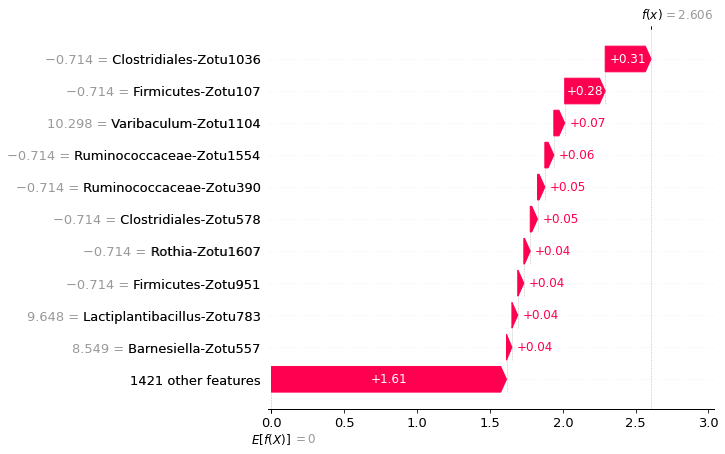

['Proximal Mucosa' 'Proximal Lumen' 'Proximal Mucosa' 'Proximal Lumen']


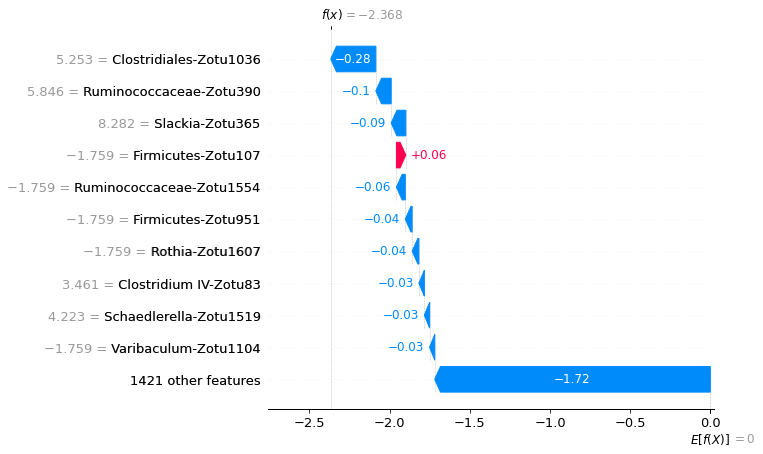

['Proximal Mucosa' 'Proximal Lumen' 'Proximal Mucosa' 'Proximal Lumen']


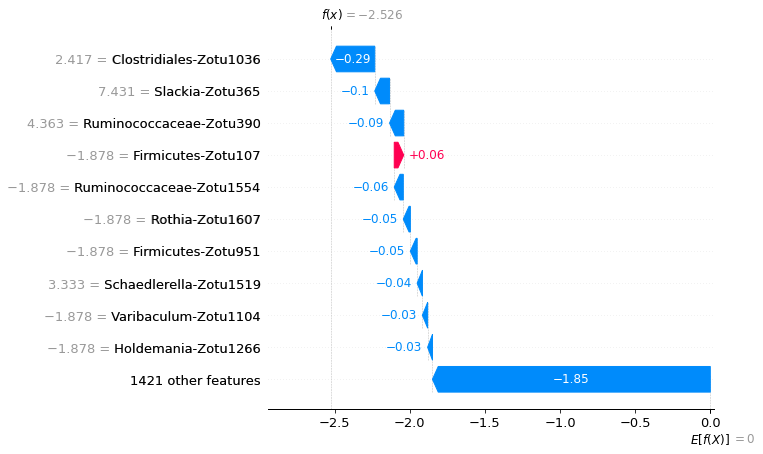

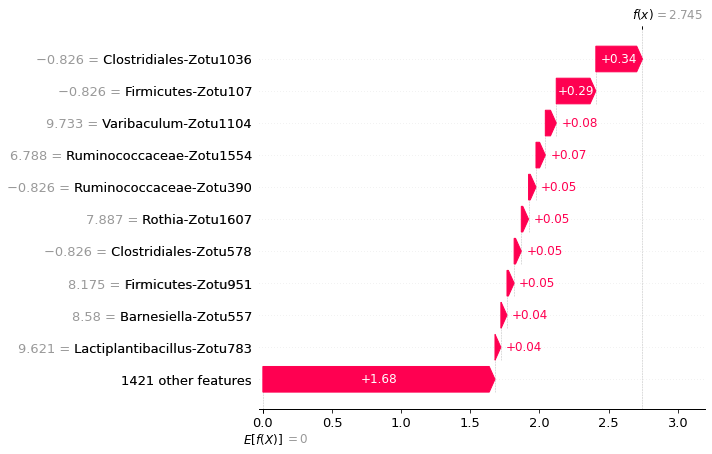

['Proximal Mucosa' 'Proximal Lumen' 'Proximal Mucosa' 'Proximal Lumen']


In [22]:
#Create waterfall plot showing which ASVs are used to make a  prediction for a test data-point
import shap as sh

Explainer = sh.Explainer(clf.l_model, X_trf[x_idx_train], feature_names = np.asarray([x for x in cluster_names]))
sh_vals = Explainer(X_trf[x_idx_train])

t_idx = [0, 1, 2, 3]

sh.plots.waterfall(sh_vals[t_idx[0], :, 0], max_display = 11)
plt.close()

print(y_sel[x_idx_test][t_idx])

sh.plots.waterfall(sh_vals[t_idx[1], :, 0], max_display = 11)
plt.close()

print(y_sel[x_idx_test][t_idx])

sh.plots.waterfall(sh_vals[t_idx[2], :, 0], max_display = 11)
plt.close()

sh.plots.waterfall(sh_vals[t_idx[3], :, 0], max_display = 11)
plt.close()

print(y_sel[x_idx_test][t_idx])

### Pairwise comparisons between different projection methods

In [87]:
#Variables to hold data
PMANOVA_all = []
Pro_stat = []

#### Perform Robust Centered Log Ratio, Centered Log Ratio, and Presence-Absence Transformations for Unsupervised Analysis

In [81]:
#Create the different datasets

y_sel = y[idx]
y_subj_sel = y_subj[idx]

randomized_data_rclr = []
rclr_projs = []
randomized_data_clr = []
randomized_data_pa = []
y_pa = []

for i in range(20):
   
    #Remove all features with zeros in all samples
    X_transform = X_orig[idx].transpose()
    all_zero = X_transform.sum(axis = 1)
    all_zero = np.where(all_zero > 0, True, False)
    
    X_red = X_orig[idx]
    X_red = X_red[:, all_zero]
    
    #Presence-Absence
    X_rare, y_out, y_sel_out, _ = rarefaction(X_red, 15, y_sel, y_sel, seed=0)
    X_trf = np.where(X_rare > 0, 1, 0)
    X_rnd, y_rnd = addcl2(X_rare, y_out)
    randomized_data_pa.append((X_rnd, y_rnd))
    y_pa.append(y_sel_out)

    #CLR
    X_rnd, y_rnd = addcl2(X_red, y_sel)
    X_trf = clr(multiplicative_replacement(closure(X_rnd)))
    randomized_data_clr.append((X_trf, y_rnd))
        
    #rCLR
    X_rnd, y_rnd = addcl2(X_red, y_sel)
    A = rclr(X_rnd.transpose()).transpose()
    M = MatrixCompletion(2, max_iterations = 1000).fit(A)
    X_trf = M.solution
    randomized_data_rclr.append((X_trf, y_rnd))
    
    X_rclr_proj = M.U[0:X_trf.shape[0] // 2]
    rclr_projs.append((X_rclr_proj, y_sel))


#### Robust PCA using rCLR transformed data

In [88]:
method = "rCLR"

d_size = randomized_data_rclr[i][0].shape[0]

rclr_umap = []
rclr_pcoa = []

for i in range(20):
    #PerMANOVA - Full Distance
    D_ijs = pairwise_distances(randomized_data_rclr[i][0][0:d_size//2], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Full)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Full", pseudo_f, pval, R2))
    
    #PerMANOVA - Projection (PCoA)
    D_ijs = pairwise_distances(rclr_projs[i][0], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Projection", pseudo_f, pval, R2))
        
    #PerMANOVA - Projection (UMAP)
    U_trf = UMAP(n_neighbors = 8,
                 n_components = 2,
                 min_dist = 0.001,
                 metric = "euclidean").fit_transform(randomized_data_rclr[i][0][0:d_size//2])
    
    D_ijs = pairwise_distances(U_trf, metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (UMAP)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "UMAP", pseudo_f, pval, R2))
        
    rclr_umap.append(U_trf)
    rclr_pcoa.append(rclr_projs[i][0])
        
#Test concordance between projections (How well each PCoA Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-PCoA", m_test, p_val))
        
#Test concordance between projections (How well each PCoA Projection Compares with a PCoA Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_pcoa[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_pcoa[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != PCoA):", m_test, p_val)
        
        Pro_stat.append((method, "PCoA-PCoA", m_test, p_val))
     
#Test concordance between projections (How well each UMAP Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_umap[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_umap[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (UMAP != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-UMAP", m_test, p_val))


rCLR (Full) 25.62094331465548 0.001 0.9480093904995588
rCLR (Projection) 17.81452210016525 0.001 0.8981200885713478
rCLR (UMAP) 33.08142478586384 0.001 0.9681523215256669
rCLR (Full) 23.713744005790304 0.001 0.9398337058553803
rCLR (Projection) 18.261779429342702 0.001 0.9025690875097788
rCLR (UMAP) 17.816530664561768 0.001 0.8981407186593332
rCLR (Full) 21.88292766180687 0.001 0.9300784221259526
rCLR (Projection) 17.494532274463356 0.001 0.8947548936419654
rCLR (UMAP) 24.125237582749506 0.001 0.9417501260473947
rCLR (Full) 21.4381505704165 0.001 0.927359939352152
rCLR (Projection) 16.73379539370894 0.001 0.8860831262305396
rCLR (UMAP) 8.93154184650244 0.002 0.689045164151955
rCLR (Full) 24.79597755826871 0.001 0.9446869089582168
rCLR (Projection) 17.306012360854638 0.001 0.89269684722292
rCLR (UMAP) 32.401302588553506 0.001 0.9668460787869858
rCLR (Full) 23.250577627914957 0.001 0.9375638842901631
rCLR (Projection) 17.68122905349435 0.001 0.8967374367666265
rCLR (UMAP) 31.899324248202

Test of Null Hypothesis (PCoA != UMAP): 0.2449089705404488 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.25231372683708025 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2780669148610314 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2674616825876145 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2537733050449903 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2703290048469859 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2697250509112938 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2589454328822088 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.25704010862345084 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2689827756943839 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.25765763688400356 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2730678727798621 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.29257122257558604 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2916348085355136 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2908604030711694 0.001
Test of Null Hypothes

Test of Null Hypothesis (PCoA != PCoA): 0.029430544803202105 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.04082393705785124 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.03337339118155479 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.01891858769392882 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.014677545154991894 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.028332654590056475 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.032166547609547784 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.021257388356329194 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.021965728686985934 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.021485542763092457 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.02079537656134404 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.020123389375403086 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.021655475771553623 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.011966710593872939 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.037468241074172834 0.001

Test of Null Hypothesis (PCoA != PCoA): 0.028372412892601614 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.03030099659410805 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.05543660826093036 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.027443965212535306 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.024705604012759567 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.04019076965183256 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.029477780596814693 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.019458612899096034 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.03982082375436112 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.04232298125073537 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.03175265180856449 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.038286616751236 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.04506243571758468 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.026607416091830913 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.024931348204151573 0.001
Test 

Test of Null Hypothesis (UMAP != UMAP): 0.44470872173059606 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.10542656328882638 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.572495331663784 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.09232516360503164 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.048093313076509527 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5233186301985328 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.09022255923362979 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.07985609013812646 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.14001602143590783 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.19609151478886008 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.28334488915712275 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1438417554891866 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.10231585750567485 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.09001832419816287 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.0653963135984284 0.001
Test of Null H

#### Statistics on CLR Transformed data

In [89]:
method = "CLR"

d_size = randomized_data_clr[i][0].shape[0]

rclr_umap = []
rclr_pcoa = []

for i in range(20):
    #PerMANOVA - Full Distance
    D_ijs = pairwise_distances(randomized_data_clr[i][0][0:d_size//2], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Full)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Full", pseudo_f, pval, R2))
    
    #PerMANOVA - Projection (PCoA)
    pcoa_proj = pcoa(pairwise_distances(randomized_data_clr[i][0][0:d_size//2].astype(np.float32), metric = "euclidean"))
    D_ijs = pairwise_distances(pcoa_proj.samples.values[:, [0, 1]], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Projection", pseudo_f, pval, R2))
        
    #PerMANOVA - Projection (UMAP)
    U_trf = UMAP(n_neighbors = 8,
                 n_components = 2,
                 min_dist = 0.001,
                 metric = "euclidean").fit_transform(randomized_data_clr[i][0][0:d_size//2])
    
    D_ijs = pairwise_distances(U_trf, metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (UMAP)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "UMAP", pseudo_f, pval, R2))
        
    rclr_umap.append(U_trf)
    rclr_pcoa.append(pcoa_proj.samples.values[:, [0,1]])
        
#Test concordance between projections (How well each PCoA Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-PCoA", m_test, p_val))
        
#Test concordance between projections (How well each PCoA Projection Compares with a PCoA Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_pcoa[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_pcoa[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != PCoA):", m_test, p_val)
        
        Pro_stat.append((method, "PCoA-PCoA", m_test, p_val))
     
#Test concordance between projections (How well each UMAP Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_umap[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_umap[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (UMAP != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-UMAP", m_test, p_val))

CLR (Full) 2.1670043974862394 0.001 0.11539017760577908
CLR (Projection) 12.528738119646677 0.001 0.8134418068477923
CLR (UMAP) 8.651741555568151 0.004 0.675244517260769
CLR (Full) 2.1670043974862394 0.001 0.11539017760577908
CLR (Projection) 12.528738119646677 0.001 0.8134418068477923
CLR (UMAP) 12.599047846044085 0.002 0.8151343420070646
CLR (Full) 2.1670043974862394 0.001 0.11539017760577908
CLR (Projection) 12.528738119646677 0.001 0.8134418068477923
CLR (UMAP) 8.06691163203659 0.004 0.6438290629549522
CLR (Full) 2.1670043974862394 0.001 0.11539017760577908
CLR (Projection) 12.528738119646677 0.001 0.8134418068477923
CLR (UMAP) 9.132280416352657 0.003 0.6984887896396106
CLR (Full) 2.1670043974862394 0.001 0.11539017760577908
CLR (Projection) 12.528738119646677 0.002 0.8134418068477923
CLR (UMAP) 9.368518825044152 0.002 0.709135907764318
CLR (Full) 2.1670043974862394 0.001 0.11539017760577908
CLR (Projection) 12.528738119646677 0.001 0.8134418068477923
CLR (UMAP) 11.744784690066735 

Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6614187732854999 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3313428550375083 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3313428550375083 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3313428550375083 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3313428550375083 0.001
Test of Null Hypothesis (

Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001


Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1702601178014963 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.40457072994973625 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4168983214266805 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3684010626554063 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.24482221436190693 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3190990259463624 0.001
Test of 

Test of Null Hypothesis (UMAP != UMAP): 0.23456539757565448 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.21854745160585892 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.41002838224971266 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1758318357508371 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.13417378312975567 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.08324135413164581 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4220820782889722 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.20867999941655999 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4130886301627013 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2897650237622159 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4068154601254234 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.24681253226821204 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.33748977468578645 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3416281024535435 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.25016880761077914 0.001
Test of Null Hyp

### Statistics on Jaccard distances

In [90]:
method = "PA"

d_size = randomized_data_pa[i][0].shape[0]

rclr_umap = []
rclr_pcoa = []

for i in range(20):
    #PerMANOVA - Full Distance
    D_ijs = pairwise_distances(randomized_data_pa[i][0][0:d_size//2], metric = "jaccard")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), y_pa[i])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Full)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Full", pseudo_f, pval, R2))
    
    #PerMANOVA - Projection (PCoA)
    pcoa_proj = pcoa(pairwise_distances(randomized_data_pa[i][0][0:d_size//2].astype(np.float32), metric = "jaccard"))
    D_ijs = pairwise_distances(pcoa_proj.samples.values[:, [0, 1]], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), y_pa[i])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Projection", pseudo_f, pval, R2))
        
    #PerMANOVA - Projection (UMAP)
    U_trf = UMAP(n_neighbors = 8,
                 n_components = 2,
                 min_dist = 0.001,
                 metric = "jaccard").fit_transform(randomized_data_pa[i][0][0:d_size//2])
    
    D_ijs = pairwise_distances(U_trf, metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), y_pa[i])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (UMAP)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "UMAP", pseudo_f, pval, R2))
        
    rclr_umap.append(U_trf)
    rclr_pcoa.append(pcoa_proj.samples.values[:, [0,1]])
        
#Test concordance between projections (How well each PCoA Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-PCoA", m_test, p_val))
        
#Test concordance between projections (How well each PCoA Projection Compares with a PCoA Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_pcoa[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_pcoa[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != PCoA):", m_test, p_val)
        
        Pro_stat.append((method, "PCoA-PCoA", m_test, p_val))
     
#Test concordance between projections (How well each UMAP Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_umap[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_umap[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (UMAP != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-UMAP", m_test, p_val))

PA (Full) 1.342882950817869 0.023 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.032 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.9454030858673766 0.405 0.02893096255628791
PA (Full) 1.342882950817869 0.014 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.032 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 1.1342637145519898 0.298 0.04112163221900289
PA (Full) 1.342882950817869 0.016 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.017 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.7067412103111805 0.477 0.0163767738648668
PA (Full) 1.342882950817869 0.017 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.021 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.22903872537821188 0.789 0.0017455722402183182
PA (Full) 1.342882950817869 0.025 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.019 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 1.138132758700704 0.306 0.04139101606753781
PA (Full) 1.342882950817869 0.022 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.017 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.36266222993512864 0.688 0.004364993071325429
PA (Full) 1.342882950817869 0.025 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.023 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 2.8176285251787205 0.085 0.20925760094649815
PA (Full) 1.342882950817869 0.018 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.02 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 1.2220601701227265 0.299 0.04742039876771764
PA (Full) 1.342882950817869 0.023 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.02 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.5529366333333626 0.581 0.01008848262318407
PA (Full) 1.342882950817869 0.021 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.013 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 1.2273859460390688 0.295 0.04781481267777532
PA (Full) 1.342882950817869 0.017 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.028 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.5314083629863585 0.568 0.009325380296603125
PA (Full) 1.342882950817869 0.021 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.024 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 2.259426399665107 0.112 0.14542106657832576
PA (Full) 1.342882950817869 0.021 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.02 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.22637124898904912 0.79 0.0017052186747121834
PA (Full) 1.342882950817869 0.019 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.02 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.303146520859248 0.693 0.003053905528983769
PA (Full) 1.342882950817869 0.024 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (Projection) 4.034500878088287 0.024 0.3517325653358161
PA (UMAP) 1.9317164343057278 0.146 0.11062434942898614
PA (Full) 1.342882950817869 0.017 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.026 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 3.590845577256068 0.03 0.30060428656401106
PA (Full) 1.342882950817869 0.018 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.024 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 1.9859139237783816 0.129 0.1161875755053483
PA (Full) 1.342882950817869 0.007 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.022 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.741678136040835 0.46 0.018006052396827288
PA (Full) 1.342882950817869 0.023 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.021 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 0.8507394588949196 0.408 0.02355693713345297
PA (Full) 1.342882950817869 0.024 0.05670268986466864


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (Projection) 4.034500878088287 0.026 0.3517325653358161


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (UMAP) 2.850235545269708 0.078 0.21309086639612806
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6201839401925017 0.001
Test of Null Hypothesis (PCoA != UMA

Test of Null Hypothesis (PCoA != UMAP): 0.5322325067128593 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5322325067128593 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5322325067128593 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5322325067128593 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5322325067128593 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5322325067128593 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5322325067128593 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5322325067128593 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.48142637492218177 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.48142637492218177 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.48142637492218177 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.48142637492218177 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.48142637492218177 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.48142637492218177 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.48142637492218177 0.001
Test of Null Hypot

Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048

Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (PCoA != PCoA): 5.058048748085431e-32 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4157738433477603 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.17102910395036133 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2044291482370307 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.38895289185476545 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5885229768964787 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6631476701421198 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.333939664287211 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4867826625612608 0.001
Tes

Test of Null Hypothesis (UMAP != UMAP): 0.40264625177764635 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3283755358959847 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4269044057505621 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.27093834477490497 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.314610055626612 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.16547789228468032 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.38526354031505317 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5658985856763501 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3207193447747673 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1303429457874647 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4163435538897045 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6261270810813943 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4328927205417345 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3056871494758673 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6122224339121763 0.001
Test of Null Hypothesi

#### Statistics on LANDMark Dissimilarities of rCLR transformed data

In [91]:
method = "rCLR"

d_size = randomized_data_rclr[i][0].shape[0]

rclr_umap = []
rclr_pcoa = []

for i in range(20):
    X_transformed = LANDMarkClassifier(80, use_nnet = False, n_jobs = 15).fit(randomized_data_rclr[i][0],
                                                                              randomized_data_rclr[i][1]
                                                                             ).proximity(randomized_data_rclr[i][0][0:d_size//2])
    
    S = np.dot(X_transformed, X_transformed.T)
    S = 1 - (S / 80)
    S = np.sqrt(S)
    
    #PerMANOVA - Full Distance
    D_ijs = pairwise_distances(X_transformed, metric = "jaccard")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (LANDMark Proximity)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "LANDMark Proximity", pseudo_f, pval, R2))
    
    #PerMANOVA - Projection (PCoA)
    pcoa_proj = pcoa(pairwise_distances(X_transformed.astype(np.float32), metric = "jaccard"))
    D_ijs = pairwise_distances(pcoa_proj.samples.values[:, [0, 1]], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (LANDMark Proximity PCoA Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "LANDMark Proximity PCoA Projection", pseudo_f, pval, R2))
        
    #PerMANOVA - Projection (UMAP)
    U_trf = UMAP(n_neighbors = 8,
                 n_components = 2,
                 min_dist = 0.001,
                 metric = "jaccard").fit_transform(X_transformed)
    
    D_ijs = pairwise_distances(U_trf, metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (LANDMark Proximity UMAP Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "LANDMark Proximity UMAP Projection", pseudo_f, pval, R2))
        
    rclr_umap.append(U_trf)
    rclr_pcoa.append(pcoa_proj.samples.values[:, [0,1]])
        
#Test concordance between projections (How well each PCoA Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-PCoA (LANDMark)", m_test, p_val))
        
#Test concordance between projections (How well each PCoA Projection Compares with a PCoA Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_pcoa[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_pcoa[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != PCoA):", m_test, p_val)
        
        Pro_stat.append((method, "PCoA-PCoA (LANDMark)", m_test, p_val))
     
#Test concordance between projections (How well each UMAP Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_umap[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_umap[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (UMAP != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-UMAP (LANDMark)", m_test, p_val))

Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.018327068809480374 and the largest is 5.4256088784595615.


rCLR (LANDMark Proximity) 13.077878028972309 0.001 0.8261129083223058
rCLR (LANDMark Proximity PCoA Projection) 22.96367161038562 0.001 0.936094320673367


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 14.39782745410149 0.002 0.8520329655711434


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.015616086381637572 and the largest is 5.39007659909228.


rCLR (LANDMark Proximity) 12.327103003749196 0.001 0.8084673075563608
rCLR (LANDMark Proximity PCoA Projection) 21.166597585770507 0.001 0.9256236539296521


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 29.523753951912852 0.001 0.9603372238264608


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.026594307085061702 and the largest is 4.698258941180483.


rCLR (LANDMark Proximity) 10.657126202015066 0.001 0.7593170040516386
rCLR (LANDMark Proximity PCoA Projection) 19.762062572708622 0.001 0.9155997690377686


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 31.0626783238078 0.001 0.9640320109580797


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.03627270402578408 and the largest is 5.199821517116478.


rCLR (LANDMark Proximity) 13.21789644020493 0.001 0.8291513266401165
rCLR (LANDMark Proximity PCoA Projection) 21.05810655126865 0.001 0.9249130009999637


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 22.474886445924916 0.001 0.9334713827713959


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.016478734369239103 and the largest is 4.659022891762084.


rCLR (LANDMark Proximity) 11.510042271941348 0.001 0.7863261472804628
rCLR (LANDMark Proximity PCoA Projection) 23.020854089464038 0.001 0.9363912332689687


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 21.86751958260122 0.001 0.9299867536662623


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.024269699725264392 and the largest is 4.230777002893901.


rCLR (LANDMark Proximity) 10.921765700767306 0.001 0.7681681561189013
rCLR (LANDMark Proximity PCoA Projection) 20.90229153157592 0.001 0.9238749013767716


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 22.718614295809356 0.001 0.9347986061318796


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.021091701244318188 and the largest is 4.967346014724082.


rCLR (LANDMark Proximity) 12.06762991245098 0.001 0.8017923386996906
rCLR (LANDMark Proximity PCoA Projection) 23.02948607018875 0.001 0.9364358779610432


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 30.10713459355518 0.001 0.961801263679131


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.015396014767860358 and the largest is 4.858551077419451.


rCLR (LANDMark Proximity) 11.343200504853272 0.001 0.7813785509024005
rCLR (LANDMark Proximity PCoA Projection) 22.580051225807782 0.001 0.934048868106552


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 30.330991294397137 0.001 0.9623418763986931


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02732878673214687 and the largest is 4.774013963676988.


rCLR (LANDMark Proximity) 11.564768034783276 0.001 0.7879157451469746
rCLR (LANDMark Proximity PCoA Projection) 21.299500594432846 0.001 0.9264809081733185


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 25.762659711940824 0.001 0.9485504544610404


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02436014283461674 and the largest is 5.441953905606816.


rCLR (LANDMark Proximity) 14.18456964465358 0.001 0.8482306322413857
rCLR (LANDMark Proximity PCoA Projection) 26.487339119181232 0.001 0.951191677801971


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 31.379436745946993 0.001 0.9647290177138071


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.028745777256432396 and the largest is 4.891272418535679.


rCLR (LANDMark Proximity) 13.685225675538584 0.001 0.8387713674457311
rCLR (LANDMark Proximity PCoA Projection) 25.08504801062857 0.001 0.9458857892819699


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 19.531937212222225 0.001 0.9137717469363558


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.023210288694699995 and the largest is 4.936381576621666.


rCLR (LANDMark Proximity) 12.611590171917031 0.001 0.8154340285832223
rCLR (LANDMark Proximity PCoA Projection) 23.484045907107816 0.001 0.938723447244565


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 27.092609289394463 0.001 0.9532473287361785


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0163225995567701 and the largest is 5.544761388281759.


rCLR (LANDMark Proximity) 14.966031233753853 0.001 0.8615289234854491
rCLR (LANDMark Proximity PCoA Projection) 23.785859051828727 0.001 0.9401761901766029


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 17.005883938772197 0.001 0.8892989231284181


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.01986480988377663 and the largest is 4.740334065197703.


rCLR (LANDMark Proximity) 13.487705624226676 0.001 0.8348003998590126
rCLR (LANDMark Proximity PCoA Projection) 25.326670764470222 0.001 0.9468587821684838


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 31.68598154312622 0.001 0.9653846628592619


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.023539237910274017 and the largest is 5.201638418114973.


rCLR (LANDMark Proximity) 12.979463402036124 0.001 0.8239320121096524
rCLR (LANDMark Proximity PCoA Projection) 25.11030450348039 0.001 0.9459887164155862


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 23.153342349777603 0.001 0.937071437035826


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.026161581457590486 and the largest is 4.933736845635491.


rCLR (LANDMark Proximity) 13.466453189220159 0.001 0.8343649951764851
rCLR (LANDMark Proximity PCoA Projection) 23.645661184242858 0.001 0.9395077232116691


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 26.284105901486107 0.001 0.9504714991550758


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.028510171977261075 and the largest is 4.211289533954208.


rCLR (LANDMark Proximity) 11.075947513124971 0.001 0.7731234663492951
rCLR (LANDMark Proximity PCoA Projection) 20.066809104397617 0.001 0.9179350315942094


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 29.63175925260139 0.001 0.960614464952951


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.013990574745975327 and the largest is 4.936358211627541.


rCLR (LANDMark Proximity) 10.906953649901324 0.001 0.7676844380134219
rCLR (LANDMark Proximity PCoA Projection) 21.57599891020666 0.001 0.9282187503396855


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 21.743458762465202 0.001 0.929242223378487


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.028102920732585152 and the largest is 5.068903871897097.


rCLR (LANDMark Proximity) 12.268674482878637 0.001 0.8069915939392014
rCLR (LANDMark Proximity PCoA Projection) 22.121734429417074 0.001 0.9314770118514949


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 23.618143981698807 0.001 0.9393752340143383


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.020791781243927138 and the largest is 4.556210023736193.


rCLR (LANDMark Proximity) 10.391211263534146 0.001 0.7499605346101496
rCLR (LANDMark Proximity PCoA Projection) 20.798229398885567 0.001 0.9231698983560496


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


rCLR (LANDMark Proximity UMAP Projection) 16.319256770660136 0.002 0.8809201465191112
Test of Null Hypothesis (PCoA != UMAP): 0.3330014006744091 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.38005187159730974 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3164123141886761 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.32705194419482 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4215434683954206 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.38606590997750984 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.38545532396395704 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3170018423877392 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3194050760936504 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3245816778530164 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.37666733228686905 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3596155627755087 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3338517854216354 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3370609001233254 0.001
Te

Test of Null Hypothesis (PCoA != UMAP): 0.2608723214635611 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.275476655458557 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.25741023713125144 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.28853028504889966 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2534093789417758 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.28159599031845534 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3339284704769077 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.33418730514209716 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.23929338557647886 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.30320617446982634 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.20911191339470608 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.23902824323687616 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.22982984561479994 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.23156250748784973 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2163812797832332 0.001
Test of Null Hyp

Test of Null Hypothesis (PCoA != PCoA): 0.045076312526487285 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.31227775216350057 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.05073707429583167 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.14319758902889906 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.030839849118046662 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.053806729748931324 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.3963386043309247 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.04269403696080261 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.042230744565860706 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.02922240852540071 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.11762526041145863 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.2960351452041466 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.021301575904978037 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.034917437666171766 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.02290253805383127 0.001
Test o

Test of Null Hypothesis (PCoA != PCoA): 0.2915967899706875 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.36821635556587073 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.030599221973003417 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.27343802234531617 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.20632025927512973 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1501333421358597 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.13396020287969967 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2977119098345704 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.188918221834273 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.16425967469644848 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.24298999400398807 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1836407236041948 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.14521036230474696 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.20197416595246293 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.411793271301978 0.001
Test of Null Hypo

Test of Null Hypothesis (UMAP != UMAP): 0.1287325810595647 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.10890873004294366 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.16905764442827878 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.10177891493598348 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.21408804671896633 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2064806956045009 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.09198449903373555 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.154398522579501 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1707025558158774 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1942055436444915 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.10066724400268223 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1612942279632089 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.14976224556764572 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.05617745033123567 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.22145407126724118 0.001
Test of Null Hypo

#### Statistics on LANDMark Dissimilarities of CLR transformed data

In [92]:
method = "CLR"

d_size = randomized_data_clr[i][0].shape[0]

rclr_umap = []
rclr_pcoa = []

for i in range(20):
    X_transformed = LANDMarkClassifier(80, use_nnet = False, n_jobs = 15).fit(randomized_data_clr[i][0],
                                                                              randomized_data_clr[i][1]
                                                                             ).proximity(randomized_data_clr[i][0][0:d_size//2])
    
    S = np.dot(X_transformed, X_transformed.T)
    S = 1 - (S / 80)
    S = np.sqrt(S)
    
    #PerMANOVA - Full Distance
    D_ijs = pairwise_distances(X_transformed, metric = "jaccard")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (LANDMark Proximity)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "LANDMark Proximity", pseudo_f, pval, R2))
    
    #PerMANOVA - Projection (PCoA)
    pcoa_proj = pcoa(pairwise_distances(X_transformed.astype(np.float32), metric = "jaccard"))
    D_ijs = pairwise_distances(pcoa_proj.samples.values[:, [0, 1]], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (LANDMark Proximity PCoA Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "LANDMark Proximity PCoA Projection", pseudo_f, pval, R2))
        
    #PerMANOVA - Projection (UMAP)
    U_trf = UMAP(n_neighbors = 8,
                 n_components = 2,
                 min_dist = 0.001,
                 metric = "jaccard").fit_transform(X_transformed)
    
    D_ijs = pairwise_distances(U_trf, metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (LANDMark Proximity UMAP Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "LANDMark Proximity UMAP Projection", pseudo_f, pval, R2))
                
    rclr_umap.append(U_trf)
    rclr_pcoa.append(pcoa_proj.samples.values[:, [0,1]])
        
#Test concordance between projections (How well each PCoA Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-PCoA (LANDMark)", m_test, p_val))
        
#Test concordance between projections (How well each PCoA Projection Compares with a PCoA Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_pcoa[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_pcoa[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != PCoA):", m_test, p_val)
        
        Pro_stat.append((method, "PCoA-PCoA (LANDMark)", m_test, p_val))
     
#Test concordance between projections (How well each UMAP Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_umap[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_umap[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (UMAP != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-UMAP (LANDMark)", m_test, p_val))

Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.024520212711740316 and the largest is 1.4815703497234929.


CLR (LANDMark Proximity) 3.940835856343193 0.001 0.3013803767548462
CLR (LANDMark Proximity PCoA Projection) 14.105795764080387 0.001 0.846791217042375


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 17.72049580469679 0.001 0.8971475506128753


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.021993181674008665 and the largest is 1.257351332367561.


CLR (LANDMark Proximity) 4.0968439353368495 0.001 0.3179768266941343
CLR (LANDMark Proximity PCoA Projection) 17.244802241776092 0.001 0.8920161557948627


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 21.879623150435613 0.001 0.9300587771356201


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.015246738830766585 and the largest is 1.5408794702274948.


CLR (LANDMark Proximity) 4.165937925824621 0.001 0.32527459808033465
CLR (LANDMark Proximity PCoA Projection) 17.704637426720613 0.001 0.8969822042492456


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 28.171925866005587 0.001 0.9566085956730181


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.021034556975492547 and the largest is 1.5398971997439146.


CLR (LANDMark Proximity) 4.209690506237245 0.001 0.32987716436335746
CLR (LANDMark Proximity PCoA Projection) 15.51286534337102 0.001 0.8698712044860624


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 11.924462440552539 0.001 0.7979716403151499


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02329249730799986 and the largest is 1.66908432822601.


CLR (LANDMark Proximity) 4.398280887814157 0.001 0.3495332648084236
CLR (LANDMark Proximity PCoA Projection) 14.893259229484203 0.001 0.8603618330044421


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 20.728539273813283 0.001 0.9226924236748408


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02743715965299385 and the largest is 1.1487105264430313.


CLR (LANDMark Proximity) 3.5189699807583246 0.001 0.25593930522793884
CLR (LANDMark Proximity PCoA Projection) 13.633646378696934 0.001 0.8377474394664292


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 17.003733193892003 0.001 0.8892740179575189


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.024015736295644952 and the largest is 1.5155523138172218.


CLR (LANDMark Proximity) 4.382798320287285 0.001 0.3479314706375819
CLR (LANDMark Proximity PCoA Projection) 18.012809484085032 0.001 0.9001279764298948


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 22.736659864272603 0.001 0.9348953272678486


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02213153032636654 and the largest is 1.4860212593455644.


CLR (LANDMark Proximity) 4.264825912190551 0.001 0.33565534169495337
CLR (LANDMark Proximity PCoA Projection) 15.845982322133976 0.001 0.87460603469421


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 22.97748525435693 0.001 0.9361662320530494


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.018058930257086093 and the largest is 1.4526288394439244.


CLR (LANDMark Proximity) 4.264942684861438 0.001 0.3356675527973898
CLR (LANDMark Proximity PCoA Projection) 16.812109425765104 0.001 0.8870223245074943


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 32.80569505347626 0.001 0.9676321175216819


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.021938126552403386 and the largest is 1.5089289835994764.


CLR (LANDMark Proximity) 4.3540683993202824 0.001 0.34495327542622056
CLR (LANDMark Proximity PCoA Projection) 15.236172963051457 0.001 0.8657422606405731


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 15.816516279725088 0.001 0.8741972154012548


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.019767583168129453 and the largest is 1.5309320701130815.


CLR (LANDMark Proximity) 4.4256547813677765 0.001 0.3523598058288846
CLR (LANDMark Proximity PCoA Projection) 15.166849797219777 0.001 0.8646786114169723


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 22.592489817849717 0.001 0.9341166854757003


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02275980979726837 and the largest is 1.4041124875254034.


CLR (LANDMark Proximity) 4.414393416127719 0.001 0.3511978509861553
CLR (LANDMark Proximity PCoA Projection) 16.56330494511886 0.001 0.8839993433131287


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 35.17037107598229 0.001 0.971719345967359


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.020805088487983465 and the largest is 1.5769798512659763.


CLR (LANDMark Proximity) 4.3136060563544865 0.001 0.34074624152672905
CLR (LANDMark Proximity PCoA Projection) 14.761195487131616 0.001 0.858207925055575


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 23.405512590776496 0.001 0.9383369495474225


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.028891533343096715 and the largest is 1.2441313192589176.


CLR (LANDMark Proximity) 4.211429128539356 0.001 0.3300597485125667
CLR (LANDMark Proximity PCoA Projection) 14.638152647707123 0.001 0.8561585207539688


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 19.429853303032125 0.001 0.9129423735241156


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.027994381184863765 and the largest is 1.2763820490778002.


CLR (LANDMark Proximity) 3.779863093523731 0.001 0.284114409338008
CLR (LANDMark Proximity PCoA Projection) 13.350155480231694 0.001 0.8319536818890222


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 21.738510924259455 0.001 0.929212290103308


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.030946540286421142 and the largest is 1.3395223193160775.


CLR (LANDMark Proximity) 4.5173420571222795 0.001 0.3617743157490415
CLR (LANDMark Proximity PCoA Projection) 18.08543123540306 0.001 0.900849068800686


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 30.252080586838375 0.001 0.9621526074505483


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.026421147531102192 and the largest is 1.6737589938901114.


CLR (LANDMark Proximity) 5.3174355556533035 0.001 0.4399077045310307
CLR (LANDMark Proximity PCoA Projection) 16.957149338822102 0.001 0.8887326041123345


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 35.20402161149658 0.001 0.9717718600580664


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02868427986439366 and the largest is 1.4910238052049483.


CLR (LANDMark Proximity) 4.714019976256472 0.001 0.3816768629542683
CLR (LANDMark Proximity PCoA Projection) 20.38746134898773 0.001 0.9202920111482308


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 18.380339390936093 0.002 0.9037013138643213


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.02255619163896791 and the largest is 1.2036974499388478.


CLR (LANDMark Proximity) 3.7190014298259064 0.001 0.27755773530451355
CLR (LANDMark Proximity PCoA Projection) 17.09695451514977 0.001 0.8903461525433148


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 26.58866914264006 0.001 0.9515449963241077


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.012657347388436628 and the largest is 1.3332006446733264.


CLR (LANDMark Proximity) 3.4339790275838227 0.001 0.2467391961537555
CLR (LANDMark Proximity PCoA Projection) 13.13457698744439 0.001 0.8273522995577447


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


CLR (LANDMark Proximity UMAP Projection) 10.233913527143294 0.001 0.7441964318211225
Test of Null Hypothesis (PCoA != UMAP): 0.4443497953307799 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.48663664206216073 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5238591437575055 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5322963248827473 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6549498814828132 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.45518867403438534 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5120331833501712 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.46480047759181015 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.49788471228873704 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5520432222043711 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4938768259463552 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5319884805422851 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5472550058861958 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5703480810936957 0.001
T

Test of Null Hypothesis (PCoA != UMAP): 0.38714461627261865 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4319736214943944 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3583390639460882 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.43397481874473454 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.39351065870541235 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.43198572718460465 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.38153317548463284 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.43545371495498164 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4190893824145876 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.47450288067133745 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.20356316522104373 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.1607479455411584 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.24512239086491566 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.22992790394415757 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.25583890183588026 0.001
Test of Null H

Test of Null Hypothesis (PCoA != PCoA): 0.13655119553344164 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.12151219672620919 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.14095664000962682 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.13452337227414335 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.1719135014515242 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.10671412813163202 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.17114675299815488 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.17959006178738374 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.14240099528761774 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.24578761498376406 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.1741157637736628 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.12921272342812107 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.11380711315657746 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.12218960758496103 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.09718131192332011 0.001
Test of Null

Test of Null Hypothesis (PCoA != PCoA): 0.2018712163523906 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.15382587580191606 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.1523134723357393 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4129655461022053 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.492182324365169 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4962710422609454 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5520620374845763 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6475346919302408 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4467017150248192 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5465839905902486 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4786087341509002 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5513584201952604 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6260376749332238 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3413015804827967 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5249796074503791 0.001
Test of Null Hypothesis (

Test of Null Hypothesis (UMAP != UMAP): 0.354530896727493 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3294901623796642 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.29103565010720395 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.20963696178850016 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.35561181631962197 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.22400270083438137 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.27253486530155313 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.21962109178484338 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4145502680712861 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.39105152404496124 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.44839520991821985 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.23141872780890804 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2524208933972319 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.20473748111622322 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4758735366777425 0.001
Test of Null Hyp

#### Statistics on LANDMark Dissimilarities of PA transformed data

In [93]:
method = "PA"

rclr_umap = []
rclr_pcoa = []

for i in range(20):
    X_transformed = LANDMarkClassifier(80, use_nnet = False, n_jobs = 15).fit(randomized_data_pa[i][0],
                                                                              randomized_data_pa[i][1]
                                                                             ).proximity(randomized_data_pa[i][0][0:randomized_data_pa[i][0].shape[0]//2])
    
    S = np.dot(X_transformed, X_transformed.T)
    S = 1 - (S / 80)
    S = np.sqrt(S)
    
    #PerMANOVA - Full Distance
    D_ijs = pairwise_distances(X_transformed, metric = "jaccard")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), y_pa[i])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (LANDMark Proximity)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "LANDMark Proximity", pseudo_f, pval, R2))
    
    #PerMANOVA - Projection (PCoA)
    pcoa_proj = pcoa(pairwise_distances(X_transformed.astype(np.float32), metric = "jaccard"))
    D_ijs = pairwise_distances(pcoa_proj.samples.values[:, [0, 1]], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), y_pa[i])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (LANDMark Proximity PCoA Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "LANDMark Proximity PCoA Projection", pseudo_f, pval, R2))
        
    #PerMANOVA - Projection (UMAP)
    U_trf = UMAP(n_neighbors = 8,
                 n_components = 2,
                 min_dist = 0.001,
                 metric = "jaccard").fit_transform(X_transformed)
    
    D_ijs = pairwise_distances(U_trf, metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), y_pa[i])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (LANDMark Proximity UMAP Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "LANDMark Proximity UMAP Projection", pseudo_f, pval, R2))
        
    rclr_umap.append(U_trf)
    rclr_pcoa.append(pcoa_proj.samples.values[:, [0,1]])
        
#Test concordance between projections (How well each PCoA Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-PCoA (LANDMark)", m_test, p_val))
        
#Test concordance between projections (How well each PCoA Projection Compares with a PCoA Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_pcoa[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_pcoa[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != PCoA):", m_test, p_val)
        
        Pro_stat.append((method, "PCoA-PCoA (LANDMark)", m_test, p_val))
     
#Test concordance between projections (How well each UMAP Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_umap[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_umap[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (UMAP != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-UMAP (LANDMark)", m_test, p_val))

Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (LANDMark Proximity) 1.1267908208543107 0.262 0.04060350043074523
PA (LANDMark Proximity PCoA Projection) 1.252025644835111 0.295 0.04965755374732295


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 1.6910384082179344 0.201 0.08702509919970947


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0047961517836926 and the largest is 1.3564723401440149.


PA (LANDMark Proximity) 1.0863835731079075 0.318 0.037851847007842276
PA (LANDMark Proximity PCoA Projection) 1.4912630163981768 0.232 0.06901299262427663


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 2.063739027064749 0.147 0.12431817735924722


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.003694742044786658 and the largest is 1.4179978426081807.


PA (LANDMark Proximity) 0.8099437913464652 0.729 0.021399032937217122
PA (LANDMark Proximity PCoA Projection) 0.4626673215703421 0.645 0.007084815579463166


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.5985197792976644 0.487 0.011799962457662683


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (LANDMark Proximity) 1.080941079284947 0.33 0.037487723356514846
PA (LANDMark Proximity PCoA Projection) 0.9454229527731391 0.411 0.028932143312494385


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.3229553109128913 0.726 0.0034646257307620054


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.001569495326164116 and the largest is 1.349786755927581.


PA (LANDMark Proximity) 1.0029264807526688 0.423 0.03244101199891247
PA (LANDMark Proximity PCoA Projection) 1.4537402408790867 0.232 0.06580939031846988


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.6516000363010102 0.457 0.013955248385412511


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.004928954527607681 and the largest is 1.3660868064822258.


PA (LANDMark Proximity) 1.0662879288930087 0.339 0.03651511207504077
PA (LANDMark Proximity PCoA Projection) 1.1409489324791229 0.326 0.04158757465309615


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.6480723044358642 0.446 0.013806631931935098


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.003978454296777327 and the largest is 1.646205141780448.


PA (LANDMark Proximity) 0.92755868111179 0.519 0.02787929125029409
PA (LANDMark Proximity PCoA Projection) 0.8198133791890455 0.468 0.021912229964083152


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.5684295171496422 0.594 0.01065563833722849


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.007402285034388325 and the largest is 1.4792906644480424.


PA (LANDMark Proximity) 0.6452822634296748 0.92 0.01368963280834834
PA (LANDMark Proximity PCoA Projection) 0.8119608447105806 0.464 0.02150345358582506


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.9417589760753667 0.39 0.02871475229824383


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (LANDMark Proximity) 1.0121116876432268 0.396 0.033018239081407996
PA (LANDMark Proximity PCoA Projection) 1.2371995718174336 0.307 0.04854521426208713


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 1.1564958677523989 0.316 0.04267996588201817


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.0072993191701653005 and the largest is 1.6317314794894608.


PA (LANDMark Proximity) 0.9244796781826411 0.51 0.02769962790923164
PA (LANDMark Proximity PCoA Projection) 0.7896869191165528 0.459 0.020363553587597116


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.6225488059924391 0.494 0.012754131176100802


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (LANDMark Proximity) 1.0024587223681638 0.406 0.032411739070230094
PA (LANDMark Proximity PCoA Projection) 0.8981697673500946 0.383 0.026186144478757667


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.3438363514068185 0.632 0.00392531242082772


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (LANDMark Proximity) 0.8860376053137996 0.581 0.025501414346982165
PA (LANDMark Proximity PCoA Projection) 1.050122533707888 0.354 0.03545529175742046


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 2.1529893388818815 0.156 0.13383324669780916


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.002258973309599171 and the largest is 1.283452209277492.


PA (LANDMark Proximity) 0.9578928928832092 0.492 0.029677595192516226
PA (LANDMark Proximity PCoA Projection) 1.043533360917696 0.348 0.03502728330763827


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.20266291014782412 0.784 0.001367203367467873


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.007492019519276313 and the largest is 1.2557498666777018.


PA (LANDMark Proximity) 0.9886074163564736 0.448 0.03155030347333476
PA (LANDMark Proximity PCoA Projection) 1.159104289676425 0.32 0.04286444650386301


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.6393396910364814 0.489 0.013442024749166892


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.002096386079913575 and the largest is 1.6188824431608138.


PA (LANDMark Proximity) 0.7045206948316757 0.858 0.016275699192125792
PA (LANDMark Proximity PCoA Projection) 0.6766167620930488 0.493 0.015030963785531037


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.8177932563039508 0.436 0.021806726037289836


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (LANDMark Proximity) 0.8064281772248983 0.772 0.02121760128843886
PA (LANDMark Proximity PCoA Projection) 0.9456315499285821 0.383 0.02894454225897447


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.8852031723706574 0.392 0.02545462671491694


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00606211991396827 and the largest is 1.3499358373189818.


PA (LANDMark Proximity) 0.9130355098293369 0.586 0.027036509756697136
PA (LANDMark Proximity PCoA Projection) 0.6178403449489085 0.521 0.012564351451065825


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.14278917376983116 0.811 0.0006791633618379311


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.00821673173233969 and the largest is 1.3682401009457472.


PA (LANDMark Proximity) 0.8360040994476021 0.686 0.02276637890319444
PA (LANDMark Proximity PCoA Projection) 0.7805389120293711 0.451 0.019903825558023502


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.5825210701588167 0.547 0.01118451819018118


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard
The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.010746324416219907 and the largest is 1.4143757440030358.


PA (LANDMark Proximity) 0.9886392729506565 0.443 0.03155227268408123
PA (LANDMark Proximity PCoA Projection) 1.264050921930333 0.296 0.050567554783365054


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.4201539486500131 0.595 0.005849888785218638


Data was converted to boolean for metric jaccard
Data was converted to boolean for metric jaccard


PA (LANDMark Proximity) 0.803625481700481 0.771 0.021073478962999048
PA (LANDMark Proximity PCoA Projection) 0.48752948126163087 0.608 0.007860555301695826


gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable


PA (LANDMark Proximity UMAP Projection) 0.15799570501060814 0.822 0.0008313962984325407
Test of Null Hypothesis (PCoA != UMAP): 0.32287284289139234 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3431147382570427 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.46766722433711777 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3068850832237761 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.457530305654718 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.37672054400058763 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4491525433723139 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4794151352735177 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3528251887224374 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5523272551195225 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.35108074973222436 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.38631130322442503 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.43206408435114685 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3323248027729592 0.0

Test of Null Hypothesis (PCoA != UMAP): 0.42162436830789246 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4367572906800568 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3667956819157222 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.46225611667699684 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.49846763117112786 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.5030528714532572 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4080335470582671 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.42566019348490713 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4023976296074412 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2967983889065531 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.23155830364283286 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.240053881933924 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.22557250643946034 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.22692361048272672 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.29436441328736734 0.001
Test of Null Hypot

Test of Null Hypothesis (PCoA != PCoA): 0.21721385285201422 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.2261262849657272 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.27489827422239427 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.25628923935371306 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.7038385181032479 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.1891596283757186 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.20690179631278685 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.1264134545768096 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.3196508909311415 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.17500965562110943 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.29077208975887486 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.29136137528718437 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.16151785359871912 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.5371457668728096 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.15084048943778683 0.001
Test of Null Hyp

Test of Null Hypothesis (PCoA != PCoA): 0.13880262680158112 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.1754597983577277 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.42452391281553786 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5128556386338559 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5986920594357921 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3465137281392193 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.38371102200014023 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5232815342039558 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6690908222428424 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5916659427366252 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2663375807067169 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.53843256491872 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6621349313798915 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3186449489211593 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.39443982247649423 0.001
Test of Null Hypothesis

Test of Null Hypothesis (UMAP != UMAP): 0.3965247473761849 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.42568880572989143 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.7080281972435792 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5800856151009869 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3678836936839525 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.589373390544992 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6373608765283689 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.47245112687933205 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.31344609981346705 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2772501893218244 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2868125127191694 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3227732533962602 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.455894143854107 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3080613842929144 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.10378302130731276 0.001
Test of Null Hypothesis

#### Statistics on ET Dissimilarities (rCLR)

In [94]:
method = "rCLR"

rclr_umap = []
rclr_pcoa = []

for i in range(20):
    X_transformed = ExtraTreesClassifier(128).fit(randomized_data_rclr[i][0],
                                                  randomized_data_rclr[i][1]
                                                  ).apply(randomized_data_rclr[i][0][0:randomized_data_rclr[i][0].shape[0]//2])
    
    S = OneHotEncoder(sparse = False).fit_transform(X_transformed)
    S = np.dot(S, S.T)
    S = 1 - (S / 128)
    S = np.sqrt(S)

    #PerMANOVA - Full Distance
    pmanova = permanova(DistanceMatrix(S.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Extra Trees Proximity)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Extra Trees Proximity", pseudo_f, pval, R2))
    
    #PerMANOVA - Projection (PCoA)
    pcoa_proj = pcoa(S.astype(np.float32))
    D_ijs = pairwise_distances(pcoa_proj.samples.values[:, [0, 1]], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Extra Trees Proximity PCoA Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Extra Trees Proximity PCoA Projection", pseudo_f, pval, R2))
        
    #PerMANOVA - Projection (UMAP)
    U_trf = UMAP(n_neighbors = 8,
                 n_components = 2,
                 min_dist = 0.001,
                 metric = "precomputed").fit_transform(S)
    
    D_ijs = pairwise_distances(U_trf, metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Extra Trees Proximity UMAP Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Extra Trees Proximity UMAP Projection", pseudo_f, pval, R2))
        
    rclr_umap.append(U_trf)
    rclr_pcoa.append(pcoa_proj.samples.values[:, [0,1]])
        
#Test concordance between projections (How well each PCoA Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-PCoA (Extra Trees)", m_test, p_val))
        
#Test concordance between projections (How well each PCoA Projection Compares with a PCoA Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_pcoa[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_pcoa[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != PCoA):", m_test, p_val)
        
        Pro_stat.append((method, "PCoA-PCoA (Extra Trees)", m_test, p_val))
     
#Test concordance between projections (How well each UMAP Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_umap[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_umap[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (UMAP != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-UMAP (Extra Trees)", m_test, p_val))

rCLR (Extra Trees Proximity) 11.80330660415012 0.001 0.794658903297055
rCLR (Extra Trees Proximity PCoA Projection) 23.01184226196166 0.001 0.9363445749399126


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.4159817257896066e-08 and the largest is 6.503134250640869.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 4.862606162264456 0.028 0.39642825039129614
rCLR (Extra Trees Proximity) 10.530147314395535 0.001 0.754908639495306
rCLR (Extra Trees Proximity PCoA Projection) 20.954171357495607 0.001 0.9242228576146078


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.840641392751422e-07 and the largest is 6.343544006347656.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 29.60187658536082 0.001 0.9605380460878458
rCLR (Extra Trees Proximity) 10.735921459702931 0.001 0.7619992217517388
rCLR (Extra Trees Proximity PCoA Projection) 22.22427665548386 0.001 0.9320650216140967


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -9.507857612334192e-08 and the largest is 6.255208492279053.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 24.536830362714873 0.001 0.9435786239712024
rCLR (Extra Trees Proximity) 12.062469938290947 0.001 0.8016563687796436
rCLR (Extra Trees Proximity PCoA Projection) 21.089297931117017 0.001 0.9251183266516714


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -8.841546446092252e-07 and the largest is 7.056915283203125.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 35.71478712755612 0.001 0.9725514778262261
rCLR (Extra Trees Proximity) 12.071938282095942 0.001 0.8019057698188988
rCLR (Extra Trees Proximity PCoA Projection) 23.566085489550336 0.001 0.9391234162875339


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -8.924388339437428e-08 and the largest is 6.506161689758301.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 25.28932379426677 0.001 0.9467100800279727
rCLR (Extra Trees Proximity) 12.121765858536689 0.001 0.8032111647147747
rCLR (Extra Trees Proximity PCoA Projection) 22.16594912391891 0.001 0.9317314627473089


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.089576345402747e-07 and the largest is 6.866952419281006.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 21.634393627502018 0.001 0.928578087195221
rCLR (Extra Trees Proximity) 10.294570335961641 0.001 0.7464399078423638
rCLR (Extra Trees Proximity PCoA Projection) 19.563871247403373 0.001 0.9140288361705338


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.1920928955078125e-07 and the largest is 6.5366082191467285.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 25.391331774772564 0.001 0.9471147985717987
rCLR (Extra Trees Proximity) 11.357023092736718 0.001 0.7817943425577835
rCLR (Extra Trees Proximity PCoA Projection) 22.272060140345594 0.001 0.9323365076080218


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -8.335607049048122e-07 and the largest is 6.527052402496338.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 24.183358026182137 0.001 0.9420135603133586
rCLR (Extra Trees Proximity) 13.056189491557765 0.001 0.8256355328459017
rCLR (Extra Trees Proximity PCoA Projection) 25.03027052375482 0.001 0.9456615619358129


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -7.571579772047698e-07 and the largest is 6.6905083656311035.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 31.999234418427463 0.001 0.966036165930599
rCLR (Extra Trees Proximity) 12.627035788163848 0.001 0.8158021614641338
rCLR (Extra Trees Proximity PCoA Projection) 23.445974486110092 0.001 0.9385365259595063


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.3464887160807848e-07 and the largest is 6.815013408660889.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 34.38396258288231 0.001 0.9704495820994069
rCLR (Extra Trees Proximity) 11.420408993012417 0.001 0.7836873090611395
rCLR (Extra Trees Proximity PCoA Projection) 21.940405286234277 0.002 0.9304188339498569


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.0766015634544601e-07 and the largest is 6.537097454071045.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 26.496819122477486 0.001 0.9512248935571951
rCLR (Extra Trees Proximity) 12.038842956965814 0.001 0.8010321344640468
rCLR (Extra Trees Proximity PCoA Projection) 21.983726230629724 0.001 0.9306738031236814


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.4988108887337148e-07 and the largest is 6.837311267852783.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 16.769835749373343 0.002 0.8865167352680399
rCLR (Extra Trees Proximity) 11.640694092344194 0.001 0.7900945121605354
rCLR (Extra Trees Proximity PCoA Projection) 21.603105098924047 0.001 0.9283858783594838


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.036002453882247e-07 and the largest is 6.639106750488281.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 34.98780926909844 0.001 0.9714318997811798
rCLR (Extra Trees Proximity) 12.522712820653112 0.001 0.8132957649450097
rCLR (Extra Trees Proximity PCoA Projection) 23.396497554666574 0.001 0.9382923537984191


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.252501355495042e-07 and the largest is 6.664899826049805.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 25.497438624757283 0.001 0.9475309964460299
rCLR (Extra Trees Proximity) 10.527858863794114 0.001 0.7548282026918351
rCLR (Extra Trees Proximity PCoA Projection) 19.740168505344364 0.001 0.9154282887008699


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.3032006052071665e-07 and the largest is 6.450443267822266.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 18.534152255935226 0.001 0.9051420392179956
rCLR (Extra Trees Proximity) 12.59980053994683 0.001 0.815152345914647
rCLR (Extra Trees Proximity PCoA Projection) 23.462758141538373 0.001 0.9386190325397195


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.2022894679830642e-07 and the largest is 6.823697090148926.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 26.90515433235697 0.001 0.9526245555157781
rCLR (Extra Trees Proximity) 10.232942492586439 0.001 0.7441603026623113
rCLR (Extra Trees Proximity PCoA Projection) 18.63738310430892 0.001 0.906091541453635


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -7.222316611432689e-08 and the largest is 6.704743385314941.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 26.113409575216945 0.001 0.9498544497296147
rCLR (Extra Trees Proximity) 11.31392081764049 0.001 0.780494235149308
rCLR (Extra Trees Proximity PCoA Projection) 22.456597543745257 0.001 0.9333701985218231


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -8.900487813434665e-08 and the largest is 6.312662124633789.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 17.19842564932228 0.001 0.8914962751950908
rCLR (Extra Trees Proximity) 12.066055667867925 0.001 0.8017508695542914
rCLR (Extra Trees Proximity PCoA Projection) 21.729397042190726 0.001 0.9291571047525862


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.68787834001705e-07 and the largest is 6.907844066619873.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 31.55427015498893 0.001 0.9651051872874044
rCLR (Extra Trees Proximity) 10.377215826462358 0.001 0.7494547305161083
rCLR (Extra Trees Proximity PCoA Projection) 20.03480624747143 0.001 0.917694242874745


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.426078869026242e-08 and the largest is 6.485424518585205.
using precomputed metric; inverse_transform will be unavailable


rCLR (Extra Trees Proximity UMAP Projection) 31.769999337023833 0.001 0.9655612088256751
Test of Null Hypothesis (PCoA != UMAP): 0.6647403315914269 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6796774051123513 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6217843081118376 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6779124985955834 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6339688943661128 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6474704968191205 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6522645934735096 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6611250082499224 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6537096697300356 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6508386231159258 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6325522002153278 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6513921398769722 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6624698212890282 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6630559327842896 0.001
T

Test of Null Hypothesis (PCoA != UMAP): 0.3304776437755948 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.30802366833947803 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3208791179178761 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.28344328808794234 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3432863990896128 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.27056576412095074 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3080529117505129 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3744449161592306 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2692205454458311 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.33419213686275573 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3131770138746265 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.28988116040278 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3023700946091544 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.27361481423181944 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.31617604178154596 0.001
Test of Null Hypothes

Test of Null Hypothesis (PCoA != PCoA): 0.04174231310295049 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.04886689490620111 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.053253364437667754 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.05714296774973131 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.04368229368104305 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.032695955193866394 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.13284219426838217 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.021173809472419775 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.04174209076915709 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.07838033153738841 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.11234188552156572 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.08806718442657961 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.053164211409815886 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.03540211564587372 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.08116226529117421 0.001
Test o

Test of Null Hypothesis (PCoA != PCoA): 0.031182471273791645 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.031111124953743474 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0707351966635079 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.06492245347752211 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.012197608093457027 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6038816002783524 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4525518289682662 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5843883343879225 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5812504188028961 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6211600008159343 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.515666795572954 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.44852650858595466 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5409457016698673 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.5407174251378503 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6101009212248516 0.001
Test of Null Hypot

Test of Null Hypothesis (UMAP != UMAP): 0.2202828652307635 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.11205760665718519 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.09728378640208017 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.008563079230798206 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.11064794294339071 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2712102427175895 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.03364683469063142 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1925742277564502 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.24500342037115888 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.1326577277170826 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.09661908793069209 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2566777908091328 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.0072330225771867285 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.014903023934672103 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.10344312938472613 0.001
Test of Nul

#### Statistics on ET Dissimilarities (CLR)

In [95]:
method = "CLR"

rclr_umap = []
rclr_pcoa = []

for i in range(20):
    X_transformed = ExtraTreesClassifier(128).fit(randomized_data_clr[i][0],
                                                  randomized_data_clr[i][1]
                                                  ).apply(randomized_data_clr[i][0][0:randomized_data_clr[i][0].shape[0]//2])
    
    S = OneHotEncoder(sparse = False).fit_transform(X_transformed)
    S = np.dot(S, S.T)
    S = 1 - (S / 128)
    S = np.sqrt(S)

    #PerMANOVA - Full Distance
    pmanova = permanova(DistanceMatrix(S.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Extra Trees Proximity)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Extra Trees Proximity", pseudo_f, pval, R2))
    
    #PerMANOVA - Projection (PCoA)
    pcoa_proj = pcoa(S.astype(np.float32))
    D_ijs = pairwise_distances(pcoa_proj.samples.values[:, [0, 1]], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Extra Trees Proximity PCoA Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Extra Trees Proximity PCoA Projection", pseudo_f, pval, R2))
        
    #PerMANOVA - Projection (UMAP)
    U_trf = UMAP(n_neighbors = 8,
                 n_components = 2,
                 min_dist = 0.001,
                 metric = "precomputed").fit_transform(S)
    
    D_ijs = pairwise_distances(U_trf, metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), rclr_projs[i][1])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Extra Trees Proximity UMAP Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Extra Trees Proximity UMAP Projection", pseudo_f, pval, R2))
        
    rclr_umap.append(U_trf)
    rclr_pcoa.append(pcoa_proj.samples.values[:, [0,1]])
        
#Test concordance between projections (How well each PCoA Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-PCoA (Extra Trees)", m_test, p_val))
        
#Test concordance between projections (How well each PCoA Projection Compares with a PCoA Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_pcoa[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_pcoa[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != PCoA):", m_test, p_val)
        
        Pro_stat.append((method, "PCoA-PCoA (Extra Trees)", m_test, p_val))
     
#Test concordance between projections (How well each UMAP Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_umap[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_umap[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (UMAP != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-UMAP (Extra Trees)", m_test, p_val))

CLR (Extra Trees Proximity) 7.565208516939921 0.001 0.6138680570337541
CLR (Extra Trees Proximity PCoA Projection) 16.149767485919458 0.001 0.8787123250807423


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.916388883837499e-07 and the largest is 5.931715488433838.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 13.34653571024702 0.001 0.8318778433661428
CLR (Extra Trees Proximity) 7.13581459460267 0.002 0.5858253318477302
CLR (Extra Trees Proximity PCoA Projection) 15.843646329307036 0.001 0.8745736938447624


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.3335754778818227e-07 and the largest is 5.717630863189697.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 14.756883890771816 0.001 0.8581368126511228
CLR (Extra Trees Proximity) 7.185611839658542 0.001 0.5891959329622201
CLR (Extra Trees Proximity PCoA Projection) 16.19894593356151 0.001 0.8793589332199842


using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 17.009593557307365 0.001 0.8893418608042061
CLR (Extra Trees Proximity) 6.7677135761209986 0.001 0.5599126756885837
CLR (Extra Trees Proximity PCoA Projection) 15.210385876721473 0.001 0.8653479938966329


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.1243382402881252e-07 and the largest is 5.573144435882568.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 17.66744778320514 0.001 0.8965929417076948
CLR (Extra Trees Proximity) 7.111913950060475 0.001 0.5841963186329999
CLR (Extra Trees Proximity PCoA Projection) 15.661729876001852 0.001 0.8720181029921656


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.9649446869607345e-07 and the largest is 5.709470748901367.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 6.633315055314459 0.018 0.5500048859516702
CLR (Extra Trees Proximity) 6.992763729266818 0.001 0.5759654611983426
CLR (Extra Trees Proximity PCoA Projection) 15.882223780077704 0.001 0.8751062603744613


using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 15.613612042526553 0.001 0.871329716354007
CLR (Extra Trees Proximity) 7.523082203142287 0.001 0.6112175228230188
CLR (Extra Trees Proximity PCoA Projection) 16.52632589319121 0.001 0.883540164528977


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.5252196539659053e-07 and the largest is 5.813323497772217.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 11.759373795011264 0.001 0.7934392543777498
CLR (Extra Trees Proximity) 6.742400158263593 0.001 0.5580650905453732
CLR (Extra Trees Proximity PCoA Projection) 15.507625381383514 0.001 0.8697947018560227


using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 22.735626657134116 0.001 0.934889795131034
CLR (Extra Trees Proximity) 7.275454852005514 0.001 0.5951974372544067
CLR (Extra Trees Proximity PCoA Projection) 15.92991997708644 0.001 0.8757602568421503


using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 18.993072478228743 0.001 0.9092597414615783
CLR (Extra Trees Proximity) 6.882465105582835 0.001 0.5681813254782757
CLR (Extra Trees Proximity PCoA Projection) 15.700674593229966 0.002 0.87257141590583


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.5816061111072486e-07 and the largest is 5.543140411376953.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 12.273983206849337 0.004 0.8071263221120919
CLR (Extra Trees Proximity) 6.312360202346977 0.001 0.5253533267064935
CLR (Extra Trees Proximity PCoA Projection) 14.41124660041624 0.001 0.8522677082692943


using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 13.201017451679911 0.002 0.8287889984244574
CLR (Extra Trees Proximity) 6.7397775520730905 0.001 0.5578731813446476
CLR (Extra Trees Proximity PCoA Projection) 15.417118962873323 0.002 0.8684631468838673


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.360143404686823e-07 and the largest is 5.547604084014893.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 12.120071564160384 0.003 0.8031669720355732
CLR (Extra Trees Proximity) 7.233451881793028 0.001 0.59240434688361
CLR (Extra Trees Proximity PCoA Projection) 16.169896349055314 0.001 0.8789775816076721


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -9.274550905047363e-08 and the largest is 5.727132797241211.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 22.36552633497641 0.001 0.9328629723420884
CLR (Extra Trees Proximity) 6.834375213831658 0.001 0.5647373647638121
CLR (Extra Trees Proximity PCoA Projection) 15.470823916856958 0.001 0.8692555960098696


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.3669493859633803e-07 and the largest is 5.557570457458496.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 26.649247061615224 0.001 0.9517544215757747
CLR (Extra Trees Proximity) 7.027627740547189 0.002 0.5783928769445297
CLR (Extra Trees Proximity PCoA Projection) 16.078040323932047 0.002 0.8777603166402772


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -3.1646266052121064e-07 and the largest is 5.6433258056640625.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 16.075487584736322 0.001 0.8777262383289286
CLR (Extra Trees Proximity) 7.228864893894228 0.001 0.5920979753798707
CLR (Extra Trees Proximity PCoA Projection) 15.94109899070988 0.001 0.8759128321836235


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.284146370991948e-08 and the largest is 5.799732208251953.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 15.452527216878963 0.001 0.8689863828008342
CLR (Extra Trees Proximity) 6.960221653821925 0.002 0.573685427336359
CLR (Extra Trees Proximity PCoA Projection) 15.640927875440909 0.001 0.8717211501978848


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.6297829574796197e-07 and the largest is 5.511513710021973.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 2.972224287862584 0.067 0.19704006157925613
CLR (Extra Trees Proximity) 7.23603159847577 0.001 0.5925765329971697
CLR (Extra Trees Proximity PCoA Projection) 15.730915086098646 0.001 0.8729987107945596


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -6.251684681046754e-08 and the largest is 5.8610520362854.
using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 8.514602538322896 0.007 0.6681980444767593
CLR (Extra Trees Proximity) 7.3023017679441145 0.001 0.59697106338862
CLR (Extra Trees Proximity PCoA Projection) 16.157313945714254 0.001 0.878811869116973


using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 16.12126109122929 0.001 0.8783352445938466
CLR (Extra Trees Proximity) 6.943741626559303 0.001 0.5725254902387147
CLR (Extra Trees Proximity PCoA Projection) 15.36522724797793 0.001 0.8676909389203102


using precomputed metric; inverse_transform will be unavailable


CLR (Extra Trees Proximity UMAP Projection) 18.343618135200664 0.001 0.9033526758850257
Test of Null Hypothesis (PCoA != UMAP): 0.24997851984154462 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.25183961172727537 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2452111725878015 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2622842931427697 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2516424533885353 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.22537303518402213 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2570069154297958 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.25417158480498475 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.26432351384778396 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.28546060145481084 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.26095439867198905 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.2465598039496731 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.26946345080676193 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.25867112185533414

Test of Null Hypothesis (PCoA != UMAP): 0.37415465083344135 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.38022834742164136 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.40375447209255205 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.38754287673393256 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.39181510083130444 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.40790856166275224 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.39802494200869837 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.39494068926454123 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.40013873384554366 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.3826101484968213 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.4159904246127142 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.23913874364342239 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.22456186638835648 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.21326519063303906 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.22858342327990527 0.001
Test of Null

Test of Null Hypothesis (PCoA != PCoA): 0.00973556101238931 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.014046029425062622 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.012862056338932814 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.008906323694401842 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.012234132842979535 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.014172701571868604 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.009223784253160968 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.022499969033541133 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.006222053420351713 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.012823710780725335 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.008833787094630757 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.009472368910338407 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.007703655332729835 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.03155524594273928 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.0215903280486221 0.001

Test of Null Hypothesis (PCoA != PCoA): 0.010383843200212675 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.03599021870867844 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.014686685842713832 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.008261579276000824 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.00663656839141383 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.005798248818038543 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.016079281018558367 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.015083983497634991 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.07512980349799862 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.10877795273198701 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.07369264551560757 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.12267301270490252 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.07847019397038862 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.05012395234500508 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.13449067199233417 0.001
Test

Test of Null Hypothesis (UMAP != UMAP): 0.14159780822819898 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.17551200833092312 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.7501139206535227 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.31899070698039206 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.09153903812814983 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.11162749697116023 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2706175520910815 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.2277419353352956 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3976126542204291 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.25061968325503603 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.30190460999272317 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.019209381393887604 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.3071699807863589 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6156154938435112 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.4368316673814401 0.001
Test of Null Hyp

#### Statistics on ET Dissimilarities (PA)

In [96]:
method = "PA"

rclr_umap = []
rclr_pcoa = []

for i in range(20):
    X_transformed = ExtraTreesClassifier(128).fit(randomized_data_pa[i][0],
                                                  randomized_data_pa[i][1]
                                                  ).apply(randomized_data_pa[i][0][0:randomized_data_pa[i][0].shape[0]//2])
    
    S = OneHotEncoder(sparse = False).fit_transform(X_transformed)
    S = np.dot(S, S.T)
    S = 1 - (S / 128)
    S = np.sqrt(S)

    #PerMANOVA - Full Distance
    pmanova = permanova(DistanceMatrix(S.astype(np.float32)), y_pa[i])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Extra Trees Proximity)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Extra Trees Proximity", pseudo_f, pval, R2))
    
    #PerMANOVA - Projection (PCoA)
    pcoa_proj = pcoa(S.astype(np.float32))
    D_ijs = pairwise_distances(pcoa_proj.samples.values[:, [0, 1]], metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), y_pa[i])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Extra Trees Proximity PCoA Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Extra Trees Proximity PCoA Projection", pseudo_f, pval, R2))
        
    #PerMANOVA - Projection (UMAP)
    U_trf = UMAP(n_neighbors = 8,
                 n_components = 2,
                 min_dist = 0.001,
                 metric = "precomputed").fit_transform(S)
    
    D_ijs = pairwise_distances(U_trf, metric = "euclidean")
    pmanova = permanova(DistanceMatrix(D_ijs.astype(np.float32)), y_pa[i])
    
    pseudo_f, pval = pmanova.values[4:6]
    R2 = 1 - 1 / (1 + pmanova.values[4] * pmanova.values[4] / (pmanova.values[2] - pmanova.values[3] - 1))
    print("%s (Extra Trees Proximity UMAP Projection)" %method, pseudo_f, pval, R2)
    PMANOVA_all.append((method, "Extra Trees Proximity UMAP Projection", pseudo_f, pval, R2))
        
    rclr_umap.append(U_trf)
    rclr_pcoa.append(pcoa_proj.samples.values[:, [0,1]])
        
#Test concordance between projections (How well each PCoA Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-PCoA (Extra Trees)", m_test, p_val))
        
#Test concordance between projections (How well each PCoA Projection Compares with a PCoA Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_pcoa[i], 
                            rclr_pcoa[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_pcoa[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_pcoa[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (PCoA != PCoA):", m_test, p_val)
        
        Pro_stat.append((method, "PCoA-PCoA (Extra Trees)", m_test, p_val))
     
#Test concordance between projections (How well each UMAP Projection Compares with a UMAP Projection)
row_index = [k for k in range(rclr_umap[i].shape[0])]
for i in range(0, 20-1):
    for j in range(i+1, 20):
             
        m_test = procrustes(rclr_umap[i], 
                            rclr_umap[j])[2]

        counts = 0
    
        for _ in range(999):
            row_index = np.random.permutation(row_index)

            X_permuted = rclr_umap[i][row_index]

            m_test_perm = procrustes(X_permuted, rclr_umap[j])[2]

            if m_test_perm <= m_test:
                counts += 1

        p_val = (counts + 1)/1000
        print("Test of Null Hypothesis (UMAP != UMAP):", m_test, p_val)
        
        Pro_stat.append((method, "UMAP-UMAP (Extra Trees)", m_test, p_val))

PA (Extra Trees Proximity) 1.0804145896836426 0.124 0.037452581621977066
PA (Extra Trees Proximity PCoA Projection) 0.35151447770424493 0.71 0.004101853103558928


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 2.1265704673376686 0.131 0.13099653547924395
PA (Extra Trees Proximity) 1.0846510949979395 0.145 0.03773576910508969
PA (Extra Trees Proximity PCoA Projection) 1.9464949417900528 0.133 0.11213294897166415


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 0.7665820798659304 0.464 0.019211940830993757
PA (Extra Trees Proximity) 1.049469640938362 0.252 0.03541277898611517
PA (Extra Trees Proximity PCoA Projection) 1.9495351503610014 0.156 0.11244408341403045


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.980232238769531e-07 and the largest is 0.743930995464325.
using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 1.9686083734646378 0.146 0.11440209599484064
PA (Extra Trees Proximity) 1.0661061478099514 0.177 0.03650311735487377
PA (Extra Trees Proximity PCoA Projection) 3.938554112163286 0.021 0.3408362065386027


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 4.2888985957109735 0.021 0.3800967818084868
PA (Extra Trees Proximity) 1.00623548058594 0.439 0.032648432762641066
PA (Extra Trees Proximity PCoA Projection) 0.7907752034720924 0.479 0.02041857233518296


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -4.172325134277344e-07 and the largest is 0.8614263534545898.
using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 0.18077948097949012 0.82 0.0010881885804001623
PA (Extra Trees Proximity) 1.0609626799743288 0.203 0.036164452936620406
PA (Extra Trees Proximity PCoA Projection) 2.498520758865276 0.064 0.17224495350853974


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.384185791015625e-07 and the largest is 0.7908657789230347.
using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 0.57132634552481 0.54 0.010763349577624703
PA (Extra Trees Proximity) 1.0287536205914898 0.324 0.03407568517600701
PA (Extra Trees Proximity PCoA Projection) 0.9275094569795556 0.38 0.027876414790188764


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 0.2224465042023632 0.813 0.0016466988181491615
PA (Extra Trees Proximity) 1.0393890969585393 0.294 0.03475927396788148
PA (Extra Trees Proximity PCoA Projection) 1.5281239804398428 0.215 0.07221744658736617


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 0.7140104977080002 0.482 0.01670973940121523
PA (Extra Trees Proximity) 1.0184967684105366 0.368 0.03342218798622132
PA (Extra Trees Proximity PCoA Projection) 0.6375408029684102 0.553 0.013367498173168735


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 0.12956953228944276 0.892 0.0005592958030760098
PA (Extra Trees Proximity) 1.0082587267476626 0.435 0.03277555019125733
PA (Extra Trees Proximity PCoA Projection) 0.3353768543959576 0.712 0.0037352500790500676


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 0.8091694235134805 0.439 0.021359007847827294
PA (Extra Trees Proximity) 1.1823698236403022 0.013 0.044525080294979924
PA (Extra Trees Proximity PCoA Projection) 4.010835272997233 0.028 0.3490543871832452


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.980232238769531e-07 and the largest is 0.7493111491203308.
using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 2.901234445188784 0.07 0.21909899169583513
PA (Extra Trees Proximity) 1.0736388723848014 0.163 0.037001621446875355
PA (Extra Trees Proximity PCoA Projection) 1.6555097233855613 0.208 0.08370961532657895


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 2.5872475117966376 0.083 0.18242429574281116
PA (Extra Trees Proximity) 1.057023366790007 0.177 0.035906021906260466
PA (Extra Trees Proximity PCoA Projection) 2.75019875749495 0.083 0.20135435830919546


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 1.0254116410788494 0.321 0.033862134912851394
PA (Extra Trees Proximity) 1.042598696898125 0.278 0.034966758506028484
PA (Extra Trees Proximity PCoA Projection) 1.4013314567702262 0.251 0.06143619223547059


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.960464477539063e-08 and the largest is 0.8245205879211426.
using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 1.0019881361708527 0.347 0.03238230116714824
PA (Extra Trees Proximity) 1.0477012615024668 0.222 0.03529774588656809
PA (Extra Trees Proximity PCoA Projection) 1.018337030671833 0.4 0.03341205540563852


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 1.032457711418844 0.37 0.034313075134141946
PA (Extra Trees Proximity) 1.090765540843354 0.114 0.038146144889686484
PA (Extra Trees Proximity PCoA Projection) 2.330047589715669 0.093 0.15323895990232805


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -5.960464477539063e-08 and the largest is 0.7952913641929626.
using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 0.49635009751660486 0.583 0.008145224465150092
PA (Extra Trees Proximity) 1.0564731514629395 0.218 0.035869991601404694
PA (Extra Trees Proximity PCoA Projection) 1.3002771568106246 0.287 0.053350654324159974


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -1.1920928955078125e-07 and the largest is 0.7726081013679504.
using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 2.345841733797882 0.115 0.1550003536837149
PA (Extra Trees Proximity) 1.0391515266940725 0.264 0.03474393812965337
PA (Extra Trees Proximity PCoA Projection) 0.22058056877896445 0.807 0.0016192334082172355


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 1.4529423814947753 0.254 0.06574192119367805
PA (Extra Trees Proximity) 1.0495626015667372 0.222 0.035418830683305313
PA (Extra Trees Proximity PCoA Projection) 2.3136964719673876 0.113 0.15142031476642748


The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -2.384185791015625e-07 and the largest is 0.8273919224739075.
using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 1.3618799385179887 0.264 0.05822424882515154
PA (Extra Trees Proximity) 1.0847899688133973 0.141 0.03774506800252442
PA (Extra Trees Proximity PCoA Projection) 1.5567575651054828 0.22 0.0747450015042912


using precomputed metric; inverse_transform will be unavailable


PA (Extra Trees Proximity UMAP Projection) 2.782602186131876 0.071 0.20514798995551609
Test of Null Hypothesis (PCoA != UMAP): 0.7553132773630623 0.002
Test of Null Hypothesis (PCoA != UMAP): 0.8481077199078355 0.016
Test of Null Hypothesis (PCoA != UMAP): 0.6754342400953183 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.7026077265806056 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.7852470068312536 0.002
Test of Null Hypothesis (PCoA != UMAP): 0.7384172923363579 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.6412077015777156 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.8116561795354579 0.003
Test of Null Hypothesis (PCoA != UMAP): 0.8007386985459126 0.002
Test of Null Hypothesis (PCoA != UMAP): 0.8387837600828417 0.008
Test of Null Hypothesis (PCoA != UMAP): 0.6449662175976355 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.7849900762006812 0.003
Test of Null Hypothesis (PCoA != UMAP): 0.8303802881547322 0.013
Test of Null Hypothesis (PCoA != UMAP): 0.7523199892800845 0.001
Tes

Test of Null Hypothesis (PCoA != UMAP): 0.7896936086454746 0.004
Test of Null Hypothesis (PCoA != UMAP): 0.6633182814984976 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.8044178960174665 0.002
Test of Null Hypothesis (PCoA != UMAP): 0.8996494226310728 0.069
Test of Null Hypothesis (PCoA != UMAP): 0.8141131554111606 0.003
Test of Null Hypothesis (PCoA != UMAP): 0.9351216997419473 0.246
Test of Null Hypothesis (PCoA != UMAP): 0.745880757233364 0.002
Test of Null Hypothesis (PCoA != UMAP): 0.7783652271294279 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.8470038455073422 0.003
Test of Null Hypothesis (PCoA != UMAP): 0.7870703110468464 0.001
Test of Null Hypothesis (PCoA != UMAP): 0.9090842453755671 0.11
Test of Null Hypothesis (PCoA != UMAP): 0.8715294677407197 0.036
Test of Null Hypothesis (PCoA != UMAP): 0.768418282460545 0.003
Test of Null Hypothesis (PCoA != UMAP): 0.8169276701091711 0.006
Test of Null Hypothesis (PCoA != UMAP): 0.9458057142731311 0.318
Test of Null Hypothesis (PCo

Test of Null Hypothesis (PCoA != PCoA): 0.6844312951271776 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.7748011986211607 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.4490810454223866 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.6928758893592502 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.7265067751571891 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.3268976193354135 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.690177298964937 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.5029382392819963 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.7443657078398406 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.7194230905917276 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.4895284400774855 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.36293079065116657 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.7053878573274457 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.7266198551226016 0.001
Test of Null Hypothesis (PCoA != PCoA): 0.5559016838075033 0.001
Test of Null Hypothesis (

Test of Null Hypothesis (PCoA != PCoA): 0.7292876471229751 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.7497316499241836 0.002
Test of Null Hypothesis (UMAP != UMAP): 0.7541705505128671 0.003
Test of Null Hypothesis (UMAP != UMAP): 0.9017122120386925 0.082
Test of Null Hypothesis (UMAP != UMAP): 0.7034674178761132 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.8426460562249374 0.017
Test of Null Hypothesis (UMAP != UMAP): 0.735153248894591 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.8328445683157061 0.01
Test of Null Hypothesis (UMAP != UMAP): 0.9794563351413579 0.756
Test of Null Hypothesis (UMAP != UMAP): 0.8835252441603294 0.053
Test of Null Hypothesis (UMAP != UMAP): 0.8337520425932909 0.013
Test of Null Hypothesis (UMAP != UMAP): 0.7799137020879734 0.002
Test of Null Hypothesis (UMAP != UMAP): 0.8118615882530148 0.005
Test of Null Hypothesis (UMAP != UMAP): 0.6183288915359073 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.8199893649657529 0.006
Test of Null Hypothesis (UM

Test of Null Hypothesis (UMAP != UMAP): 0.9566699758074648 0.448
Test of Null Hypothesis (UMAP != UMAP): 0.9374224620875272 0.271
Test of Null Hypothesis (UMAP != UMAP): 0.8756718229568683 0.038
Test of Null Hypothesis (UMAP != UMAP): 0.9296254959228347 0.169
Test of Null Hypothesis (UMAP != UMAP): 0.7982282837818159 0.004
Test of Null Hypothesis (UMAP != UMAP): 0.8544209495675743 0.016
Test of Null Hypothesis (UMAP != UMAP): 0.9667232670960975 0.594
Test of Null Hypothesis (UMAP != UMAP): 0.967502939710596 0.599
Test of Null Hypothesis (UMAP != UMAP): 0.955203727819069 0.418
Test of Null Hypothesis (UMAP != UMAP): 0.8933976087065021 0.074
Test of Null Hypothesis (UMAP != UMAP): 0.7906230963971406 0.002
Test of Null Hypothesis (UMAP != UMAP): 0.7714675601067612 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.6877457789046973 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.7112107137797034 0.001
Test of Null Hypothesis (UMAP != UMAP): 0.7965241369076963 0.004
Test of Null Hypothesis (UM

In [8]:
Pro_stat_df = pd.DataFrame(Pro_stat, columns = ["Transform", "Comparison", "Statistic", "P-Value"])

#Pro_stat_df = pd.read_csv("Results/ProStat_Metric.csv")

g = sns.catplot(x = "Comparison", y = "Statistic", 
            hue = "Comparison", 
            col = "Transform", 
            data = Pro_stat_df, 
            kind = "boxen",
            dodge = False)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

plt.tight_layout()
    
plt.savefig("Results/ProStat_metric.svg")
plt.close()

g = sns.catplot(x = "Comparison", y = "P-Value", 
            hue = "Comparison", 
            col = "Transform", 
            data = Pro_stat_df, 
            kind = "boxen",
            dodge = False)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

plt.tight_layout()
    
plt.savefig("Results/ProStat_p_value.svg")
plt.close()

Pro_stat_df.to_csv("Results/ProStat_Metric.csv")

In [9]:
PMANOVA_all_Df = pd.DataFrame(PMANOVA_all, columns = ["Transform", "Method", "F-Statistic", "P-Value", "R-Squared"])

#PMANOVA_all_Df = pd.read_csv("Results/DM-DL/FStats_Metric.csv")

g = sns.catplot(x = "Method", y = "F-Statistic", 
            hue = "Method", 
            col = "Transform", 
            data = PMANOVA_all_Df, 
            kind = "boxen",
            dodge = False)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

plt.tight_layout()
    
plt.savefig("Results/FStats_metric.svg")
plt.close()

g = sns.catplot(x = "Method", y = "P-Value", 
            hue = "Method", 
            col = "Transform", 
            data = PMANOVA_all_Df, 
            kind = "boxen",
            dodge = False)

for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

plt.tight_layout()
    
plt.savefig("Results/FStats_p_value.svg")
plt.close()

PMANOVA_all_Df.to_csv("Results/FStats_Metric.csv")

In [24]:
#Bayesian T-tests
df_perm = pd.read_csv("Results/PL-PM/FStats_Metric.csv")

transform_types = ["rCLR", "CLR", "PA"]
model_types = list(set(df_perm["Method"]))

for transform in transform_types:
    data = np.where(df_perm["Transform"] == transform, True, False)
    data = df_perm[data]

    final_df = []
    for i in range(0, len(model_types) - 1):
        for j in range(i + 1, len(model_types)):
            model_a = model_types[i]
            model_b = model_types[j]
            
            data_a = np.where(data["Method"] == model_a, True, False)
            data_a = data[data_a]["F-Statistic"].values
            mu_a = np.mean(data_a)
            std_a = np.std(data_a, ddof = 1)

            data_b = np.where(data["Method"] == model_b, True, False)
            data_b = data[data_b]["F-Statistic"].values
            mu_b = np.mean(data_b)
            std_b = np.std(data_b, ddof = 1)

                       
            p_left, p_rope, p_right = two_on_single(data_a, data_b, rope = 0.05)
            print(transform, "%s-%s" %(model_a, model_b), p_left, p_rope, p_right)
            
            final_df.append((transform, model_a, model_b, mu_a, std_a, mu_b, std_b, p_left, p_rope, p_right))
            
    final_df = pd.DataFrame(final_df, index = None, columns = ["Transform", "Comparison A", "Comparison B", 
                                                               "Mean A", "Std Dev A", "Mean B", "Std Dev B", 
                                                               "Left", "ROPE", "Right"])
    print(final_df)
    final_df.to_csv("Results/%s_ttest_F-Statistic.csv" %transform)


rCLR LANDMark Proximity-LANDMark Proximity PCoA Projection 3.183268353112952e-11 1.2064127474786801e-11 0.9999999999561032
rCLR LANDMark Proximity-Extra Trees Proximity PCoA Projection 3.2965693202257676e-15 5.551115123125783e-16 0.9999999999999961
rCLR LANDMark Proximity-UMAP 0.0035047183233151338 0.0003482249821442629 0.9961470566945406
rCLR LANDMark Proximity-Extra Trees Proximity UMAP Projection 1.4231925855980976e-10 1.476141431311362e-11 0.9999999998429193
rCLR LANDMark Proximity-Extra Trees Proximity 1.3637569174435275e-05 1.600233034904086e-05 0.9999703601004766
rCLR LANDMark Proximity-LANDMark Proximity UMAP Projection 3.1498198837656265e-08 5.337219000089988e-09 0.9999999631645822
rCLR LANDMark Proximity-Full 0.003523500540686529 0.004322594923349743 0.9921539045359637
rCLR LANDMark Proximity-Projection 8.888507490192939e-15 2.3314683517128287e-15 0.9999999999999888
rCLR LANDMark Proximity PCoA Projection-Extra Trees Proximity PCoA Projection 3.9643382932160105e-08 1.13489749